# Analise com Modelo de Regressão

Apresenta-se todos os métodos e desenvolvimos conforme descrito em metodologia.

## Base de dados

### Domínio de aplicação

Em campanhias de markting digital estamos interesados em realizar conversões atráves de divulgação de conteúdo na mídias sociais, entenda-se como conversão influenciar um determinado público alvo em realização uma ação, como comprar produtos, contratar serviços, criar vinculo fidelidade, ou seja, qualquer ação que o cliente bunisses necessite. O uso das ferramentas de divulgação em mídias sociais está atrelado a métricas de divulgação (por exemplo, alcance, cliques, retenção, interações com o material divulgado) ao processo de conversão, também conhecido como "Fúnil de conversão" recebendo este nome devido ao formato da densidade do público envolvido em cada etapa ( camada do fúnil ) do processo. Em cada camada do fúnil temos o uso de combinações de métricas configuraveis nas plataformas de campanhia como metas para determinado material de divulgação, sendo que o valor investido em cada meta é estimado pela plataforma, mas pode ou não alcançar a meta determinado, resulmidamente, é analisado a performance de determinada métrica verificando o resultado alcançado com o estimado e conforme avaliado a divulgação é descontinuada, modificada, ou substituida. 

Contudo, o estudo realizado neste documento contenpla a análise de impacto das mídias para o faturamento total, e visto o projeto e seleção de modelo de regressão viável realizar predições a cerca do faturamento pelas mídias e suas métricas.

### Conteúdo da base de dados

Os dados utilizados para este trabalho, descrevem as métricas de divulgação do conteúdo associado ao faturamento obtido com as conversões, e cada mídia (google, facebook, instagram e tiktok) possuem sua plataforma, logo cada qual com suas métricas e investimento correspondente. 

Os dados retratam um cliente real da agência de marketing digital Raccoon, logo todas as referências ao cliente como título de campanhia seram omitidos presenvando a unicidade das tuplas nas tabelas obtidas, com exceção a substituição da identidade do cliente os demais pré-processamentos e tratamento do banco de dados - como formatação, tratamento de valores Nan, tuplas duplicas -  seram matidas no tópico correspondente. 

## Pré-processamento

In [1]:
!pip install openpyxl --quiet
!pip install xlrd --quiet
!pip install statsmodels --quiet

In [2]:
# gerador de números aleatórios
import random
random.seed(1) # inicia a semente do gerador de números aleatórios. Importante para reprodução dos resultados
# Pandas is used for data manipulation
import pandas as pd # bibliote Pandas é usada para manipulação de dados
import numpy as np 
import matplotlib.pyplot as plt # biblioteca para visualização dos dados
import seaborn as sn

In [3]:
!pip install plotly --quiet
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [4]:
from sklearn.preprocessing import PolynomialFeatures
## Transformação polinomio 2ºOrdem

def polinomio2(data,selecao):
    colunas = list(data.columns)
    colunas.pop(colunas.index("Faturamento Total"))
    colunas.pop(colunas.index("Dia"))
    newdata = data.copy()
    newvalue = []
    
    atributos =list(data.columns)
    for i in selecao:### aqui lista para retirar elementos ja lineares
        atributos.pop(atributos.index(i))
    
    for i in colunas:
        if i in atributos:
            transformer = PolynomialFeatures(degree=2, include_bias=False)
            transformer.fit(np.array(newdata[i]).reshape(-1, 1))
            X = transformer.transform(np.array(newdata[i]).reshape(-1, 1))
            for j in range(len(newdata[i])):
                newvalue.append(X[j][1])
            # prepara a função para transformar os dados
            newdata[i + "M2"] = newvalue
            newvalue = []
    return newdata

In [5]:
## Normalização
def normaliza(data):
    colunas = list(data.columns)
#     colunas.pop(colunas.index("Faturamento Total"))
    colunas.pop(colunas.index("Dia"))
    newdata = data.copy()
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    for i in colunas:
        X = np.array(newdata[i]).reshape(-1, 1)
        
        # prepara a função para transformar os dados
        scaler = MinMaxScaler().fit(X)
        # realiza a padronização (média=0, variância = 1)
        rescaledX = scaler.transform(X)
        
        newdata[i] = rescaledX
    return newdata

#### K-fold

In [6]:
#Construção do modelo
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

def kfold_modelos(data):
    kf = KFold(n_splits=3)

    Coeficientes_global = []
    scores_global = []
    exp_global = []
    summary_global = []
    x_test_global = []
    y_test_global = []
    plot_bic_train = 0
    bic_train=[]


    for i in data:
        kf.get_n_splits(i[0])
        #Seração do conjuto de teste e validação
        newdata = i[0].copy()
        #Preparando variaveis dependente e independente 
        colunas = list(newdata.columns)
        colunas.pop(colunas.index("Faturamento Total"))
        try:
            colunas.pop(colunas.index("Dia"))
            colunas.pop(colunas.index("SemanaDoAno"))
        except:
            print("Semanais sem dia")
            print("\n\n\n")
                

        y = newdata["Faturamento Total"]
        X = newdata[colunas]
        # divide o conjunto em treinamento e teste
        p = 1/5 # fracao e elementos no conjnto de teste
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 25)

        #   kfold_indices[grupo][train|test], train = 0 , test = 1

        kfold_indices = []
        for train_index, test_index in kf.split(x_train,y_train,groups=None):
            print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
            kfold_indices.append([train_index,test_index])
        kfold_indices

        #  data_kfold[grupo][train_x|train_y|test_x|test_y]
        #  train_target = 0, train_label = 1 , test_target= 2, test_label=3
        data_kfold = []

        for k in range(len(kfold_indices)):         #groups
                data_kfold.append([x_train.iloc[kfold_indices[k][0]],
                                   y_train.iloc[kfold_indices[k][0]],
                                   x_train.iloc[kfold_indices[k][1]],
                                   y_train.iloc[kfold_indices[k][1]]])


        exp = []
        score = []
        rsm = []

        for w in range(len(kfold_indices)):
            RL = linear_model.LinearRegression(positive=True)
            RL.fit(data_kfold[w][0], data_kfold[w][1])
            y_pred = RL.predict(data_kfold[w][2])
            R2 = r2_score(list(data_kfold[w][3]), y_pred)
            bic_train = calculate_bic(len(data_kfold[w][0]), mean_squared_error(list(data_kfold[w][3]), y_pred), len(colunas))

            
            rsm.append(mean_squared_error(list(data_kfold[w][3]), y_pred))            
            exp.append(RL)
            score.append(R2)
            
        Coeficientes = {}
        Coeficientes['B0'] = RL.intercept_
        for jobs in range(len(RL.feature_names_in_)):
            Coeficientes[RL.feature_names_in_[jobs]] = RL.coef_[jobs]
        Coeficientes
        
        plot_bic_train= np.mean(bic_train)   
        bic_train=[]


        scores_RL = np.array(score)
        select_M = 0
        Tmax = -1000
        erro_RL = np.array(rsm)
        erro_select_M = 0
        erro_Tmax = -1000
        
        
        print("--- Avaliação dos modelos --- " + i[1] + " --Tamanho: "+ str(len(newdata)))  
        for j in range(len(kfold_indices)):
            print("--- Modelo: ", j)
            if(score[j]>Tmax):
                select_M = j
                Tmax = scores_RL[j]
            if(rsm[j]>erro_Tmax):
                erro_select_M = j
                erro_Tmax = rsm[j]
            print(scores_RL[j])
            print(rsm[j])
        print("Modelo Selecionado R2: ", select_M)
        print("Score R2", Tmax)
        print("Modelo Selecionado ERRO: ", erro_select_M)
        print("RSM", erro_Tmax)
        print("\n\n\n")
        

        x_with_intercept = np.c_[np.ones(X.shape[0]), X]
#         summary_global.append(sm.OLS(list(y), x_with_intercept).fit().summary())

        try:
            summary_global.append(sm.OLS(list(y), x_with_intercept).fit().summary())
        except:
            print("ERROR SUMMARY OLS")
            print("\n\n\n")
                
        scores_global.append([np.round(np.std(scores_RL),3), np.round(np.mean(scores_RL),3), np.round(Tmax,3), int(select_M), plot_bic_train, np.round(np.std(erro_RL),3), np.round(np.mean(erro_RL),3),np.round(erro_Tmax,3),int(erro_select_M), i[1], len(i[0])])
        exp_global.append(exp)
        Coeficientes_global.append(Coeficientes)
        x_test_global.append(x_test)
        y_test_global.append(y_test)
        
        
    return np.array(scores_global), exp_global, summary_global,  x_test_global,  y_test_global, Coeficientes_global

#### Faturamento

In [7]:
faturamento = pd.read_excel('dataset/AnaliseSetembro/FaturamentoSetembro.xlsx')
faturamento.head(3)

Estado  Faturamento Loja Faturamento Ifood  Faturamento Total
0     SP       11859023.65          322819.9        12181843.55
1     RJ        2718871.40           73969.1         2792840.50
2     MG        1036359.01          165602.5         1201961.51

## Limpeza dos dados

### Google

In [8]:
google = pd.read_csv('dataset/Tudo/Google.csv', sep=",", header=2)
google.head(3)


Campanha         Dia  \
0  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-06-27   
1  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-08-17   
2  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-08-23   

  Código da moeda  Impr.  Cliques CPM médio CPC médio     CTR Conversões  \
0             BRL  2.091    211.0     59,91      0,59  10,09%     106,00   
1             BRL  2.464    214.0     72,58      0,84   8,69%      78,00   
2             BRL  2.081    208.0     51,89      0,52  10,00%      76,89   

   Conv. de visualização Custo / conv. Taxa de conv.   Custo  
0                      0          1,18        50,24%  125,28  
1                      0          2,29        36,45%  178,83  
2                      0          1,40        36,97%  107,98

In [9]:
google.columns

Index(['Campanha', 'Dia', 'Código da moeda', 'Impr.', 'Cliques', 'CPM médio',
       'CPC médio', 'CTR', 'Conversões', 'Conv. de visualização',
       'Custo / conv.', 'Taxa de conv.', 'Custo'],
      dtype='object')

In [10]:
aux = []
for i in google.index:
    aux.append(int(google["Impr."][i]*1000))
google["Impr."] = aux

aux = []
for i in google.index:
    aux.append(int(google["Cliques"][i]))
google["Cliques"] = aux

aux = []
for i in google.index:
    aux.append(float(google["CPM médio"][i].replace(',', '.')))
google["CPM médio"] = aux

aux = []
for i in google.index:
    aux.append(float(google["CPC médio"][i].replace(',', '.')))
google["CPC médio"] = aux

aux = []
for i in google.index:
    aux.append(float(google["CTR"][i].replace(',', '.').replace('%', '')))
google["CTR"] = aux

aux = []
for i in google.index:
    aux.append(float(google["Conversões"][i].replace('.', '').replace(',', '.')))
google["Conversões"] = aux

aux = []
for i in google.index:
    aux.append(float(google["Taxa de conv."][i].replace(',', '.').replace('%', '')))
google["Taxa de conv."] = aux


aux = []
for i in google.index:
    aux.append(google["Custo / conv."][i].replace(',','.'))
i = 0 
mconv = 0
for v in aux:
    if v != ' --':
        i = i + 1
        mconv = mconv + float(v)
mconv = mconv/i
mconv

aux = []
for i in google.index:
    aux.append(float(google["Custo / conv."][i].replace(' --', str(mconv)).replace(',', '.')))
google["Custo / conv."] = aux

aux = []
for i in google.index:
    aux.append(float(google["Custo"][i].replace(',', '.')))
google["Custo"] = aux









google.head(3)

Campanha         Dia  \
0  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-06-27   
1  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-08-17   
2  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-08-23   

  Código da moeda  Impr.  Cliques  CPM médio  CPC médio    CTR  Conversões  \
0             BRL   2091      211      59.91       0.59  10.09      106.00   
1             BRL   2464      214      72.58       0.84   8.69       78.00   
2             BRL   2081      208      51.89       0.52  10.00       76.89   

   Conv. de visualização  Custo / conv.  Taxa de conv.   Custo  
0                      0           1.18          50.24  125.28  
1                      0           2.29          36.45  178.83  
2                      0           1.40          36.97  107.98

In [11]:
len(google["Dia"])

483

In [12]:
len(np.unique(google["Dia"]))

238

In [13]:
np.unique(google["Campanha"])

array(['2021_perf_fundo_aon_mkt-places-delivery_search_delivery',
       '2021_perf_fundo_aon_mkt-places-delivery_search_institucional',
       'rac_trueview_for_reach_semana_gelato'], dtype=object)

In [14]:
2702+2604

5306

In [15]:
# Filtrando campanhas
google_camp1 = google.loc[ (google['Campanha'] == '2021_perf_fundo_aon_mkt-places-delivery_search_delivery')]
google_camp2 = google.loc[ (google['Campanha'] == '2021_perf_fundo_aon_mkt-places-delivery_search_institucional')]
google_camp3 = google.loc[ (google['Campanha'] == 'rac_trueview_for_reach_semana_gelato')]

google_camp1.head(1)

Campanha         Dia  \
0  2021_perf_fundo_aon_mkt-places-delivery_search...  2021-06-27   

  Código da moeda  Impr.  Cliques  CPM médio  CPC médio    CTR  Conversões  \
0             BRL   2091      211      59.91       0.59  10.09       106.0   

   Conv. de visualização  Custo / conv.  Taxa de conv.   Custo  
0                      0           1.18          50.24  125.28

In [16]:
len(google_camp3.index), len(google_camp2.index), len(google_camp1.index)

(7, 238, 238)

In [17]:
atributos = [ 'Dia',  'Impr.', 'Cliques', 'CPM médio', 'CPC médio', 'CTR', 'Conversões','Custo / conv.', 'Taxa de conv.', 'Custo']
linhas = []
colunas = []
print(atributos)
flag= True

index = []

for i in range(len(google_camp2.index)):
    for c in atributos:
        if c != 'Dia':
            colunas.append(google_camp1[c][google_camp1.index[i]]+google_camp2[c][google_camp2.index[i]])
        else:
            if google_camp1['Dia'][google_camp1.index[i]] != google_camp1['Dia'][google_camp1.index[i]]:
                flag = False
            index.append(google_camp1['Dia'][google_camp1.index[i]])
    linhas.append(colunas)
    colunas = []
if flag:
    print("OK, dias conferem!")
atributos.pop(0)


['Dia', 'Impr.', 'Cliques', 'CPM médio', 'CPC médio', 'CTR', 'Conversões', 'Custo / conv.', 'Taxa de conv.', 'Custo']
OK, dias conferem!


'Dia'

In [18]:
google = pd.DataFrame(linhas, index=index, columns=atributos)
google['Dia'] = index
google.head(1)


Impr.  Cliques  CPM médio  CPC médio   CTR  Conversões  \
2021-06-27   8012      910     230.27       2.03  21.9      385.16   

            Custo / conv.  Taxa de conv.   Custo         Dia  
2021-06-27           4.79          90.18  1134.0  2021-06-27

In [19]:
for i in google.index:
    if(i != google['Dia'][i]):
        print("Erro")

In [20]:
google.shape

(238, 10)

In [21]:
atributos = [ 'Dia',  'Impr.', 'Cliques', 'CPM médio', 'CPC médio', 'CTR', 'Conversões','Custo / conv.', 'Taxa de conv.', 'Custo']
linhas = []
colunas = []
print(atributos)
flag= True
tam = 0
index= []
for j in range(len(google.index)):
    for i in range(len(google_camp3.index)):    
        print(google_camp3["Dia"][google_camp3.index[i]] + "=="+ google.index[j])
        if google_camp3["Dia"][google_camp3.index[i]] == google.index[j]:
            print("SIM----------------------------------------")
            tam += 1
            flag = False
            for c in atributos:
                if c != 'Dia':
                    colunas.append(google[c][google.index[j]]+google_camp3[c][google_camp3.index[i]])
            index.append(google.index[j])
            linhas.append(colunas)
            colunas = []
    if(flag):
        print("NÃO")
        flag+= 1
        for c in atributos:
            if c != 'Dia':
                colunas.append(google[c][google.index[j]])
        index.append(google.index[j])
        linhas.append(colunas)
        colunas = []
    flag = True
if tam == len(google_camp3.index):
    print("OK, dias conferem e existem!")
atributos.pop(0)

['Dia', 'Impr.', 'Cliques', 'CPM médio', 'CPC médio', 'CTR', 'Conversões', 'Custo / conv.', 'Taxa de conv.', 'Custo']
2021-09-26==2021-06-27
2021-09-20==2021-06-27
2021-09-25==2021-06-27
2021-09-23==2021-06-27
2021-09-22==2021-06-27
2021-09-21==2021-06-27
2021-09-24==2021-06-27
NÃO
2021-09-26==2021-08-17
2021-09-20==2021-08-17
2021-09-25==2021-08-17
2021-09-23==2021-08-17
2021-09-22==2021-08-17
2021-09-21==2021-08-17
2021-09-24==2021-08-17
NÃO
2021-09-26==2021-08-23
2021-09-20==2021-08-23
2021-09-25==2021-08-23
2021-09-23==2021-08-23
2021-09-22==2021-08-23
2021-09-21==2021-08-23
2021-09-24==2021-08-23
NÃO
2021-09-26==2021-09-09
2021-09-20==2021-09-09
2021-09-25==2021-09-09
2021-09-23==2021-09-09
2021-09-22==2021-09-09
2021-09-21==2021-09-09
2021-09-24==2021-09-09
NÃO
2021-09-26==2021-04-21
2021-09-20==2021-04-21
2021-09-25==2021-04-21
2021-09-23==2021-04-21
2021-09-22==2021-04-21
2021-09-21==2021-04-21
2021-09-24==2021-04-21
NÃO
2021-09-26==2021-04-28
2021-09-20==2021-04-28
2021-09-25=

2021-09-20==2021-03-19
2021-09-25==2021-03-19
2021-09-23==2021-03-19
2021-09-22==2021-03-19
2021-09-21==2021-03-19
2021-09-24==2021-03-19
NÃO
2021-09-26==2021-03-27
2021-09-20==2021-03-27
2021-09-25==2021-03-27
2021-09-23==2021-03-27
2021-09-22==2021-03-27
2021-09-21==2021-03-27
2021-09-24==2021-03-27
NÃO
2021-09-26==2021-03-30
2021-09-20==2021-03-30
2021-09-25==2021-03-30
2021-09-23==2021-03-30
2021-09-22==2021-03-30
2021-09-21==2021-03-30
2021-09-24==2021-03-30
NÃO
2021-09-26==2021-06-05
2021-09-20==2021-06-05
2021-09-25==2021-06-05
2021-09-23==2021-06-05
2021-09-22==2021-06-05
2021-09-21==2021-06-05
2021-09-24==2021-06-05
NÃO
2021-09-26==2021-06-16
2021-09-20==2021-06-16
2021-09-25==2021-06-16
2021-09-23==2021-06-16
2021-09-22==2021-06-16
2021-09-21==2021-06-16
2021-09-24==2021-06-16
NÃO
2021-09-26==2021-06-18
2021-09-20==2021-06-18
2021-09-25==2021-06-18
2021-09-23==2021-06-18
2021-09-22==2021-06-18
2021-09-21==2021-06-18
2021-09-24==2021-06-18
NÃO
2021-09-26==2021-06-24
2021-09-20

2021-09-26==2021-09-24
2021-09-20==2021-09-24
2021-09-25==2021-09-24
2021-09-23==2021-09-24
2021-09-22==2021-09-24
2021-09-21==2021-09-24
2021-09-24==2021-09-24
SIM----------------------------------------
2021-09-26==2021-04-11
2021-09-20==2021-04-11
2021-09-25==2021-04-11
2021-09-23==2021-04-11
2021-09-22==2021-04-11
2021-09-21==2021-04-11
2021-09-24==2021-04-11
NÃO
2021-09-26==2021-06-08
2021-09-20==2021-06-08
2021-09-25==2021-06-08
2021-09-23==2021-06-08
2021-09-22==2021-06-08
2021-09-21==2021-06-08
2021-09-24==2021-06-08
NÃO
2021-09-26==2021-06-11
2021-09-20==2021-06-11
2021-09-25==2021-06-11
2021-09-23==2021-06-11
2021-09-22==2021-06-11
2021-09-21==2021-06-11
2021-09-24==2021-06-11
NÃO
2021-09-26==2021-10-10
2021-09-20==2021-10-10
2021-09-25==2021-10-10
2021-09-23==2021-10-10
2021-09-22==2021-10-10
2021-09-21==2021-10-10
2021-09-24==2021-10-10
NÃO
2021-09-26==2021-09-02
2021-09-20==2021-09-02
2021-09-25==2021-09-02
2021-09-23==2021-09-02
2021-09-22==2021-09-02
2021-09-21==2021-09-

2021-09-25==2021-07-01
2021-09-23==2021-07-01
2021-09-22==2021-07-01
2021-09-21==2021-07-01
2021-09-24==2021-07-01
NÃO
2021-09-26==2021-09-30
2021-09-20==2021-09-30
2021-09-25==2021-09-30
2021-09-23==2021-09-30
2021-09-22==2021-09-30
2021-09-21==2021-09-30
2021-09-24==2021-09-30
NÃO
2021-09-26==2021-10-12
2021-09-20==2021-10-12
2021-09-25==2021-10-12
2021-09-23==2021-10-12
2021-09-22==2021-10-12
2021-09-21==2021-10-12
2021-09-24==2021-10-12
NÃO
2021-09-26==2021-10-22
2021-09-20==2021-10-22
2021-09-25==2021-10-22
2021-09-23==2021-10-22
2021-09-22==2021-10-22
2021-09-21==2021-10-22
2021-09-24==2021-10-22
NÃO
2021-09-26==2021-10-25
2021-09-20==2021-10-25
2021-09-25==2021-10-25
2021-09-23==2021-10-25
2021-09-22==2021-10-25
2021-09-21==2021-10-25
2021-09-24==2021-10-25
NÃO
2021-09-26==2021-08-29
2021-09-20==2021-08-29
2021-09-25==2021-08-29
2021-09-23==2021-08-29
2021-09-22==2021-08-29
2021-09-21==2021-08-29
2021-09-24==2021-08-29
NÃO
2021-09-26==2021-08-31
2021-09-20==2021-08-31
2021-09-25

'Dia'

In [22]:
len(linhas)

238

In [23]:
google = pd.DataFrame(linhas, index=index, columns=atributos)
google['Dia'] = index
google.head(10)

Impr.  Cliques  CPM médio  CPC médio    CTR  Conversões  \
2021-06-27    8012      910     230.27       2.03  21.90      385.16   
2021-08-17    3886      367     221.63       2.23  19.45      150.00   
2021-08-23    4849      814     207.12       1.23  31.89      335.37   
2021-09-09    4969      681     177.31       1.24  31.81      266.52   
2021-04-21    4531      783     490.35       3.67  30.45      358.12   
2021-04-28  875872      421     559.85       4.99  27.56      192.23   
2021-06-28    3495      499     227.47       1.68  25.28      240.05   
2021-06-30    4011      616     210.95       1.65  25.85      221.00   
2021-10-11    4767      534     136.87       1.57  29.35      245.09   
2021-03-25  158711      499     260.54       2.61  26.26      287.40   

            Custo / conv.  Taxa de conv.    Custo         Dia  
2021-06-27        4.79000          90.18  1134.00  2021-06-27  
2021-08-17        5.23000          83.51   390.78  2021-08-17  
2021-08-23        3.06000          79.62   537.66  2021-08-23  
2021-09-09        3.53000          75.19   402.00  2021-09-09  
2021-04-21        9.56000          82.86  1127.80  2021-04-21  
2021-04-28       13.48000          83.23   670.57  2021-04-28  
2021-06-28        3.64000          91.98   464.70  2021-06-28  
2021-06-30        4.88000          67.82   500.88  2021-06-30  
2021-10-11        5.78000          88.15   387.96  2021-10-11  
2021-03-25        5.22136          59.14   246.57  2021-03-25

In [24]:
for i in google.index:
    if(i != google['Dia'][i]):
        print("Erro")

### Pinterest

In [25]:
# pinterest = pd.read_csv('dataset/AnaliseSetembro/PinSetembro.csv', sep=",", header=0)
pinterest = pd.read_csv('dataset/Tudo/Pinterest.csv', sep=",", header=0)

pinterest.head(3)

Campaign ID        Date                               Campaign name  \
0  C626744280134  2021-07-09  2021-07-09 Consideração - Dolce Far Niente   
1  C626744280134  2021-07-10  2021-07-09 Consideração - Dolce Far Niente   
2  C626744280134  2021-07-11  2021-07-09 Consideração - Dolce Far Niente   

  Campaign status   Reach  Frequency  Impressions  Gross Pin clicks       CPM  \
0          PAUSED   56868   1.097261        62400               324  6.557757   
1          PAUSED   88990   1.150397       102375              1234  6.477256   
2          PAUSED  105491   1.156809       122033              1493  5.481728   

        CPC       CTR  Result        Cost per result  Conversions  \
0  1.266865  0.005176   [323]   [1.2668653126934986]           61   
1  0.543210  0.011868  [1215]   [0.5432098765432098]          274   
2  0.448674  0.012054  [1471]  [0.44867437117607073]          409   

   Spend in account currency  CPL Last Click  
0                      409.2             inf  
1                      660.0       47.142857  
2                      660.0       50.769231

In [26]:
np.unique(pinterest["Campaign name"])

array(['2021-07-09 Consideração - Dolce Far Niente',
       '2021-07-30 Visualizações do vídeo - Transição Rappi',
       '2021_brand_meio_aon_mkt-places-delivery_x_webs_cpc_principale',
       '2021_brand_topo_mkt-places-delivery_aon_dia-das-crianças_rec_cpm_principale',
       '2021_brand_topo_mkt-places-delivery_aon_leva-junto-uma-viagem_rec_cpm_principale',
       '2021_brand_topo_mkt-places-delivery_aon_primavera_rec_cpm_principale',
       '2021_perf_fundo_mkt-places-delivery_aon_leva-junto-uma-viagem_conv_lead_principale',
       '2021_perf_fundo_mkt-places-delivery_aon_primavera_conv_lead_principale',
       '2021_perf_meio_mkt-places-delivery_aon_leva-junto-uma-viagem_consid_cpc_principale',
       '2021_perf_meio_mkt-places-delivery_aon_primavera_consid_cpc_principale',
       'Tráfego - Principales'], dtype=object)

In [27]:
np.unique(pinterest["Campaign name"])

array(['2021-07-09 Consideração - Dolce Far Niente',
       '2021-07-30 Visualizações do vídeo - Transição Rappi',
       '2021_brand_meio_aon_mkt-places-delivery_x_webs_cpc_principale',
       '2021_brand_topo_mkt-places-delivery_aon_dia-das-crianças_rec_cpm_principale',
       '2021_brand_topo_mkt-places-delivery_aon_leva-junto-uma-viagem_rec_cpm_principale',
       '2021_brand_topo_mkt-places-delivery_aon_primavera_rec_cpm_principale',
       '2021_perf_fundo_mkt-places-delivery_aon_leva-junto-uma-viagem_conv_lead_principale',
       '2021_perf_fundo_mkt-places-delivery_aon_primavera_conv_lead_principale',
       '2021_perf_meio_mkt-places-delivery_aon_leva-junto-uma-viagem_consid_cpc_principale',
       '2021_perf_meio_mkt-places-delivery_aon_primavera_consid_cpc_principale',
       'Tráfego - Principales'], dtype=object)

In [28]:
pinterest_camp1 = pinterest.loc[ (pinterest['Campaign name'] == 'Tráfego - Principales')]
pinterest_camp1.head(3)

Campaign ID        Date          Campaign name Campaign status  Reach  \
194  C626744541880  2021-09-01  Tráfego - Principales          PAUSED  57204   
195  C626744541880  2021-09-02  Tráfego - Principales          PAUSED  87572   
196  C626744541880  2021-09-03  Tráfego - Principales          PAUSED  81320   

     Frequency  Impressions  Gross Pin clicks       CPM       CPC       CTR  \
194   1.041598        59584               397  4.466381  0.684091  0.006529   
195   1.041919        91243               779  3.836752  0.456323  0.008406   
196   1.051663        85522               692  3.625137  0.454545  0.007975   

    Result        Cost per result  Conversions  Spend in account currency  \
194  [389]   [0.6840910771208226]           89                     266.11   
195  [767]   [0.4563233376792699]          102                     350.00   
196  [682]  [0.45454545454545453]          136                     310.00   

     CPL Last Click  
194       66.527857  
195       31.818182  
196       44.285714

In [29]:
pinterest_camp1.columns

Index(['Campaign ID', 'Date', 'Campaign name', 'Campaign status', 'Reach',
       'Frequency', 'Impressions', 'Gross Pin clicks', 'CPM', 'CPC', 'CTR',
       'Result', 'Cost per result', 'Conversions', 'Spend in account currency',
       'CPL Last Click'],
      dtype='object')

In [30]:
len(pinterest_camp1.index)

60

In [31]:
atributos =['Date',  'Reach', 'Frequency', 'Impressions', 'Gross Pin clicks', 'CPM', 'CPC', 'CTR','Result', 'Cost per result', 'Conversions', 'Spend in account currency','CPL Last Click']
linhas = []
colunas = []
print(atributos)
flag= True

index = []

for i in range(len(pinterest_camp1.index)):
    for c in atributos:
        if c != 'Date':
            colunas.append(pinterest_camp1[c][pinterest_camp1.index[i]])
        else:
            index.append(pinterest_camp1['Date'][pinterest_camp1.index[i]])
    linhas.append(colunas)
    colunas = []
if flag:
    print("OK, dias conferem!")
 
atributos.pop(0)

['Date', 'Reach', 'Frequency', 'Impressions', 'Gross Pin clicks', 'CPM', 'CPC', 'CTR', 'Result', 'Cost per result', 'Conversions', 'Spend in account currency', 'CPL Last Click']
OK, dias conferem!


'Date'

In [32]:
pinterest = pd.DataFrame(linhas, index=index, columns=atributos)
pinterest['Dia'] = index
pinterest.head(3)

Reach  Frequency  Impressions  Gross Pin clicks       CPM  \
2021-09-01  57204   1.041598        59584               397  4.466381   
2021-09-02  87572   1.041919        91243               779  3.836752   
2021-09-03  81320   1.051663        85522               692  3.625137   

                 CPC       CTR Result        Cost per result  Conversions  \
2021-09-01  0.684091  0.006529  [389]   [0.6840910771208226]           89   
2021-09-02  0.456323  0.008406  [767]   [0.4563233376792699]          102   
2021-09-03  0.454545  0.007975  [682]  [0.45454545454545453]          136   

            Spend in account currency  CPL Last Click         Dia  
2021-09-01                     266.11       66.527857  2021-09-01  
2021-09-02                     350.00       31.818182  2021-09-02  
2021-09-03                     310.00       44.285714  2021-09-03

In [33]:
for i in pinterest.index:
    if(i != pinterest['Dia'][i]):
        print("Erro")

In [34]:
aux = []
for i in pinterest.index:
    aux.append(float(pinterest["Cost per result"][i].replace('[','').replace(']','')))
pinterest["Cost per result"] = aux

aux = []
for i in pinterest.index:
    aux.append(int(pinterest["Result"][i].replace('[','').replace(']','')))
pinterest["Result"] = aux

aux = []
for i in pinterest.index:
    aux.append(round(pinterest["Result"][i]*pinterest["Cost per result"][i],2))
pinterest["Cost"] = aux

pinterest.head(3)

Reach  Frequency  Impressions  Gross Pin clicks       CPM  \
2021-09-01  57204   1.041598        59584               397  4.466381   
2021-09-02  87572   1.041919        91243               779  3.836752   
2021-09-03  81320   1.051663        85522               692  3.625137   

                 CPC       CTR  Result  Cost per result  Conversions  \
2021-09-01  0.684091  0.006529     389         0.684091           89   
2021-09-02  0.456323  0.008406     767         0.456323          102   
2021-09-03  0.454545  0.007975     682         0.454545          136   

            Spend in account currency  CPL Last Click         Dia    Cost  
2021-09-01                     266.11       66.527857  2021-09-01  266.11  
2021-09-02                     350.00       31.818182  2021-09-02  350.00  
2021-09-03                     310.00       44.285714  2021-09-03  310.00

### Facebook

In [35]:
# facebook = pd.read_csv('dataset/AnaliseSetembro/FacebookSetembro.csv', sep=",", header=0)
facebook = pd.read_csv('dataset/Tudo/Facebook.csv', sep=",", header=0)
atributos = facebook.columns

In [36]:
facebook = facebook.dropna()

aux = []
for i in facebook.index:
    aux.append(int(facebook["Cliques no link"][i]))
facebook["Cliques no link"] = aux

In [37]:

# np.unique(facebook["Nome da campanha"]), facebook.columns, len(np.unique(facebook['Início dos relatórios']))

In [38]:
# Filtrando campanhas
facebook_camp1 = facebook.loc[ (facebook['Nome da campanha'] == '2021_perf_meio_aon_mkt-places-delivery_x_conv_lead_x')]
facebook_camp2 = facebook.loc[ (facebook['Nome da campanha'] == '2021_perf_fundo_mkt-places-casa_aon_rappi-turbo_conv_lead_tipo-p')]
facebook_camp1 = pd.DataFrame(facebook_camp1.to_numpy(), index=list(facebook_camp1['Início dos relatórios']), columns=atributos)
facebook_camp2 = pd.DataFrame(facebook_camp2.to_numpy(), index=list(facebook_camp2['Início dos relatórios']), columns=atributos)


In [39]:
# # Filtrando campanhas
# facebook_camp1 = facebook.loc[ (facebook['Nome da campanha'] == '2021_perf_fundo_mkt-places-delivery_aon_conv_lead')]
# facebook_camp2 = facebook.loc[ (facebook['Nome da campanha'] == '2021_perf_meio_mkt-places-delivery_aon_conv_lead')]

# facebook_camp1 = pd.DataFrame(facebook_camp1.to_numpy(), index=list(facebook_camp1['Dia']), columns=atributos)
# facebook_camp2 = pd.DataFrame(facebook_camp2.to_numpy(), index=list(facebook_camp2['Dia']), columns=atributos)

# facebook_camp1.head(3)

In [40]:
len(facebook_camp2.index), len(facebook_camp1.index)

(22, 207)

In [41]:
uniao = []
nuniao=[]
for i in facebook_camp1.index:
    if i in facebook_camp2.index:
        uniao.append(i)
    else:
        nuniao.append(i)
        
len(nuniao), len(uniao)

(185, 22)

In [42]:
facebook_uniao = facebook_camp1.loc[uniao] + facebook_camp2.loc[uniao]

frames = [facebook_camp1.loc[nuniao] , facebook_uniao]

facebook =  pd.concat(frames)
facebook.shape

(207, 16)

In [43]:
facebook_camp2.head(1)

Início dos relatórios Término dos relatórios  \
2021-10-26            2021-10-26             2021-10-26   

                                             Nome da campanha Alcance  \
2021-10-26  2021_perf_fundo_mkt-places-casa_aon_rappi-turb...    8565   

           Frequência Impressões Cliques no link  \
2021-10-26   1.059428       9074              54   

           CTR (taxa de cliques no link)  \
2021-10-26                      0.595107   

           CPM (custo por 1.000 impressões) (BRL)  \
2021-10-26                               9.627507   

           CPC (custo por clique no link) (BRL) Resultados  \
2021-10-26                             1.617778        6.0   

                                 Indicador de resultados Custo por resultados  \
2021-10-26  actions:offsite_conversion.fb_pixel_purchase                14.56   

           custom_derived_metrics:10226754541960158  \
2021-10-26                                 0.222222   

           custom_derived_metrics:2934961660156456 Valor gasto (BRL)  
2021-10-26                                   29.12             87.36

In [44]:
facebook_camp1['Alcance']['2021-10-26']

284838

In [45]:
facebook['Alcance']['2021-10-26']

293403

In [46]:
facebook_camp1['Alcance']['2021-10-26'] + facebook_camp2['Alcance']['2021-10-26']

293403

### Tiktok

In [47]:
# tiktok = pd.read_csv('dataset/AnaliseSetembro/TiktokSetembro.csv', sep=",", header=0)
tiktok = pd.read_csv('dataset/Tudo/Tiktok.csv', sep=",", header=0)

aux = []
for i in tiktok.index:
    aux.append(tiktok["Date"][i].replace(' ', ''))
tiktok["Date"] = aux

In [48]:
newtiktok = tiktok.to_numpy()
tiktok = pd.DataFrame(newtiktok, index= list(tiktok["Date"]), columns=list(tiktok.columns))
tiktok["Dia"] = tiktok["Date"]
tiktok.head(3)

Campaign Name        Date     Cost   CPC   CPM Impression  \
2021-08-20  Conversão_Principales  2021-08-20   911.97   0.4  1.92     474115   
2021-08-21  Conversão_Principales  2021-08-21  1998.98  0.41  2.12     942476   
2021-08-22  Conversão_Principales  2021-08-22   2000.0  0.41  2.13     939889   

           Click   CTR   Reach Cost per 1,000 People Reached Frequency  \
2021-08-20  2304  0.49  421894                          2.16      1.12   
2021-08-21  4923  0.52  792174                          2.52      1.19   
2021-08-22  4904  0.52  788632                          2.54      1.19   

           Conversions    CPA         Dia  
2021-08-20          63  14.48  2021-08-20  
2021-08-21         133  15.03  2021-08-21  
2021-08-22         131  15.27  2021-08-22

### Padronizando Colunas

In [49]:
def padronizando_colunas(data, col_origem, col_reformulada):
    # col_reformulada = ["Alcance", "Frequencia", "Impressoes", "Cliques", "CPM", "CTR","Custo"]
    newdata = pd.DataFrame(data[col_origem])
    newdata.columns = col_reformulada

    return newdata

In [50]:
facebook.columns

Index(['Início dos relatórios', 'Término dos relatórios', 'Nome da campanha',
       'Alcance', 'Frequência', 'Impressões', 'Cliques no link',
       'CTR (taxa de cliques no link)',
       'CPM (custo por 1.000 impressões) (BRL)',
       'CPC (custo por clique no link) (BRL)', 'Resultados',
       'Indicador de resultados', 'Custo por resultados',
       'custom_derived_metrics:10226754541960158',
       'custom_derived_metrics:2934961660156456', 'Valor gasto (BRL)'],
      dtype='object')

In [51]:
facebook['Dia'] = facebook.index

facebook.head(1)

Início dos relatórios Término dos relatórios  \
2021-10-31            2021-10-31             2021-10-31   

                                             Nome da campanha Alcance  \
2021-10-31  2021_perf_meio_aon_mkt-places-delivery_x_conv_...  543505   

           Frequência Impressões Cliques no link  \
2021-10-31    1.06864     580811            2933   

           CTR (taxa de cliques no link)  \
2021-10-31                      0.504984   

           CPM (custo por 1.000 impressões) (BRL)  \
2021-10-31                               8.516626   

           CPC (custo por clique no link) (BRL) Resultados  \
2021-10-31                             1.686516      910.0   

                                 Indicador de resultados Custo por resultados  \
2021-10-31  actions:offsite_conversion.fb_pixel_purchase             5.435769   

           custom_derived_metrics:10226754541960158  \
2021-10-31                                 0.311285   

           custom_derived_metrics:2934961660156456 Valor gasto (BRL)  \
2021-10-31                                6.349872           4946.55   

                   Dia  
2021-10-31  2021-10-31

In [52]:
col_reformulada = ["Dia","Alcance", "Frequencia", "Impressoes", "Cliques", "CTR", 'CPM',"CPC","Resultados", 'CustoResult', "Custo"]
# 	Alcance	Frequência	Impressões	Cliques no link	CTR (taxa de cliques no link)	Valor gasto (BRL)
col_origem = ["Dia","Alcance", "Frequência","Impressões","Cliques no link", "CTR (taxa de cliques no link)",'CPM (custo por 1.000 impressões) (BRL)','CPC (custo por clique no link) (BRL)', 'Resultados', 'Custo por resultados',"Valor gasto (BRL)"]

# col_reformulada = ["Dia", "Cliques"]
# # 	Alcance	Frequência	Impressões	Cliques no link	CTR (taxa de cliques no link)	Valor gasto (BRL)
# col_origem = ["Dia","Cliques no link"]



# col_reformulada = ["Dia","Impressoes", "Cliques"]
# # 	Alcance	Frequência	Impressões	Cliques no link	CTR (taxa de cliques no link)	Valor gasto (BRL)
# col_origem = ["Dia","Impressões","Cliques no link"]

facebook = padronizando_colunas(facebook, col_origem, col_reformulada)
facebook

Dia Alcance Frequencia Impressoes Cliques       CTR  \
2021-10-31  2021-10-31  543505    1.06864     580811    2933  0.504984   
2021-10-30  2021-10-30  279843   1.064779     297971    1760  0.590662   
2021-10-29  2021-10-29  364734   1.098044     400494    2318  0.578785   
2021-10-28  2021-10-28  381605   1.115444     425659    1900  0.446367   
2021-10-27  2021-10-27  292539   1.043557     305281    1374  0.450077   
...                ...     ...        ...        ...     ...       ...   
2021-10-09  2021-10-09  274534   2.204756     293920    2423  1.793619   
2021-10-08  2021-10-08  193564   2.137233     204239    1523  1.464567   
2021-10-07  2021-10-07  274156   2.142952     288651    1946  1.384263   
2021-10-06  2021-10-06  259999   2.171859     279759    2037  1.433139   
2021-10-05  2021-10-05  281200   2.090778     296769    2191  1.376948   

                  CPM       CPC Resultados CustoResult    Custo  
2021-10-31   8.516626  1.686516      910.0    5.435769  4946.55  
2021-10-30    9.29577   1.57379      616.0    4.496542  2769.87  
2021-10-29   10.98823  1.898499      655.0    6.718656  4400.72  
2021-10-28  12.646461    2.8332      405.0   13.291556  5383.08  
2021-10-27   12.40788  2.756834      314.0   12.063344  3787.89  
...               ...       ...        ...         ...      ...  
2021-10-09  22.948174  2.566687      390.0   24.105904  3159.79  
2021-10-08  20.584117  2.810618      247.0   21.386827  2144.58  
2021-10-07  17.403029  2.529434      313.0   18.644001   2663.4  
2021-10-06  16.389196  2.272228      286.0   19.437073  2445.65  
2021-10-05  16.245088  2.351801      301.0   31.895287  2620.58  

[207 rows x 11 columns]

In [53]:
for i in facebook.index:
    if(i != facebook['Dia'][i]):
        print("Erro")
        print(i)
        print(facebook['Dia'][i])

In [54]:
tiktok.columns

Index(['Campaign Name', 'Date', 'Cost', 'CPC', 'CPM', 'Impression', 'Click',
       'CTR', 'Reach', 'Cost per 1,000 People Reached', 'Frequency',
       'Conversions', 'CPA', 'Dia'],
      dtype='object')

In [55]:
# col_reformulada = ["Dia","Alcance", "Frequencia", "Impressoes", "Cliques", "CTR", 'CPM',"CPC","Conversões", 'CPA', "Custo"]

# col_origem = ["Dia",'Reach', 'Frequency',"Impression","Click", "CTR",'CPM','CPC','Conversions','CPA',"Cost"]

col_reformulada = ["Dia","Alcance", "Frequencia", "Impressoes", "Cliques", "CTR", 'CPM',"CPC","Conversões", 'CPA', "Custo"]

col_origem = ["Dia",'Reach', 'Frequency',"Impression","Click", "CTR",'CPM','CPC','Conversions','CPA',"Cost"]

# col_reformulada = ["Dia","Impressoes", "Cliques"]

# col_origem = ["Dia","Impression","Click"]


tiktok = padronizando_colunas(tiktok, col_origem, col_reformulada)
tiktok.head(3)

Dia Alcance Frequencia Impressoes Cliques   CTR   CPM  \
2021-08-20  2021-08-20  421894       1.12     474115    2304  0.49  1.92   
2021-08-21  2021-08-21  792174       1.19     942476    4923  0.52  2.12   
2021-08-22  2021-08-22  788632       1.19     939889    4904  0.52  2.13   

             CPC Conversões    CPA    Custo  
2021-08-20   0.4         63  14.48   911.97  
2021-08-21  0.41        133  15.03  1998.98  
2021-08-22  0.41        131  15.27   2000.0

In [56]:
google.columns

Index(['Impr.', 'Cliques', 'CPM médio', 'CPC médio', 'CTR', 'Conversões',
       'Custo / conv.', 'Taxa de conv.', 'Custo', 'Dia'],
      dtype='object')

In [57]:
col_reformulada = [ "Dia","Impressoes", "Cliques", "CTR", 'CPM',"CPC","Conversões", 'TaxaConv', 'CustoConv', "Custo"]

col_origem = ["Dia","Impr.","Cliques", "CTR",'CPM médio', 'CPC médio','Conversões','Taxa de conv.', 'Custo / conv.',"Custo"]

# col_reformulada = [ "Dia","Conversões", "Cliques"]

# col_origem = ["Dia","Conversões","Cliques"]

# col_reformulada = [ "Dia","Impressoes", "Cliques"]

# col_origem = ["Dia","Impr.","Cliques"]

google = padronizando_colunas(google, col_origem, col_reformulada)
google.head(3)

Dia  Impressoes  Cliques    CTR     CPM   CPC  Conversões  \
2021-06-27  2021-06-27        8012      910  21.90  230.27  2.03      385.16   
2021-08-17  2021-08-17        3886      367  19.45  221.63  2.23      150.00   
2021-08-23  2021-08-23        4849      814  31.89  207.12  1.23      335.37   

            TaxaConv  CustoConv    Custo  
2021-06-27     90.18       4.79  1134.00  
2021-08-17     83.51       5.23   390.78  
2021-08-23     79.62       3.06   537.66

In [58]:
pinterest.columns

Index(['Reach', 'Frequency', 'Impressions', 'Gross Pin clicks', 'CPM', 'CPC',
       'CTR', 'Result', 'Cost per result', 'Conversions',
       'Spend in account currency', 'CPL Last Click', 'Dia', 'Cost'],
      dtype='object')

In [59]:
# col_reformulada = ["Dia","Alcance", "Frequencia", "Impressoes", "Cliques", "CTR",'CPM',"CPC","Conversões", 'Resultados', 'CustoResult','CPL', "Custo"]

# col_origem = ["Dia",'Reach','Frequency','Impressions','Gross Pin clicks', "CTR",'CPM', 'CPC','Conversions','Result','Cost per result','CPL Last Click','Cost']

col_reformulada = ["Dia","Alcance", "Frequencia", "Impressoes", "Cliques", "CTR",'CPM',"CPC","Conversões", 'Resultados', 'CustoResult','CPL', "Custo"]

col_origem = ["Dia",'Reach','Frequency','Impressions','Gross Pin clicks', "CTR",'CPM', 'CPC','Conversions','Result','Cost per result','CPL Last Click','Cost']


# col_reformulada = ["Dia","Impressoes", "Cliques"]

# col_origem = ["Dia",'Impressions','Gross Pin clicks']

pinterest = padronizando_colunas(pinterest, col_origem, col_reformulada)

In [60]:
# pinterest.to_csv('./datasetFinal/pinterest.csv')
pinterest.sort_index().head(1)

Dia  Alcance  Frequencia  Impressoes  Cliques       CTR  \
2021-09-01  2021-09-01    57204    1.041598       59584      397  0.006529   

                 CPM       CPC  Conversões  Resultados  CustoResult  \
2021-09-01  4.466381  0.684091          89         389     0.684091   

                  CPL   Custo  
2021-09-01  66.527857  266.11

In [61]:
# google.to_csv('./datasetFinal/google.csv')
google.sort_index().head(1)

Dia  Impressoes  Cliques    CTR     CPM   CPC  Conversões  \
2021-03-01  2021-03-01        2604      347  27.29  302.79  2.82       121.5   

            TaxaConv  CustoConv   Custo  
2021-03-01     57.86    5.09136  412.91

In [62]:
# tiktok.to_csv('./datasetFinal/tiktok.csv')
tiktok.sort_index().head(1)

Dia Alcance Frequencia Impressoes Cliques   CTR   CPM  CPC  \
2021-08-20  2021-08-20  421894       1.12     474115    2304  0.49  1.92  0.4   

           Conversões    CPA   Custo  
2021-08-20         63  14.48  911.97

In [63]:
# facebook.to_csv('./datasetFinal/facebook.csv')
facebook.sort_index().head(1)

Dia Alcance Frequencia Impressoes Cliques       CTR  \
2021-04-08  2021-04-08   12083   1.012745      12237     193  1.577184   

                CPM       CPC Resultados CustoResult   Custo  
2021-04-08  9.74667  0.617979       64.0    1.863594  119.27

In [64]:
len(google), len(facebook), len(tiktok), len(pinterest)

(238, 207, 43, 60)

### Faturamento

In [ ]:
faturamento = pd.read_csv('./dataset/Tudo/teste/faturamentoamostra.csv')
faturamento.index = faturamento['Dia']
faturamento = pd.DataFrame(faturamento, index=list(faturamento.index), columns=['Faturamento Total','Dia'])
faturamento.head(2)

Faturamento Total         Dia
2021-01-01      195958.964077  2021-01-01
2021-01-02      423931.763792  2021-01-02

In [66]:
faturamento.describe()

Faturamento Total
count       3.040000e+02
mean        6.235162e+05
std         2.431301e+05
min         1.286776e+05
25%         4.502816e+05
50%         5.996475e+05
75%         7.745836e+05
max         1.550524e+06

In [67]:
fig = px.box(faturamento['Faturamento Total'], x="Faturamento Total",  points="all")
fig.show()

In [68]:
trace1 = go.Scatter(x = list(faturamento['Dia'].to_numpy()),
                    y = list(faturamento['Faturamento Total'].to_numpy()),
                    mode = 'lines',
                    name = 'Gráfico com linhas tracejadas',
                    line = {'color': '#ee5253',
                            'dash': 'dash'})
py.iplot([trace1])

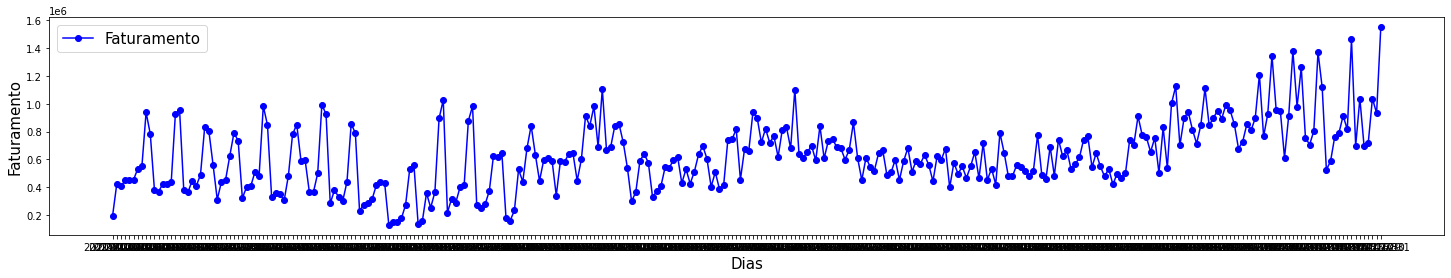

In [69]:
    fig = plt.figure(figsize=(25, 4))
    plt.plot(faturamento['Dia'], faturamento['Faturamento Total'], 'b-o', label= 'Faturamento')
    plt.xlabel("Dias", fontsize = 15)
    plt.ylabel("Faturamento", fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show(True)

### Montando tabelas para modelos

In [70]:
google.columns,pinterest.columns,facebook.columns,tiktok.columns

(Index(['Dia', 'Impressoes', 'Cliques', 'CTR', 'CPM', 'CPC', 'Conversões',
        'TaxaConv', 'CustoConv', 'Custo'],
       dtype='object'),
 Index(['Dia', 'Alcance', 'Frequencia', 'Impressoes', 'Cliques', 'CTR', 'CPM',
        'CPC', 'Conversões', 'Resultados', 'CustoResult', 'CPL', 'Custo'],
       dtype='object'),
 Index(['Dia', 'Alcance', 'Frequencia', 'Impressoes', 'Cliques', 'CTR', 'CPM',
        'CPC', 'Resultados', 'CustoResult', 'Custo'],
       dtype='object'),
 Index(['Dia', 'Alcance', 'Frequencia', 'Impressoes', 'Cliques', 'CTR', 'CPM',
        'CPC', 'Conversões', 'CPA', 'Custo'],
       dtype='object'))

In [71]:
len(faturamento), len(pinterest), len(facebook), len(tiktok), len(google)

(304, 60, 207, 43, 238)

### Modelo1 - A : Analise do impacto da métrica e mídia

In [72]:
datagoogle = pd.merge(faturamento, google, how="inner", on="Dia")
datapinterest = pd.merge(faturamento, pinterest, how="inner", on="Dia")
datafacebook = pd.merge(faturamento, facebook, how="inner", on="Dia")
datatiktok = pd.merge(faturamento, tiktok, how="inner", on="Dia")


# datagoogle.to_csv('./dataset/Tudo/teste/datagoogle.csv')
# datapinterest.to_csv('./dataset/Tudo/teste/datapinterest.csv')
# datafacebook.to_csv('./dataset/Tudo/teste/datafacebook.csv')
# datatiktok.to_csv('./dataset/Tudo/teste/datatiktok.csv')

In [73]:
col_google = {}
for i in google.columns:
    if i != 'Dia':
        col_google[i] = i + "_google"

col_pinterest = {}
for i in pinterest.columns:
    if i != 'Dia':
        col_pinterest[i] = i + "_pinterest"

col_facebook = {}
for i in facebook.columns:
    if i != 'Dia':
        col_facebook[i] = i + "_facebook"

        
col_tiktok = {}
for i in tiktok.columns:
    if i != 'Dia':
        col_tiktok[i] = i + "_tiktok"


In [ ]:
pd.set_option("max_rows", None)
# columns={"Alcance":"Alcance_google", "Frequencia":"Frequencia_google", "Impressoes":"Impressoes_google", "Cliques":"Cliques_google", "CTR":"CTR_google","Custo":"Custo_google"}
# google.rename(columns={"Impressoes":"Impressoes_google", "Cliques":"Cliques_google", "CTR":"CTR_google","Custo":"Custo_google"})
dataModelo1a = pd.merge(faturamento, facebook.rename(columns=col_facebook), how="outer", on ="Dia", validate="1:1")
dataModelo1a = pd.merge(dataModelo1a, google.rename(columns=col_google), how="outer", on ="Dia",  validate="1:1")
dataModelo1a = pd.merge(dataModelo1a, tiktok.rename(columns=col_tiktok), how="outer", on ="Dia",  validate="1:1")
dataModelo1a = pd.merge(dataModelo1a, pinterest.rename(columns=col_pinterest), how="outer", on ="Dia",  validate="1:1")


dataModelo1a = dataModelo1a.fillna(0)

dataModelo1a = pd.DataFrame(dataModelo1a.to_numpy(), columns=dataModelo1a.columns, index = dataModelo1a.index)

dataModelo1a = dataModelo1a.infer_objects()

dataModelo1a.to_csv('./dataset/Tudo/amostra/dataModelo1b.csv')
dataModelo1a.head(3)

Faturamento Total         Dia  Alcance_facebook  Frequencia_facebook  \
0      195958.964077  2021-01-01                 0                  0.0   
1      423931.763792  2021-01-02                 0                  0.0   
2      405958.834973  2021-01-03                 0                  0.0   

   Impressoes_facebook  Cliques_facebook  CTR_facebook  CPM_facebook  \
0                    0                 0           0.0           0.0   
1                    0                 0           0.0           0.0   
2                    0                 0           0.0           0.0   

   CPC_facebook  Resultados_facebook  ...  Impressoes_pinterest  \
0           0.0                  0.0  ...                   0.0   
1           0.0                  0.0  ...                   0.0   
2           0.0                  0.0  ...                   0.0   

   Cliques_pinterest  CTR_pinterest  CPM_pinterest  CPC_pinterest  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   

   Conversões_pinterest  Resultados_pinterest  CustoResult_pinterest  \
0                   0.0                   0.0                    0.0   
1                   0.0                   0.0                    0.0   
2                   0.0                   0.0                    0.0   

   CPL_pinterest  Custo_pinterest  
0            0.0              0.0  
1            0.0              0.0  
2            0.0              0.0  

[3 rows x 43 columns]

### Modelo 1 - B

In [ ]:
metricasMod1b = ['Faturamento Total','Dia','Cliques_facebook','Conversões_google','Cliques_google']

dataModelo1b = pd.merge(faturamento, facebook.rename(columns=col_facebook), how="inner", on ="Dia", validate="1:1")
dataModelo1b = pd.merge(dataModelo1b, google.rename(columns=col_google), how="inner", on ="Dia",  validate="1:1")
dataModelo1b = pd.DataFrame(dataModelo1b.to_numpy(), columns=dataModelo1b.columns, index = dataModelo1b.index)

dataModelo1b = dataModelo1b.infer_objects()
dataModelo1b = dataModelo1b[metricasMod1b]
dataModelo1b.to_csv('./dataset/Tudo/amostra/dataModelo1b.csv')
dataModelo1b.head(3)


Faturamento Total         Dia  Cliques_facebook  Conversões_google  \
0      527602.474674  2021-04-08               193             237.75   
1      438923.059902  2021-04-09               177             199.67   
2      679255.870441  2021-04-10               945             237.01   

   Cliques_google  
0             660  
1             443  
2             530

### Modelo2 - A : Analise do impacto da métrica

In [76]:
dataModelo2a = ( tiktok + pinterest + facebook + google)
dataModelo2a = dataModelo2a.dropna(axis=0, how='all')
dataModelo2a = dataModelo2a.dropna(axis=1, how='all')
dataModelo2a['Dia'] = dataModelo2a.index

metricas = ['Dia','Impressoes', 'Cliques','Custo']

dataModelo2a = pd.merge(faturamento,dataModelo2a[metricas], how="inner", on ="Dia",  validate="1:1")
dataModelo2a = pd.DataFrame(dataModelo2a.to_numpy(), columns=dataModelo2a.columns, index = dataModelo2a.index)
dataModelo2a = dataModelo2a.infer_objects()
# dataModelo2a.to_csv('./dataset/Tudo/teste/dataModelo2a.csv')
dataModelo2a

Faturamento Total         Dia  Impressoes  Cliques    Custo
0        7.403778e+05  2021-09-01    598123.0   4419.0  2349.20
1        7.069125e+05  2021-09-02   1490804.0   4550.0  2348.46
2        9.099986e+05  2021-09-03    295566.0   2676.0  2251.96
3        7.744884e+05  2021-09-04    292036.0   3054.0  1860.04
4        7.582029e+05  2021-09-05    376854.0   3719.0  2033.97
5        6.542358e+05  2021-09-06    382992.0   3604.0  1591.51
6        7.549147e+05  2021-09-07    780573.0   5827.0  2646.00
7        5.023923e+05  2021-09-08   1260628.0   4900.0  2648.67
8        8.301660e+05  2021-09-09    625542.0   5163.0  3143.89
9        5.384395e+05  2021-09-10    539041.0   4559.0  2648.83
10       1.002961e+06  2021-09-11    590022.0   6038.0  4148.42
11       1.125524e+06  2021-09-12    644608.0   6531.0  3510.59
12       7.011632e+05  2021-09-13    553566.0   5569.0  3012.75
13       8.969962e+05  2021-09-14    607448.0   5436.0  3482.68
14       9.401390e+05  2021-09-15    487437.0   4931.0  3392.82
15       8.139696e+05  2021-09-16    548540.0   4911.0  4115.57
16       7.140616e+05  2021-09-17    608218.0   4453.0  3461.89
17       8.455236e+05  2021-09-18    555470.0   5576.0  4086.37
18       1.110333e+06  2021-09-19    645922.0   6134.0  3773.27
19       8.439033e+05  2021-09-20    823667.0   5979.0  5268.52
20       8.990239e+05  2021-09-21    845846.0   5890.0  5537.29
21       9.495863e+05  2021-09-22    828940.0   6123.0  5415.72
22       8.938383e+05  2021-09-23    851958.0   6317.0  5395.13
23       9.932352e+05  2021-09-24    892762.0   6841.0  6098.05
24       9.527396e+05  2021-09-25    955323.0   6868.0  6203.64
25       8.550891e+05  2021-09-26    994277.0   7423.0  6541.46
26       6.778743e+05  2021-09-27    591949.0   5968.0  3947.88
27       7.274875e+05  2021-09-28    672891.0   5934.0  4174.45
28       8.533243e+05  2021-09-29   1626170.0   5722.0  4213.52
29       8.090552e+05  2021-09-30   1634476.0   5945.0  4194.94
30       8.959085e+05  2021-10-01    409511.0   4263.0  4259.17

### Modelo 2 - B

In [77]:
dataModelo2b = ( facebook + google)
dataModelo2b = dataModelo2b.dropna(axis=0, how='all')
dataModelo2b = dataModelo2b.dropna(axis=1, how='all')
dataModelo2b['Dia'] = dataModelo2b.index
metricas = ['Dia','Impressoes', 'Cliques','Custo']
metricas = ['Dia','Impressoes', 'Cliques','Custo']
dataModelo2b = pd.merge(faturamento, dataModelo2b[metricas], how="inner", on ="Dia",  validate="1:1")
dataModelo2b = pd.DataFrame(dataModelo2b.to_numpy(), columns=dataModelo2b.columns, index=dataModelo2b.index)
dataModelo2b = dataModelo2b.infer_objects()

# dataModelo2b.to_csv('./dataset/Tudo/teste/dataModelo2b.csv')
dataModelo2b

Faturamento Total         Dia  Impressoes  Cliques    Custo
0         5.276025e+05  2021-04-08    911350.0    853.0   931.02
1         4.389231e+05  2021-04-09    986770.0    620.0   879.17
2         6.792559e+05  2021-04-10     52919.0   1475.0  1361.05
3         8.425233e+05  2021-04-11     57132.0   1439.0  1216.92
4         6.344634e+05  2021-04-12    823390.0    917.0   701.84
5         4.459546e+05  2021-04-13    902128.0    469.0   553.69
6         5.947687e+05  2021-04-14   1570808.0    509.0   406.67
7         6.130922e+05  2021-04-15    849417.0   1112.0  1372.96
8         5.900828e+05  2021-04-16    941941.0    947.0   682.44
9         3.399885e+05  2021-04-17    952220.0    453.0   596.11
10        5.898790e+05  2021-04-18    817051.0    947.0   867.57
11        5.819318e+05  2021-04-19    788358.0    717.0   814.19
12        6.420439e+05  2021-04-20    945600.0   1113.0  1222.15
13        6.424013e+05  2021-04-21     47879.0   1428.0  1572.98
14        4.469718e+05  2021-04-22    826597.0    979.0   865.74
15        6.003987e+05  2021-04-23     73919.0   1424.0  1772.03
16        9.136341e+05  2021-04-24    116005.0   1832.0  3003.78
17        8.405419e+05  2021-04-25    151540.0   2800.0  3106.32
18        9.805884e+05  2021-04-26   1143270.0   1969.0  2823.97
19        6.914572e+05  2021-04-27    994258.0   1567.0  1862.75
20        1.105554e+06  2021-04-28   1034486.0   2380.0  3187.92
21        6.685874e+05  2021-04-29    947702.0   2340.0  3532.02
22        6.887347e+05  2021-04-30   1169094.0   2731.0  4191.12
23        7.228215e+05  2021-05-03    875882.0   1213.0  1286.45
24        5.386245e+05  2021-05-04    416858.0    920.0  1368.69
25        5.905180e+05  2021-05-07    533002.0    877.0   838.15
26        6.400727e+05  2021-05-08    766609.0   1562.0  1543.39
27        5.763427e+05  2021-05-09    616222.0   1631.0  1937.63
28        3.309553e+05  2021-05-10   1352426.0    313.0   192.96
29        3.700698e+05  2021-05-11    510773.0    540.0   479.41
30        4.068491e+05  2021-05-12    541424.0    557.0   601.36
31        5.421456e+05  2021-05-13    488302.0    501.0   562.67
32        5.377509e+05  2021-05-14    562344.0   1109.0   715.44
33        5.982473e+05  2021-05-15   1543061.0    642.0   637.05
34        6.181418e+05  2021-05-16    944893.0   1054.0   856.97
35        4.294475e+05  2021-05-17    593997.0    551.0   336.42
36        5.300872e+05  2021-05-18    552880.0    605.0   303.72
37        4.252172e+05  2021-05-19    548329.0    553.0   381.60
38        5.124992e+05  2021-05-20   1275088.0    331.0   236.08
39        6.355188e+05  2021-05-21    639421.0   1078.0   869.11
40        6.961391e+05  2021-05-22    755009.0   1294.0  1047.49
41        6.061062e+05  2021-05-23   1026971.0   1271.0   917.58
42        4.033995e+05  2021-05-24    569391.0    769.0   537.78
43        5.084270e+05  2021-05-25    610463.0    689.0   678.88
44        3.852368e+05  2021-05-26   1357563.0    354.0   216.67
45        4.159323e+05  2021-05-27    551745.0    675.0   662.58
46        7.407243e+05  2021-05-28    786638.0   1424.0  1021.30
47        7.456180e+05  2021-05-29    959758.0   1704.0  1427.39
48        8.162574e+05  2021-05-30     88816.0   1632.0  1598.04
49        4.552072e+05  2021-05-31    617389.0    557.0   369.47
50        6.768014e+05  2021-06-01     22906.0   1334.0  1075.29
51        6.611992e+05  2021-06-02     35061.0   1008.0  1022.29
52        9.428037e+05  2021-06-03    116981.0   2019.0  1837.26
53        9.005631e+05  2021-06-04    125514.0   2274.0  1975.58
54        7.215385e+05  2021-06-05    132412.0   2103.0  1968.89
55        8.202893e+05  2021-06-06    127659.0   2287.0  1911.60
56        7.202197e+05  2021-06-07     69657.0   1429.0  1247.82
57        7.681196e+05  2021-06-08    100799.0   1636.0  1604.54
58        6.180821e+05  2021-06-09     85801.0   1671.0  1894.68
59        8.129961e+05  2021-06-10     85095.0   1584.0  1666.83
60        8.327755e+05  2021-06-11     5

## Correlação

In [78]:
def correlationPlot(data):
    colunas = list(data.columns)
    colunas.pop(colunas.index("Dia"))
    correlation = data[colunas].corr()
#     print(data.dtypes)
    fig, ax = plt.subplots(figsize=(15,15))  
    plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
    plot

#### Modelo 1 - A

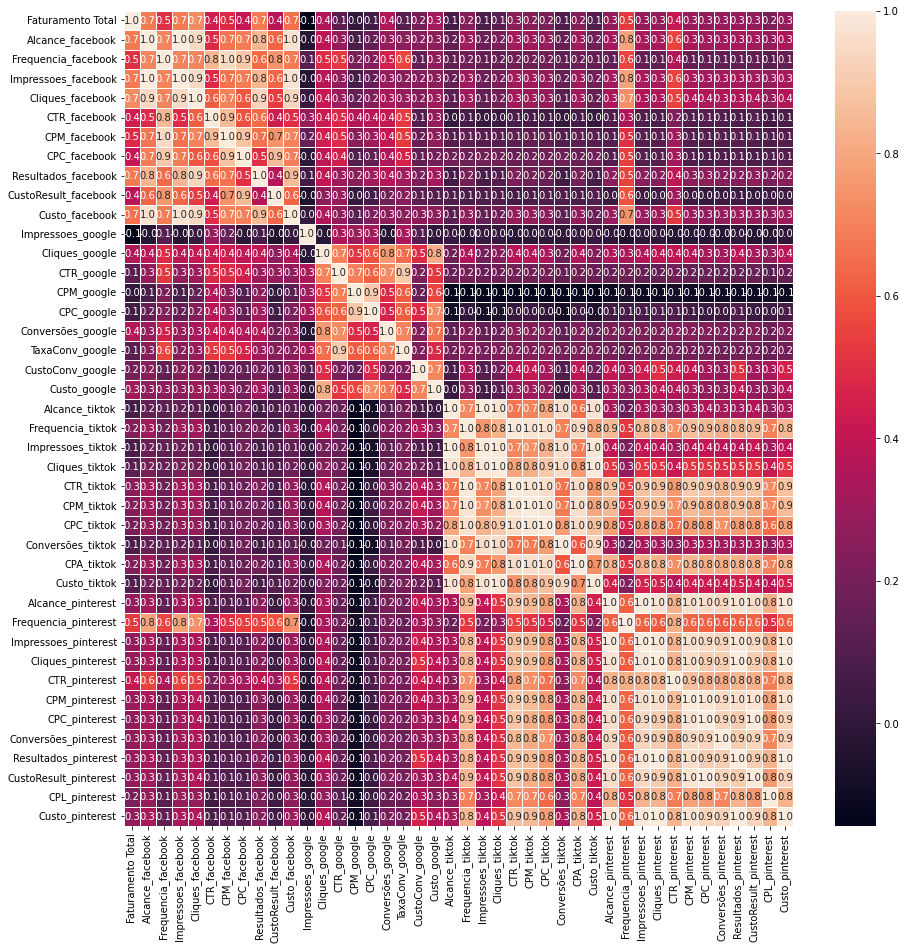

In [79]:
correlationPlot(dataModelo1a)

#### Modelo 1 - B

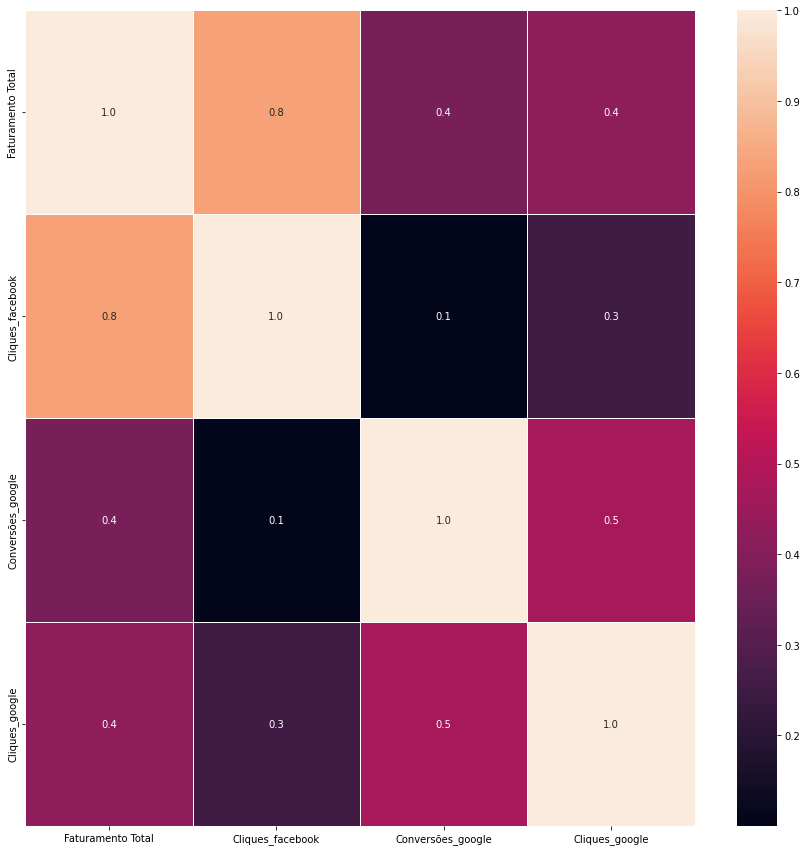

In [80]:
correlationPlot(dataModelo1b)

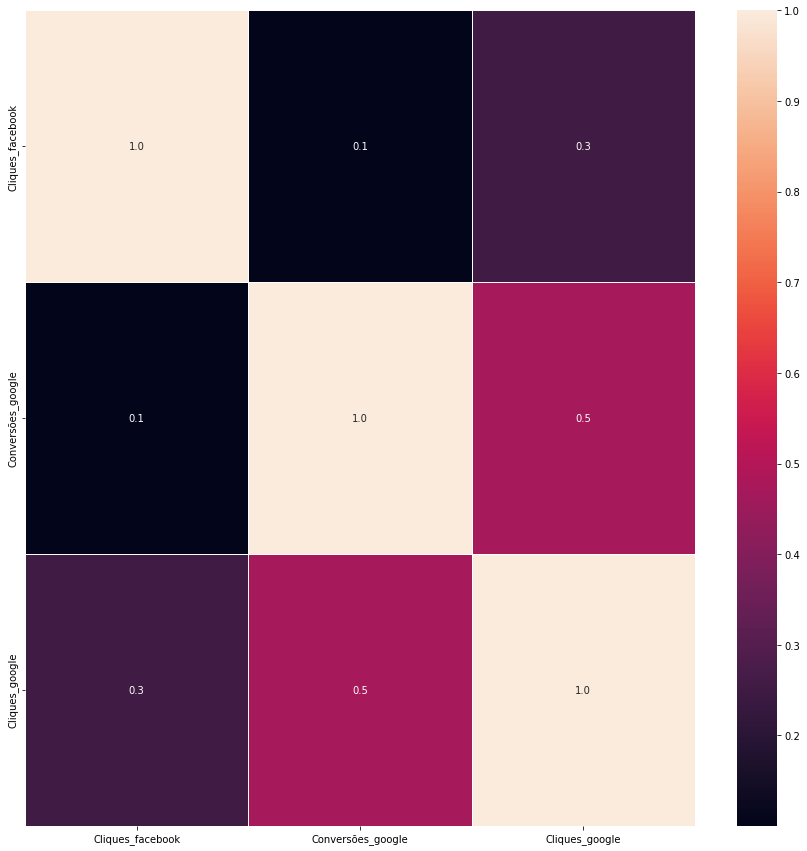

In [81]:
colunas = list(dataModelo1b.columns)
colunas
colunas.pop(colunas.index('Faturamento Total'))

correlationPlot(dataModelo1b[colunas])

#### Modelo 2 - A

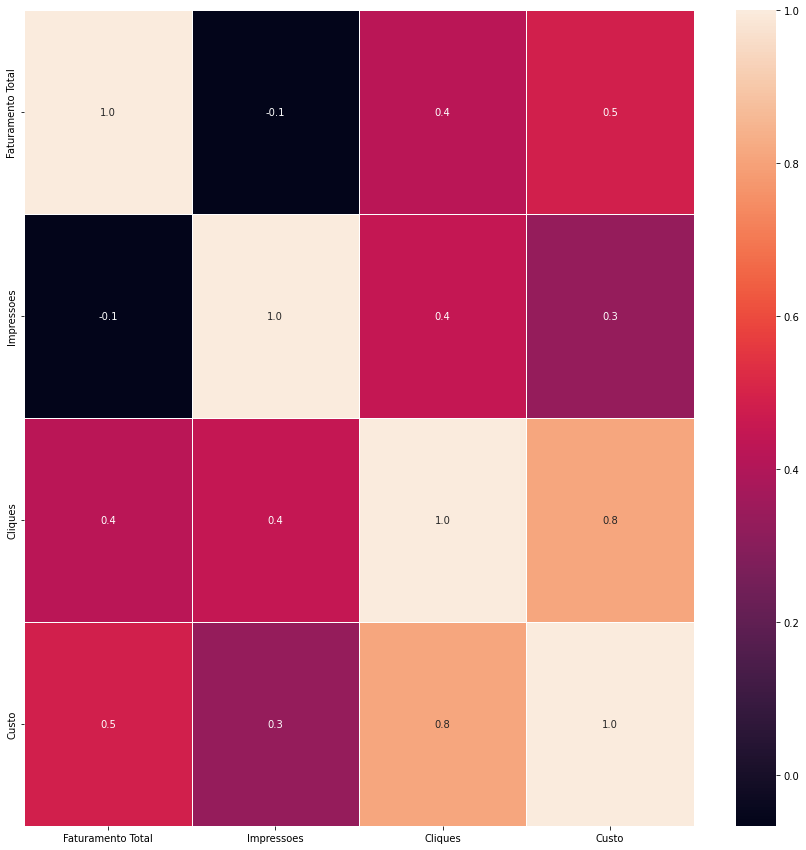

In [82]:
# dataModelo2a.corr()
correlationPlot(dataModelo2a)

#### Modelo 2 - B

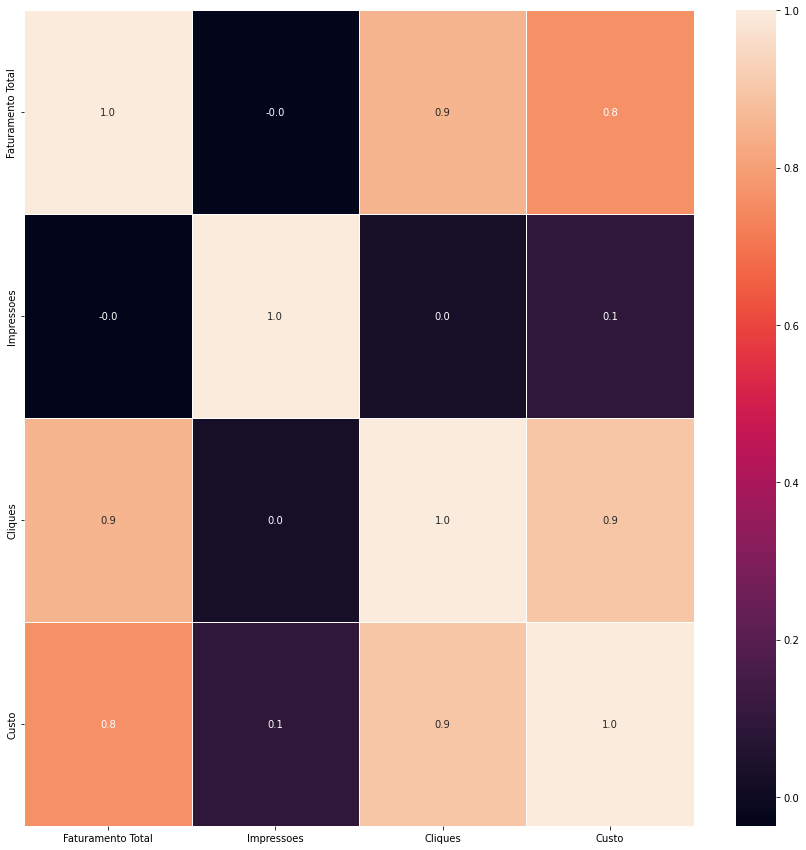

In [83]:
correlationPlot(dataModelo2b)

### Analise descritiva

In [84]:
dataModelo1a.columns

Index(['Faturamento Total', 'Dia', 'Alcance_facebook', 'Frequencia_facebook',
       'Impressoes_facebook', 'Cliques_facebook', 'CTR_facebook',
       'CPM_facebook', 'CPC_facebook', 'Resultados_facebook',
       'CustoResult_facebook', 'Custo_facebook', 'Impressoes_google',
       'Cliques_google', 'CTR_google', 'CPM_google', 'CPC_google',
       'Conversões_google', 'TaxaConv_google', 'CustoConv_google',
       'Custo_google', 'Alcance_tiktok', 'Frequencia_tiktok',
       'Impressoes_tiktok', 'Cliques_tiktok', 'CTR_tiktok', 'CPM_tiktok',
       'CPC_tiktok', 'Conversões_tiktok', 'CPA_tiktok', 'Custo_tiktok',
       'Alcance_pinterest', 'Frequencia_pinterest', 'Impressoes_pinterest',
       'Cliques_pinterest', 'CTR_pinterest', 'CPM_pinterest', 'CPC_pinterest',
       'Conversões_pinterest', 'Resultados_pinterest', 'CustoResult_pinterest',
       'CPL_pinterest', 'Custo_pinterest'],
      dtype='object')

In [85]:
dataModelo1b.columns

Index(['Faturamento Total', 'Dia', 'Cliques_facebook', 'Conversões_google',
       'Cliques_google'],
      dtype='object')

In [86]:
dataModelo2a.columns

Index(['Faturamento Total', 'Dia', 'Impressoes', 'Cliques', 'Custo'], dtype='object')

In [87]:
dataModelo2a.columns

Index(['Faturamento Total', 'Dia', 'Impressoes', 'Cliques', 'Custo'], dtype='object')

In [88]:
dataModelo2b.columns


Index(['Faturamento Total', 'Dia', 'Impressoes', 'Cliques', 'Custo'], dtype='object')

In [89]:
# atributos = ['Faturamento Total', 'Dia', 'Impressoes', 'Cliques','CTR']
# dataModelo2b = dataModelo2b[atributos]
dataModelos = [dataModelo1a, dataModelo1b, dataModelo2a, dataModelo2b]

In [90]:
dataModelo1a.describe()

Faturamento Total  Alcance_facebook  Frequencia_facebook  \
count       3.040000e+02        304.000000           304.000000   
mean        6.235162e+05      70357.911184             0.797425   
std         2.431301e+05      90899.864141             0.617812   
min         1.286776e+05          0.000000             0.000000   
25%         4.502816e+05          0.000000             0.000000   
50%         5.996475e+05      43838.000000             1.037919   
75%         7.745836e+05      92737.500000             1.064942   
max         1.550524e+06     543505.000000             2.257354   

       Impressoes_facebook  Cliques_facebook  CTR_facebook  CPM_facebook  \
count           304.000000        304.000000    304.000000    304.000000   
mean          75056.924342        543.029605      0.599660      7.264159   
std           98122.297536        656.778011      0.498065      5.893087   
min               0.000000          0.000000      0.000000      0.000000   
25%               0.000000          0.000000      0.000000      0.000000   
50%           45212.000000        281.000000      0.591079      8.391305   
75%           97020.500000        849.500000      1.002467     10.420845   
max          580811.000000       3137.000000      1.909052     26.073288   

       CPC_facebook  Resultados_facebook  CustoResult_facebook  ...  \
count    304.000000           304.000000            304.000000  ...   
mean       1.012824           127.421053              5.814107  ...   
std        0.916966           150.877500              8.531862  ...   
min        0.000000             0.000000              0.000000  ...   
25%        0.000000             0.000000              0.000000  ...   
50%        0.952503            63.000000              2.904148  ...   
75%        1.623830           227.250000              8.397129  ...   
max        4.128985           910.000000             66.267712  ...   

       Impressoes_pinterest  Cliques_pinterest  CTR_pinterest  CPM_pinterest  \
count            304.000000         304.000000     304.000000     304.000000   
mean           13496.950658         151.960526       0.001542       0.495104   
std            41472.685073         479.994051       0.003713       1.486255   
min                0.000000           0.000000       0.000000       0.000000   
25%                0.000000           0.000000       0.000000       0.000000   
50%                0.000000           0.000000       0.000000       0.000000   
75%                0.000000           0.000000       0.000000       0.000000   
max           183803.000000        2367.000000       0.016196       5.926199   

       CPC_pinterest  Conversões_pinterest  Resultados_pinterest  \
count     304.000000            304.000000            304.000000   
mean        0.046104             14.980263            148.993421   
std         0.138061             47.141941            469.982318   
min         0.000000              0.000000              0.000000   
25%         0.000000              0.000000              0.000000   
50%         0.000000              0.000000              0.000000   
75%         0.000000              0.000000              0.000000   
max         0.684091            253.000000           2331.000000   

       CustoResult_pinterest  CPL_pinterest  Custo_pinterest  
count             304.000000     304.000000       304.000000  
mean                0.046104      10.871117        65.581612  
std                 0.138061      41.506266       204.356451  
min                 0.000000       0.000000         0.000000  
25%                 0.000000       0.000000         0.000000  
50%                 0.000000       0.000000         0.000000  
75%                 0.000000       0.000000         0.000000  
max                 0.684091     436.500000       873.000000  

[8 rows x 42 columns]

In [91]:
dataModelo1b.describe()

Faturamento Total  Cliques_facebook  Conversões_google  Cliques_google
count       2.000000e+02        200.000000          200.00000      200.000000
mean        6.894831e+05        789.420000          296.86350      656.325000
std         2.122452e+05        644.807746          141.46154      293.368599
min         3.309553e+05         35.000000           31.00000       85.000000
25%         5.385782e+05        255.000000          200.75500      449.250000
50%         6.507149e+05        633.500000          272.08000      611.000000
75%         8.058145e+05       1163.000000          354.46250      815.500000
max         1.550524e+06       3137.000000         1285.54000     1748.000000

In [92]:
dataModelo2a.describe()

Faturamento Total    Impressoes      Cliques        Custo
count       3.100000e+01  3.100000e+01    31.000000    31.000000
mean        8.281247e+05  7.422955e+05  5333.000000  3798.601935
std         1.430875e+05  3.514755e+05  1124.317363  1338.812976
min         5.023923e+05  2.920360e+05  2676.000000  1591.510000
25%         7.339327e+05  5.510530e+05  4554.500000  2648.750000
50%         8.439033e+05  6.255420e+05  5576.000000  3773.270000
75%         9.045112e+05  8.489020e+05  6008.500000  4236.345000
max         1.125524e+06  1.634476e+06  7423.000000  6541.460000

In [93]:
dataModelo2b.describe()

Faturamento Total    Impressoes      Cliques        Custo
count       2.000000e+02  2.000000e+02   200.000000   200.000000
mean        6.894831e+05  3.756336e+05  1445.745000  1700.272600
std         2.122452e+05  3.943795e+05   772.780615  1195.262775
min         3.309553e+05  2.290600e+04   242.000000   192.960000
25%         5.385782e+05  6.952050e+04   865.500000   869.470000
50%         6.507149e+05  1.907935e+05  1294.500000  1314.395000
75%         8.058145e+05  5.885085e+05  1836.250000  2187.532500
max         1.550524e+06  1.570808e+06  3909.000000  6230.030000

## SEMANAL

In [94]:
s1 = dataModelo1a.copy()
s2 = dataModelo1b.copy()
s3 = dataModelo2a.copy()
s4 = dataModelo2b.copy()

s1['SemanaDoAno'] = pd.to_datetime(s1['Dia']).dt.isocalendar().week
s2['SemanaDoAno'] = pd.to_datetime(s2['Dia']).dt.isocalendar().week
s3['SemanaDoAno'] = pd.to_datetime(s3['Dia']).dt.isocalendar().week
s4['SemanaDoAno'] = pd.to_datetime(s4['Dia']).dt.isocalendar().week

g1 = s1.groupby('SemanaDoAno')
g2 = s2.groupby('SemanaDoAno')
g3 = s3.groupby('SemanaDoAno')
g4 = s4.groupby('SemanaDoAno')

g1 = g1.aggregate(np.sum)
g2 = g2.aggregate(np.sum)
g3 = g3.aggregate(np.sum)
g4 = g4.aggregate(np.sum)

semanais = [g1,g2,g3,g4 ]

g2.head(3)

Faturamento Total  Cliques_facebook  Conversões_google  \
SemanaDoAno                                                           
14                2.488305e+06              2167             942.93   
15                3.808229e+06              1451            1622.92   
16                4.667924e+06              6068            1890.45   

             Cliques_google  
SemanaDoAno                  
14                     2220  
15                     3903  
16                     4225

In [95]:
g2.shape

(30, 4)

### Padronização: média zero e desvio padrão 1 

In [96]:
dataModelos_norm = []
for i in dataModelos:
    dataModelos_norm.append(normaliza(i))

### Transformação polinomial

In [97]:
selecao = [] ### aqui lista para retirar elementos ja lineares
aux = []
for i in dataModelos:
    aux.append(polinomio2(i, selecao))
    
dataModelos_M2 = []
for i in aux:
    dataModelos_M2.append(normaliza(i))

### Vsualização dos dados

In [98]:
def plot_atributos(data):
    colunas = list(data.columns)
    colunas.pop(colunas.index("Faturamento Total"))
    colunas.pop(colunas.index("Dia"))
    for i in colunas:
        plt.figure(figsize=(10,6))
        plt.plot(list(data[i].values), list(data["Faturamento Total"]), 'o', color='black');
        plt.xlabel(i, fontsize = 20) 
        plt.ylabel('Faturamento Total', fontsize = 20) 
        plt.show(True) 
    

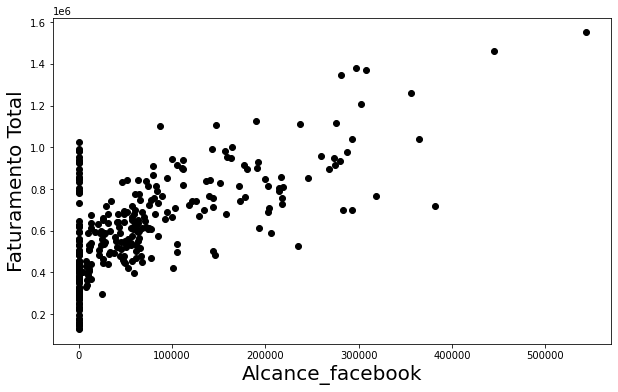

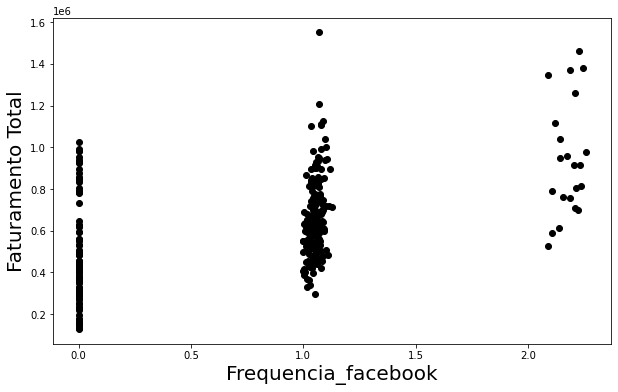

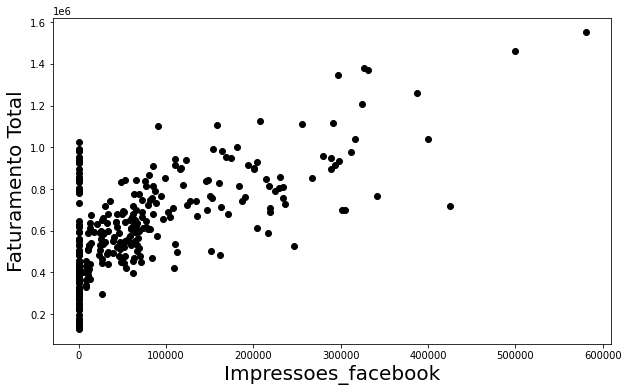

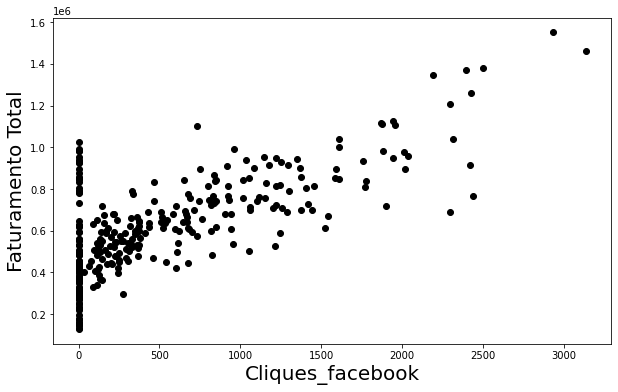

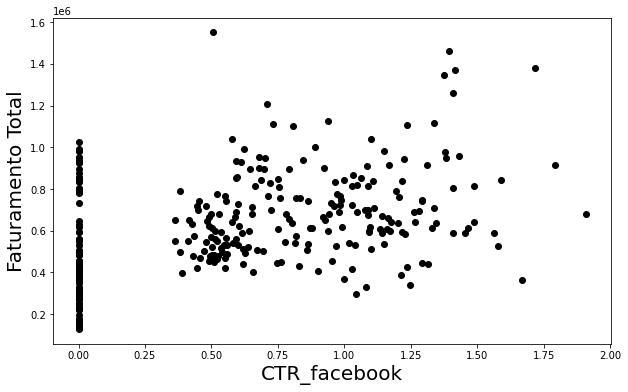

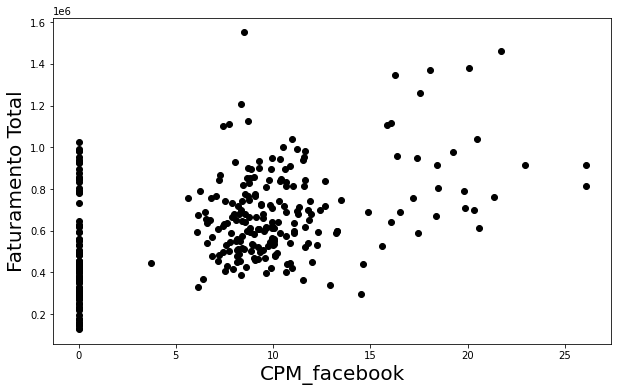

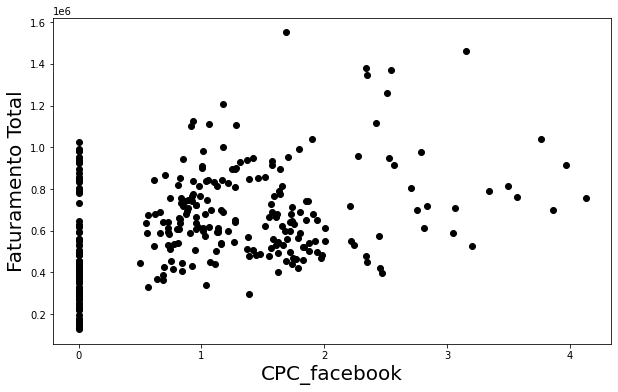

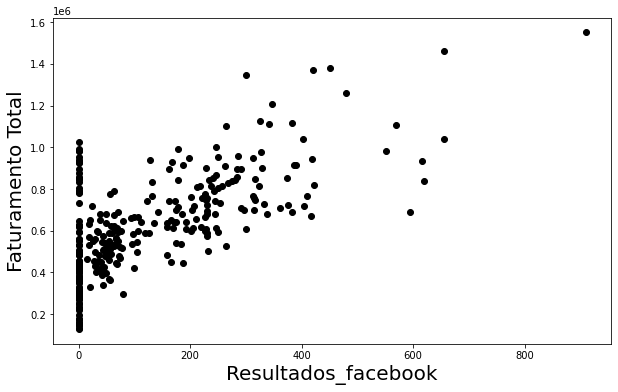

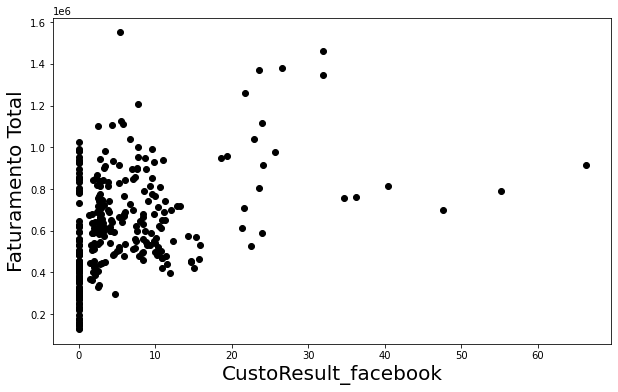

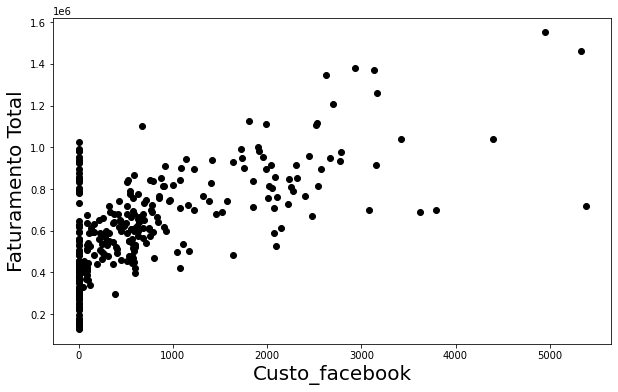

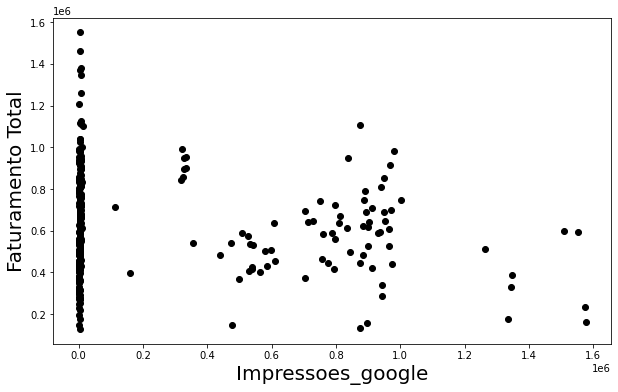

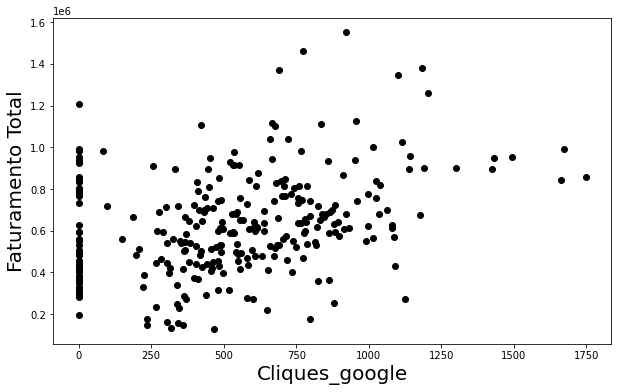

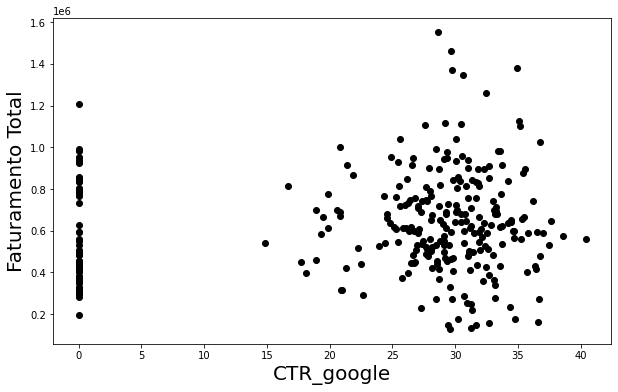

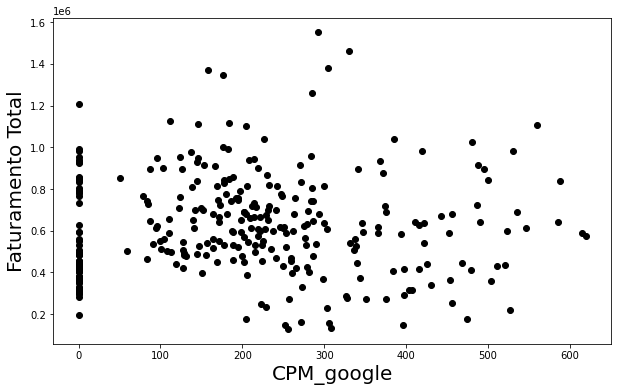

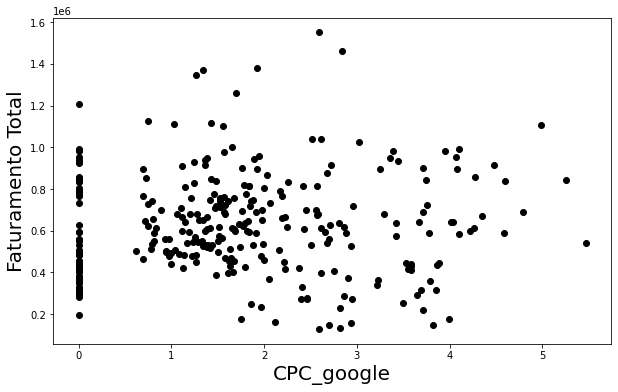

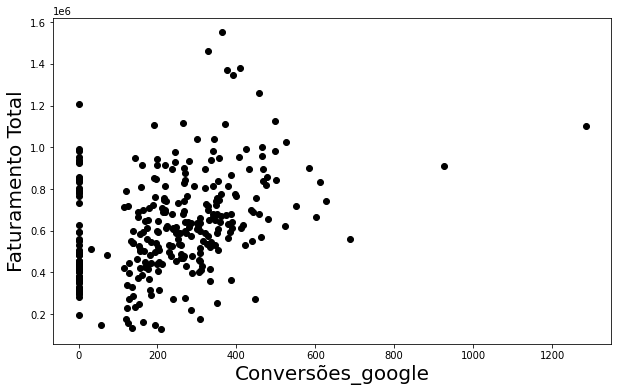

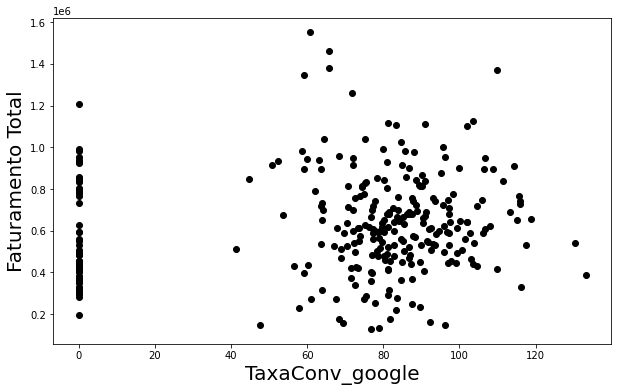

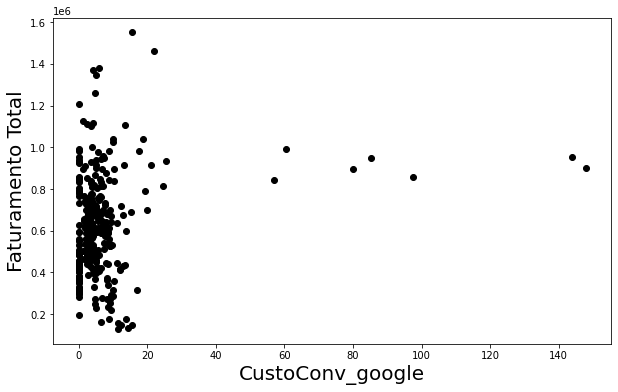

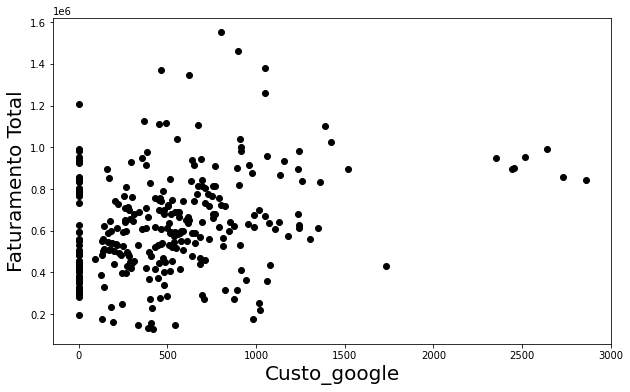

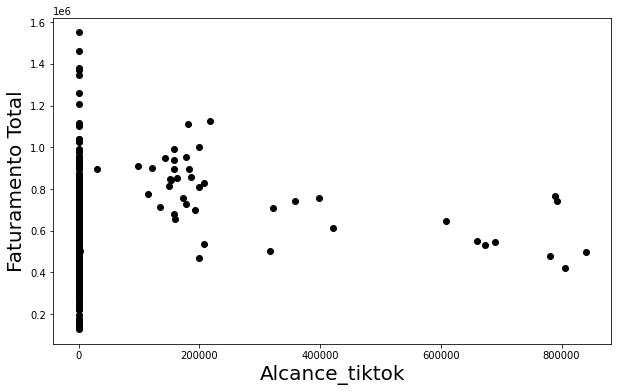

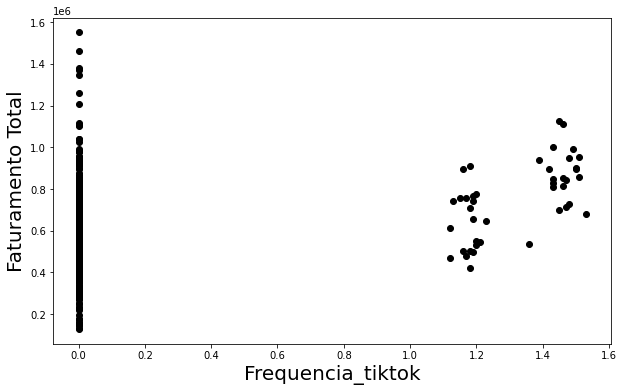

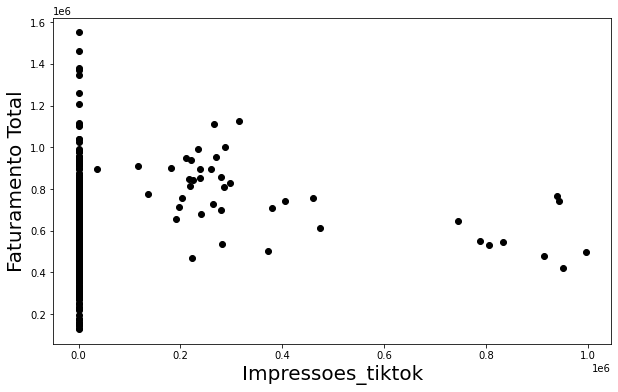

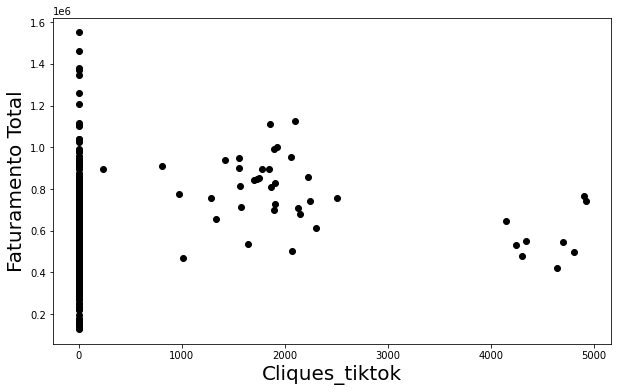

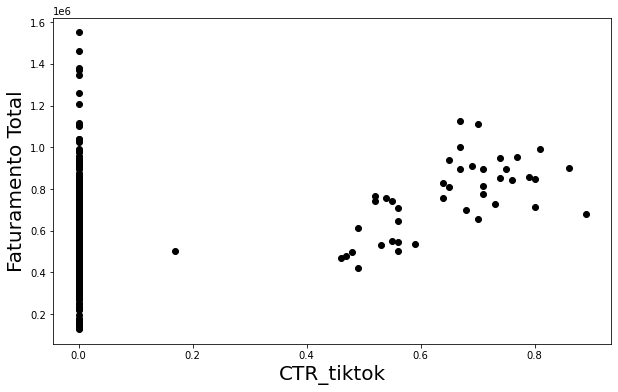

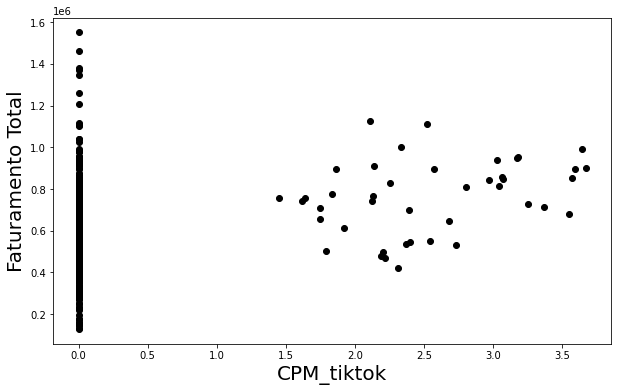

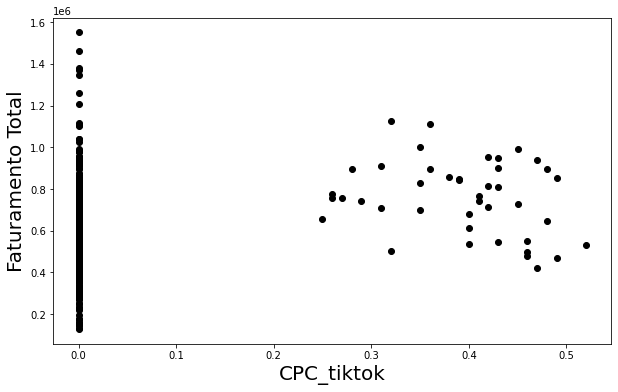

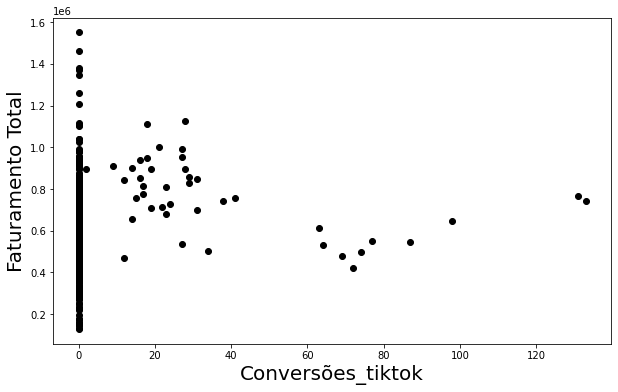

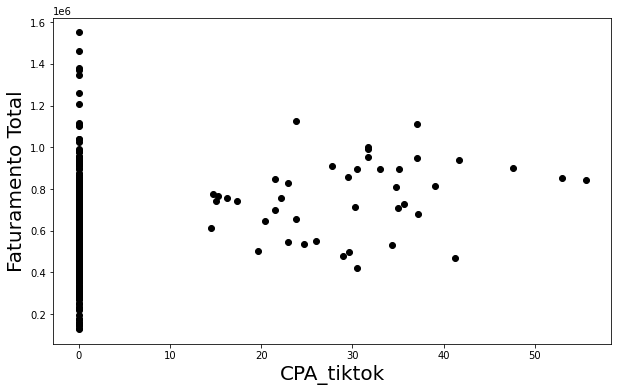

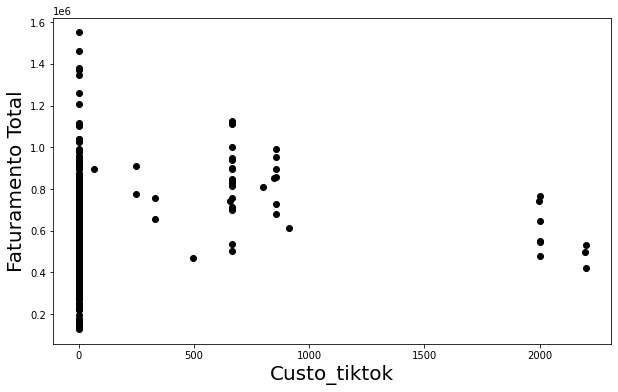

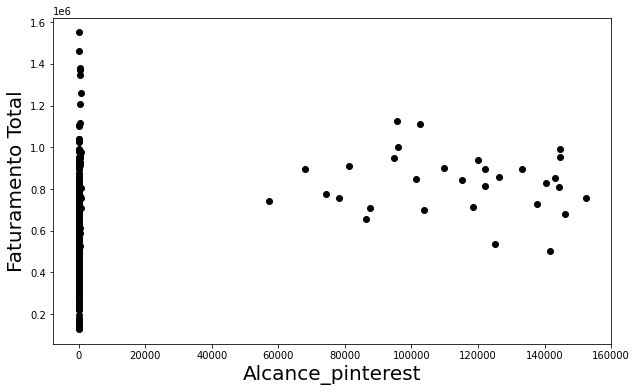

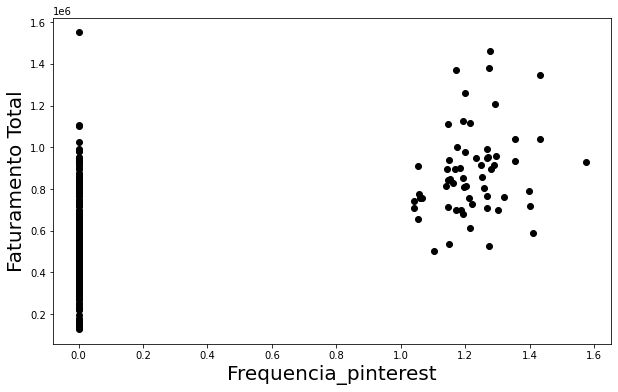

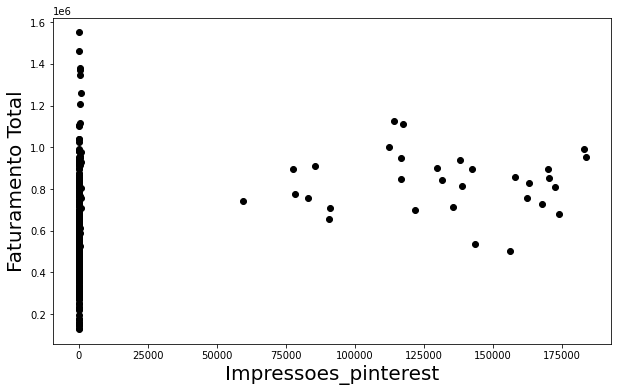

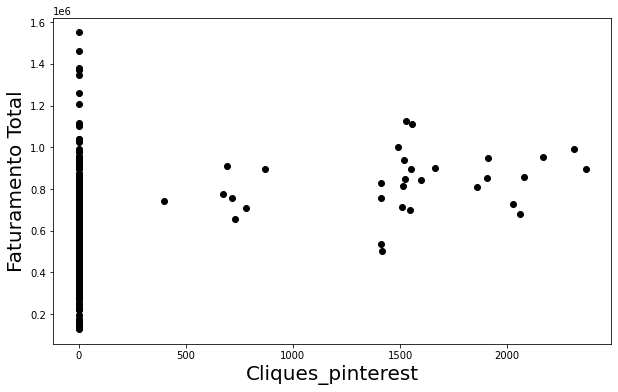

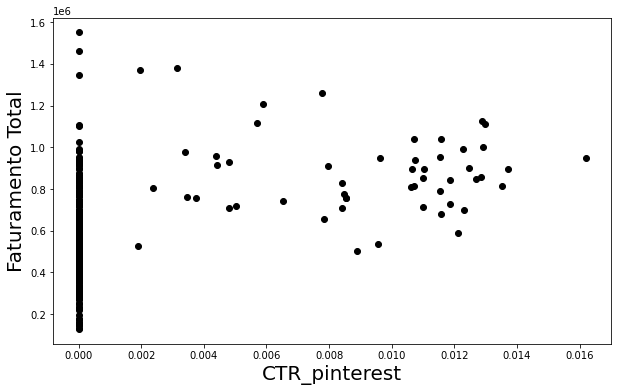

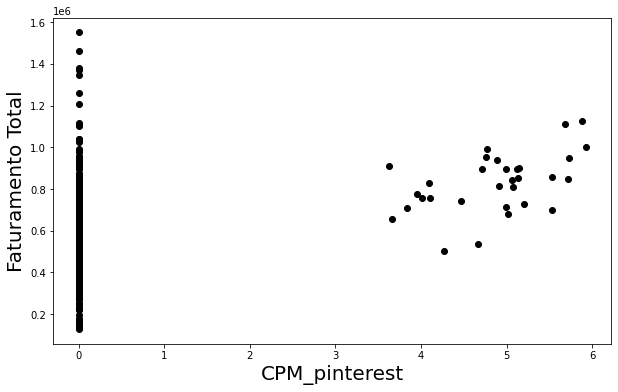

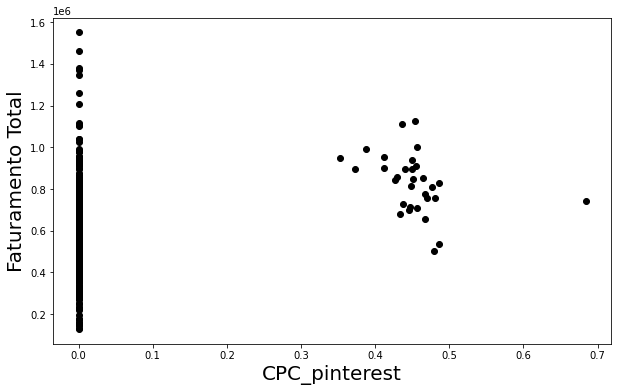

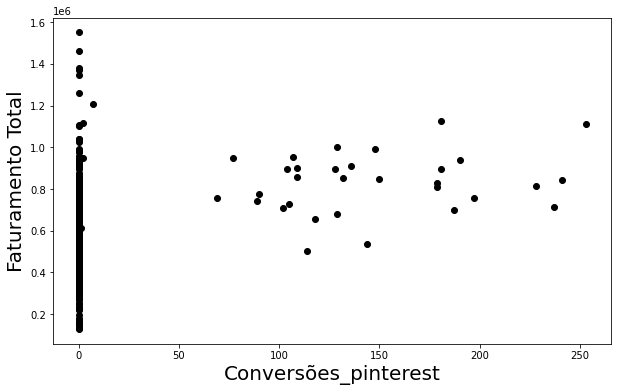

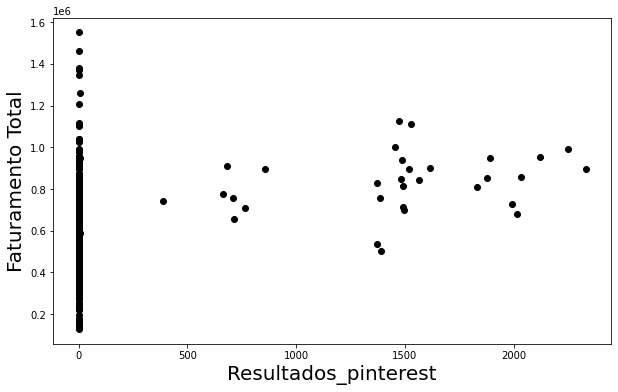

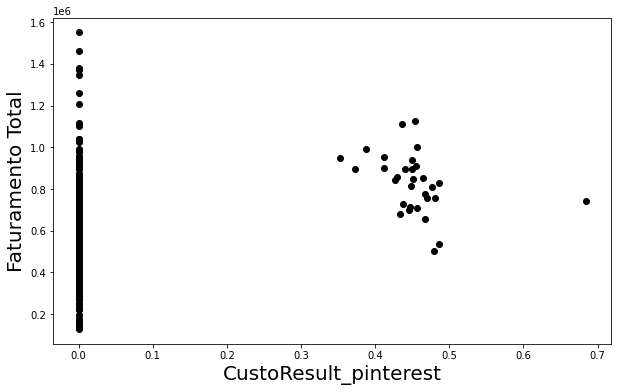

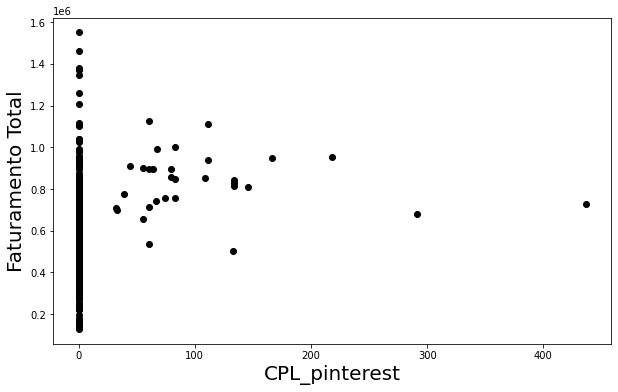

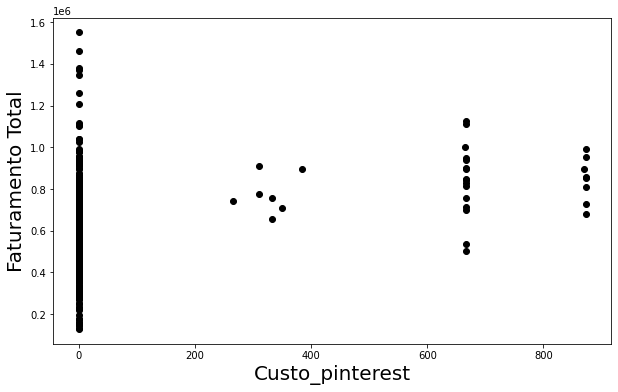

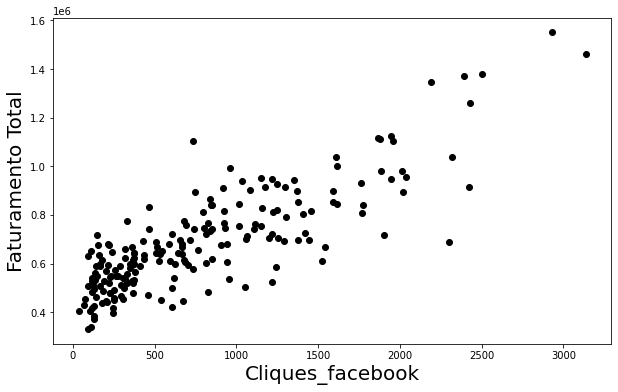

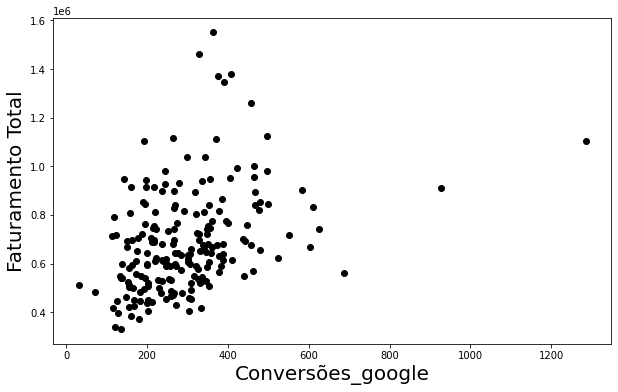

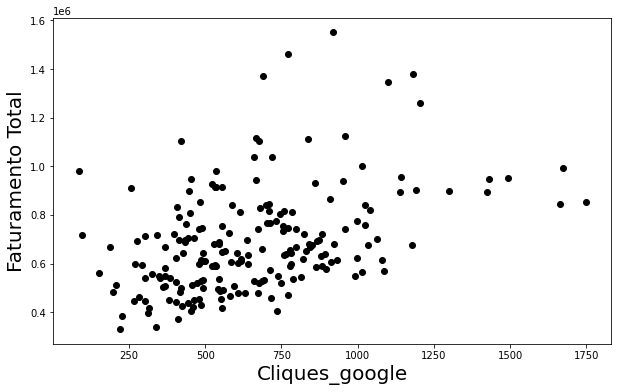

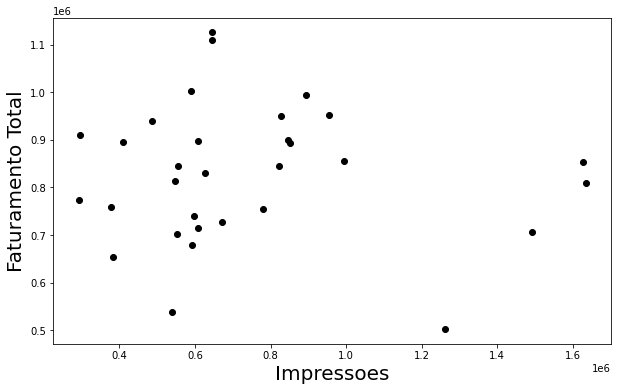

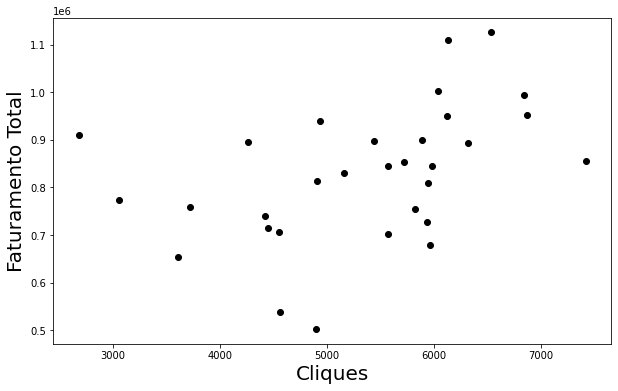

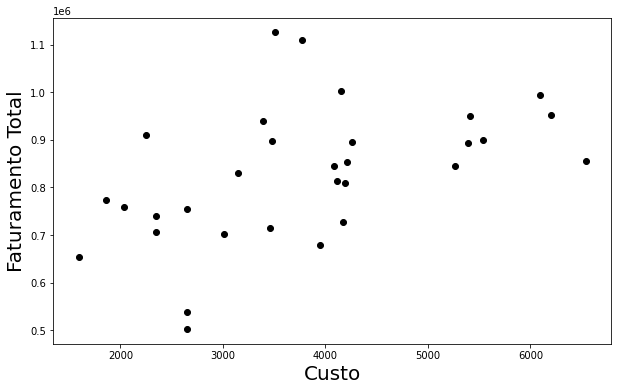

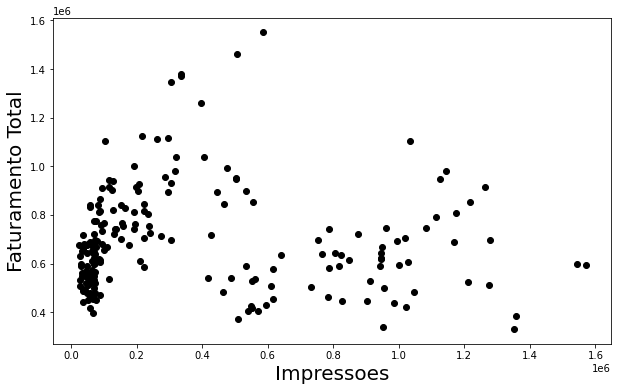

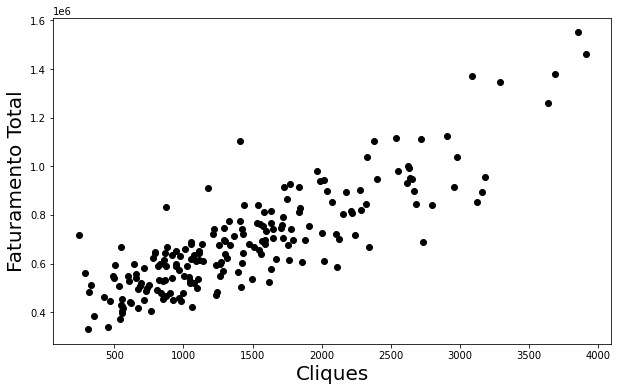

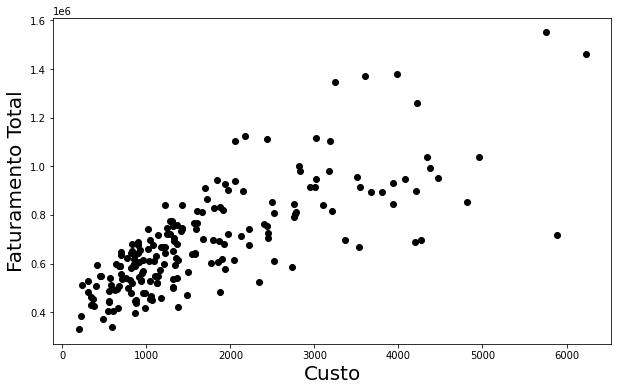

In [99]:
for i in dataModelos:    
    plot_atributos(i)

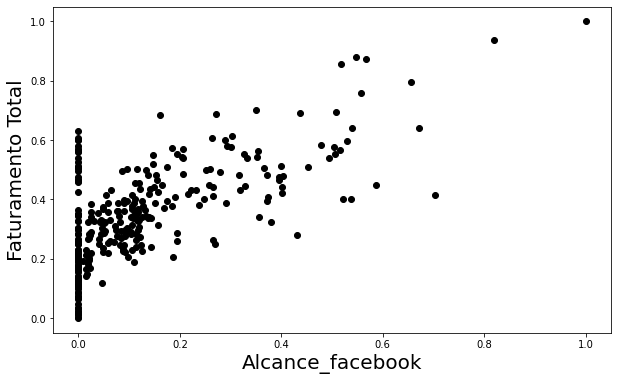

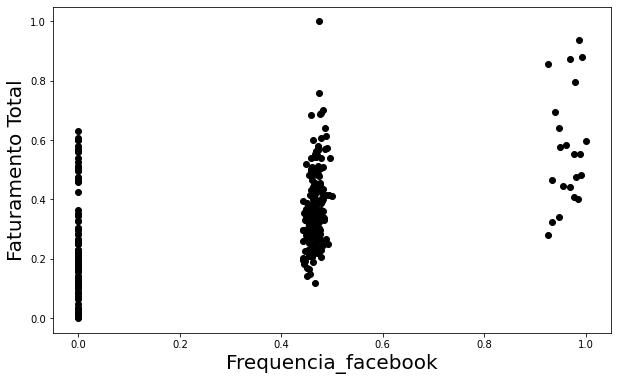

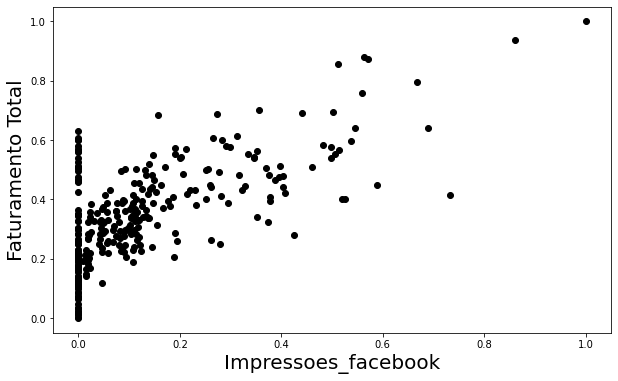

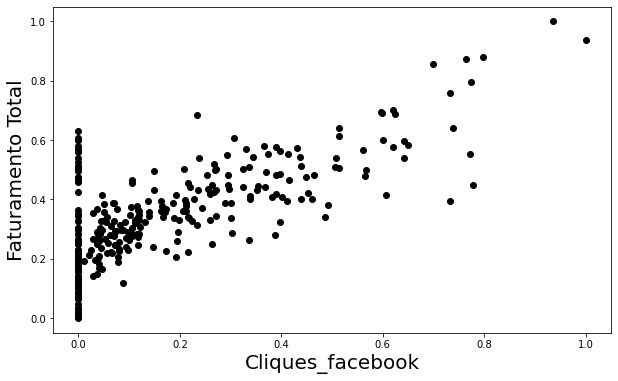

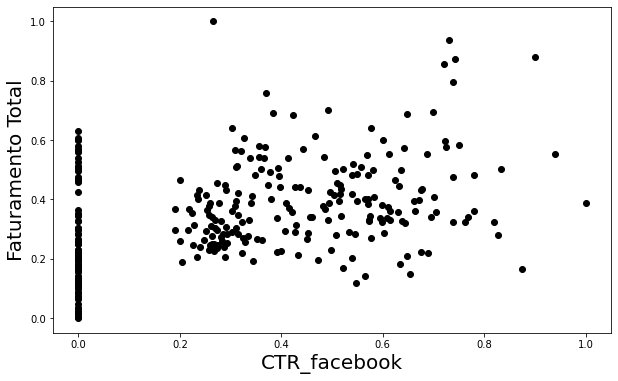

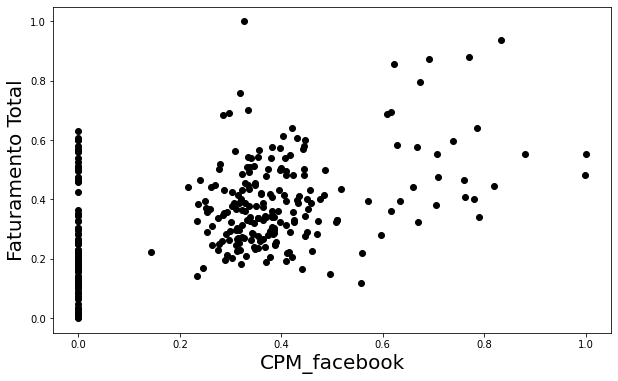

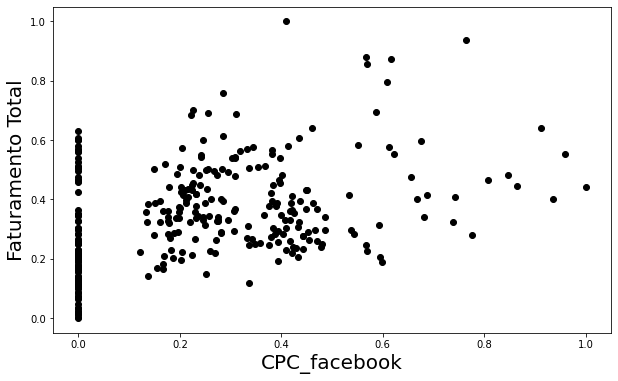

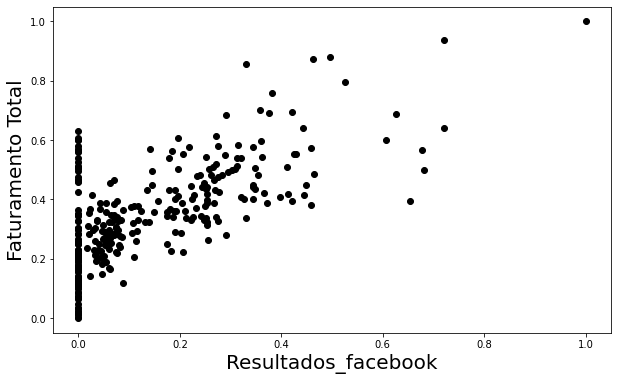

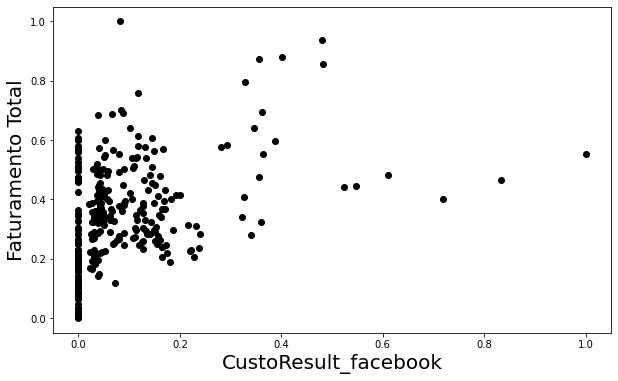

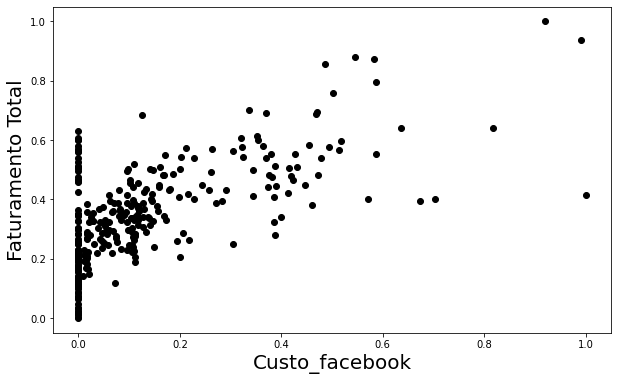

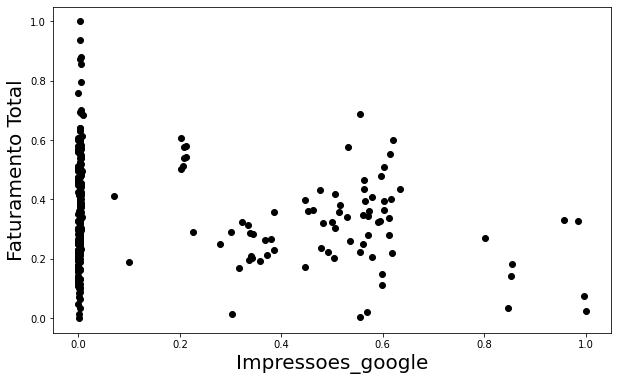

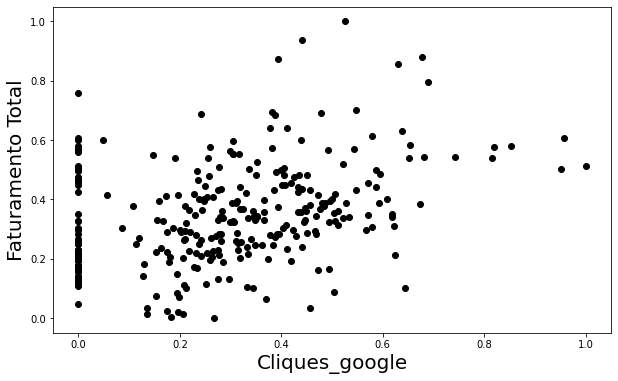

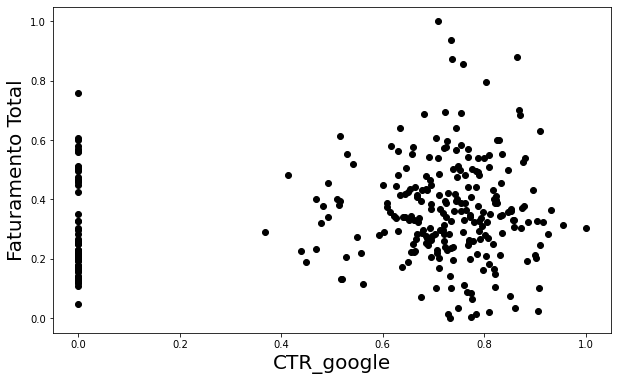

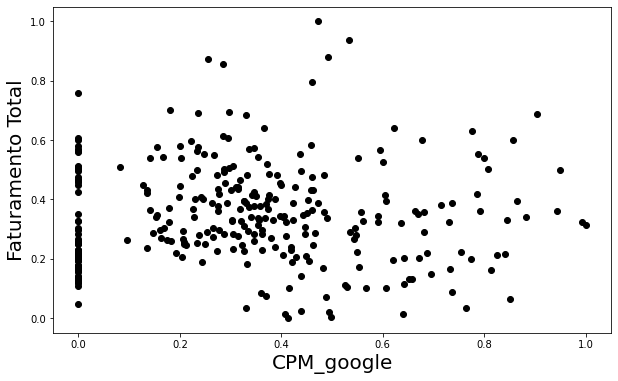

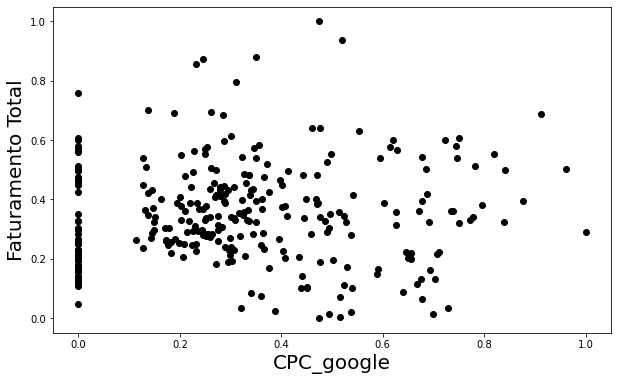

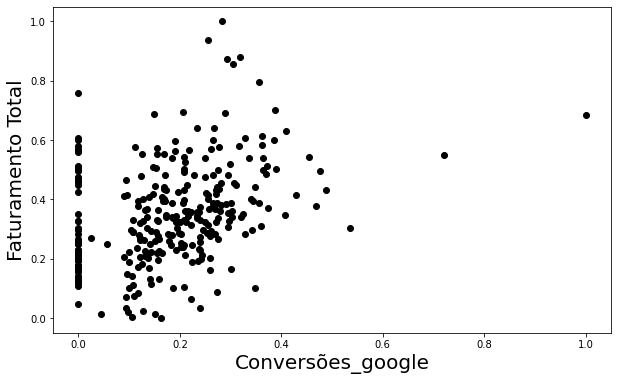

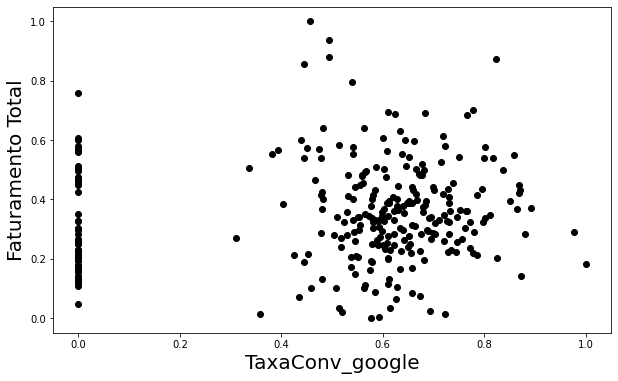

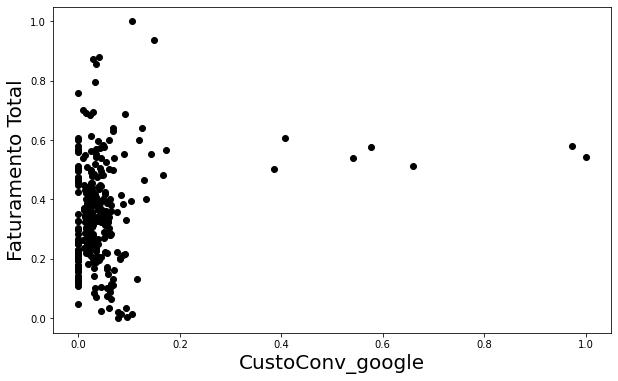

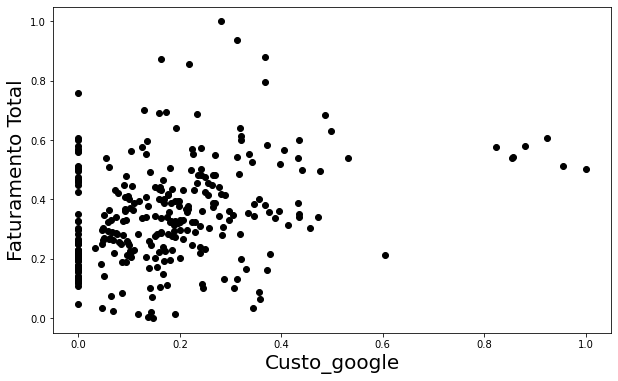

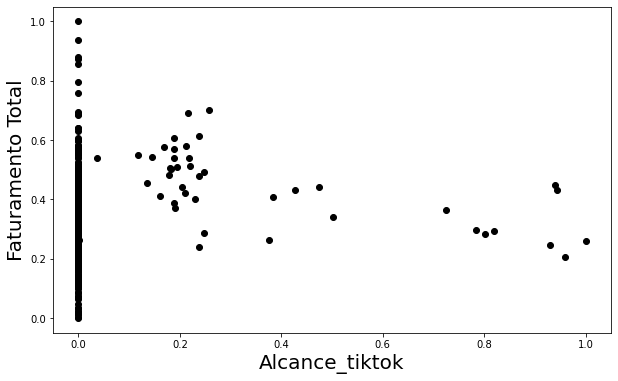

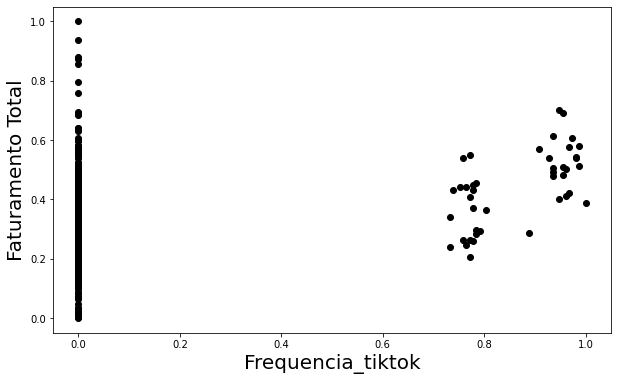

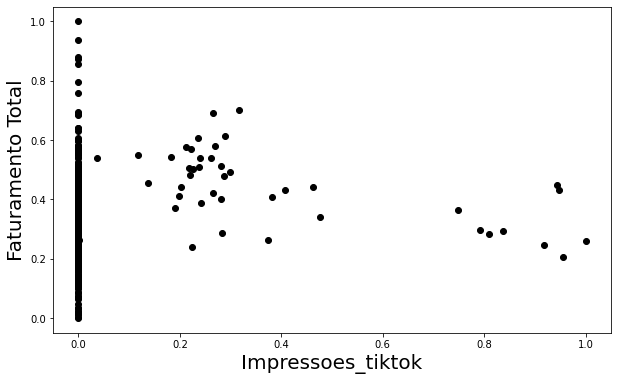

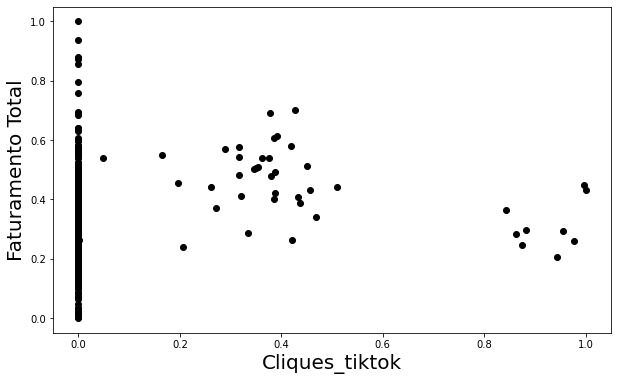

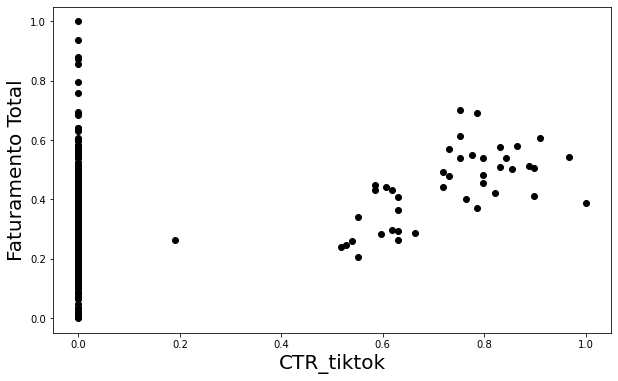

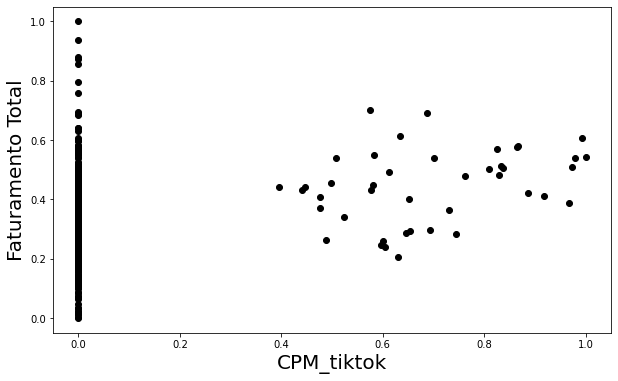

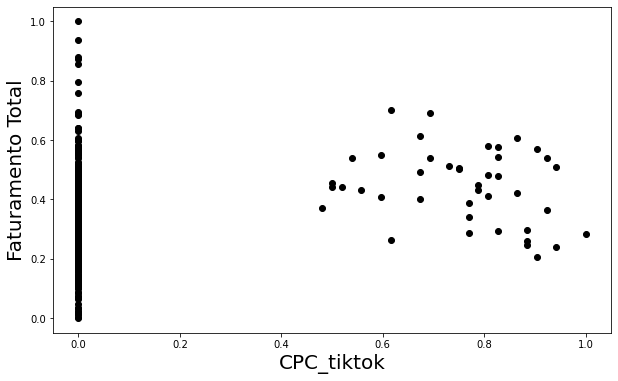

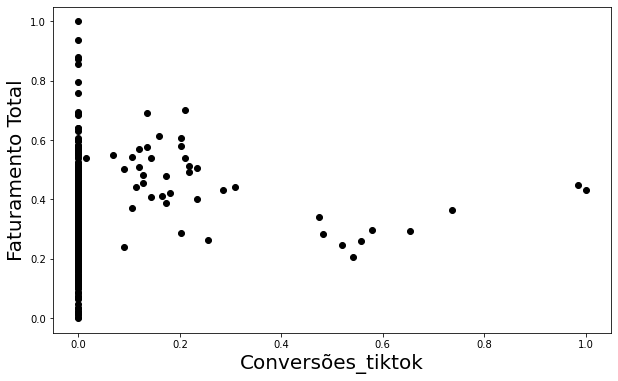

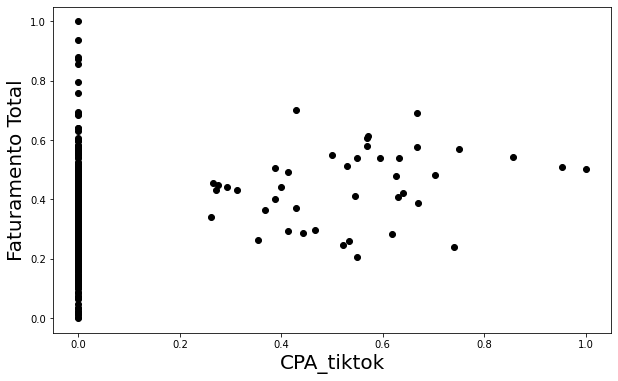

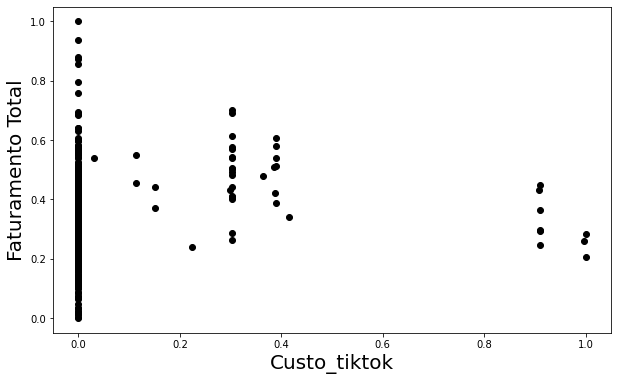

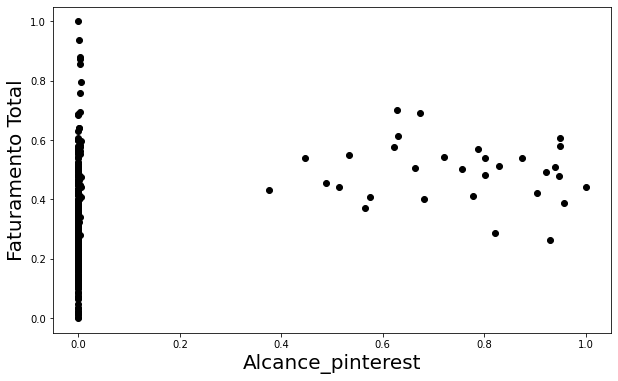

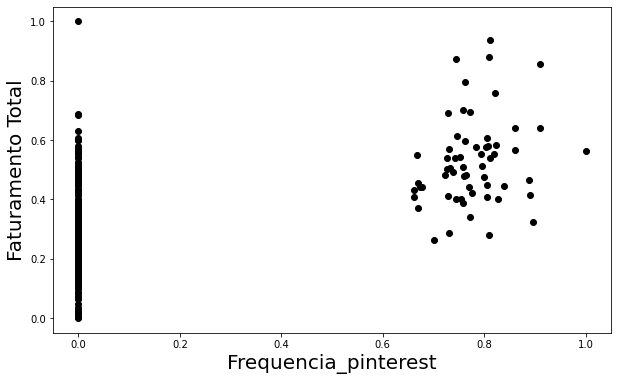

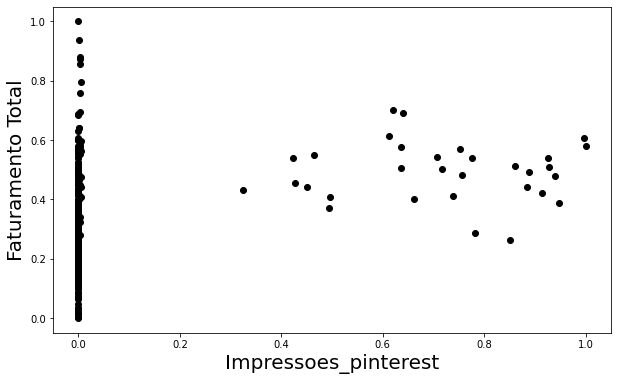

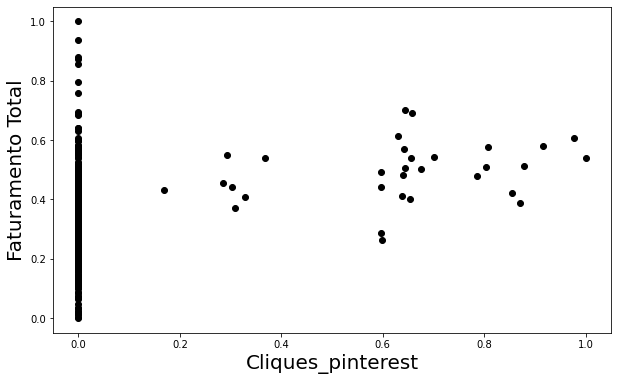

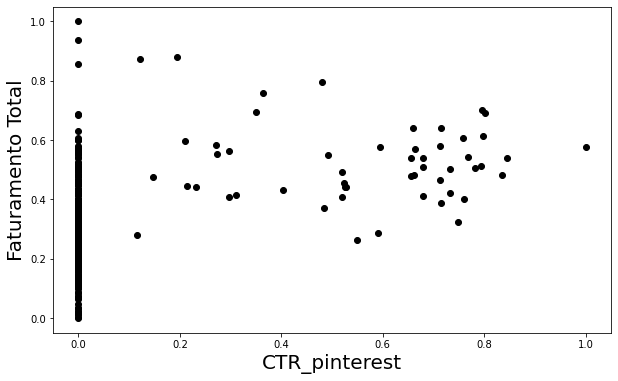

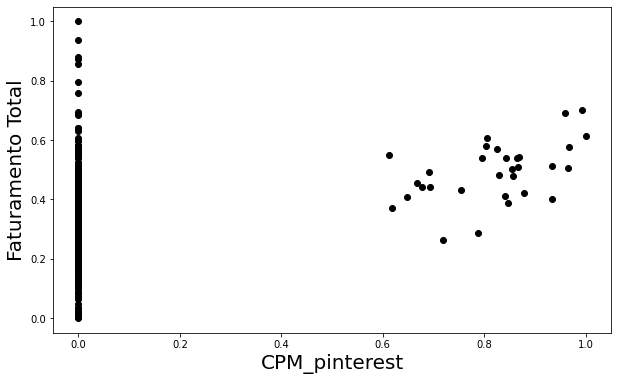

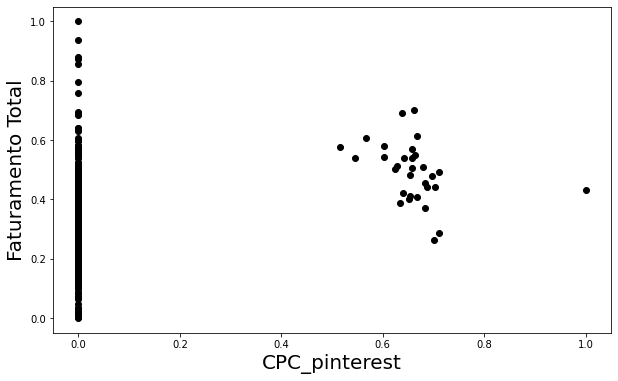

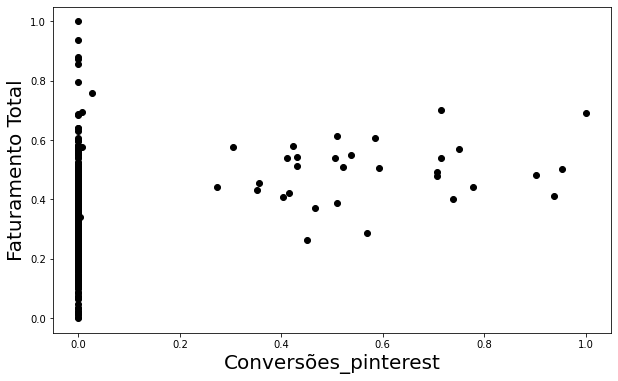

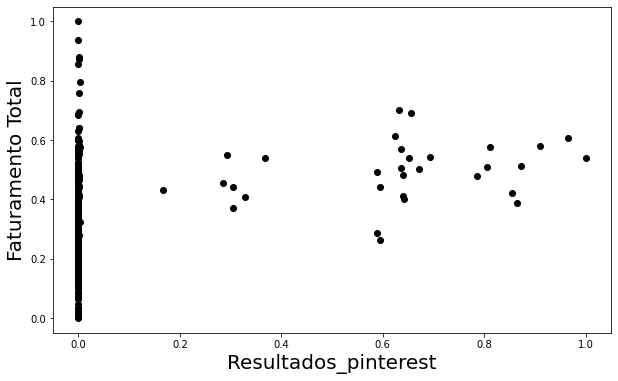

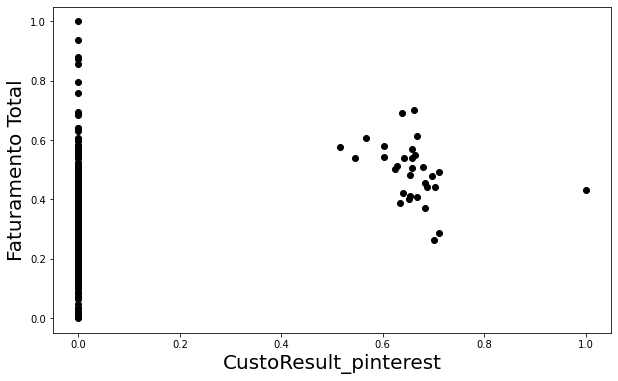

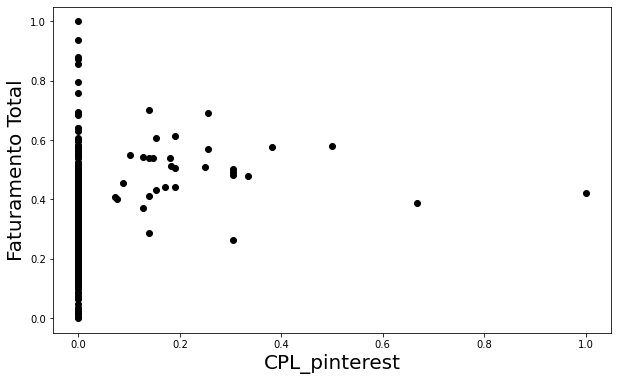

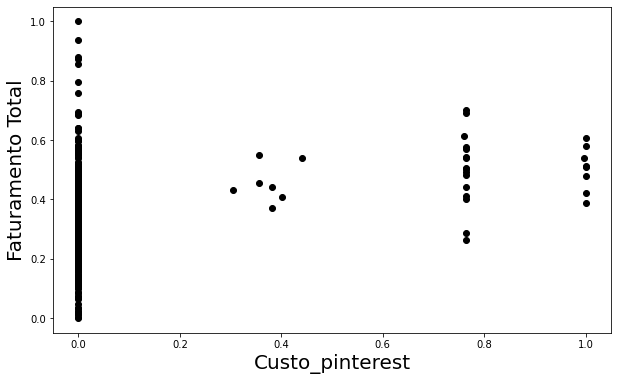

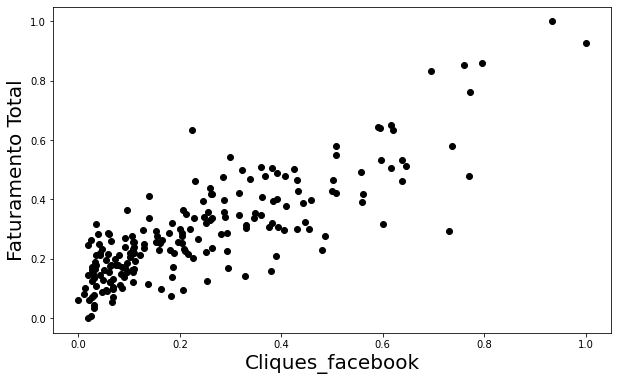

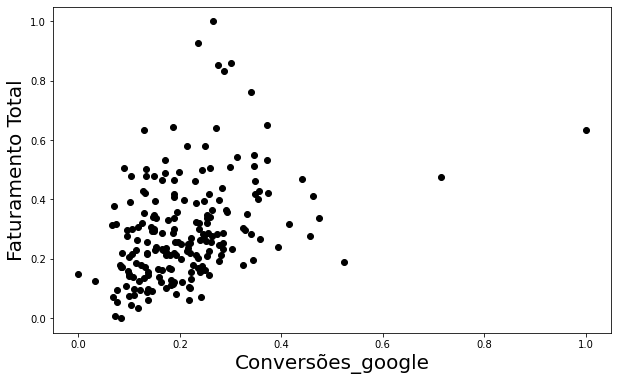

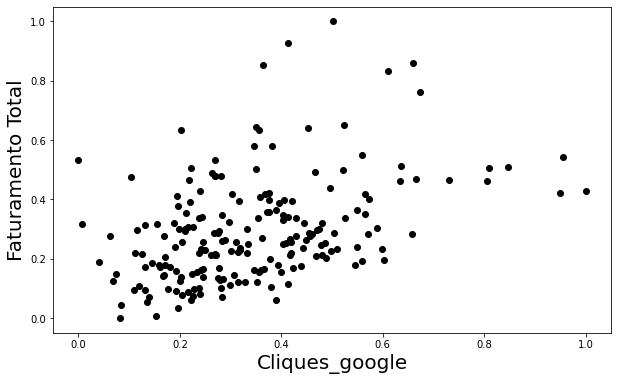

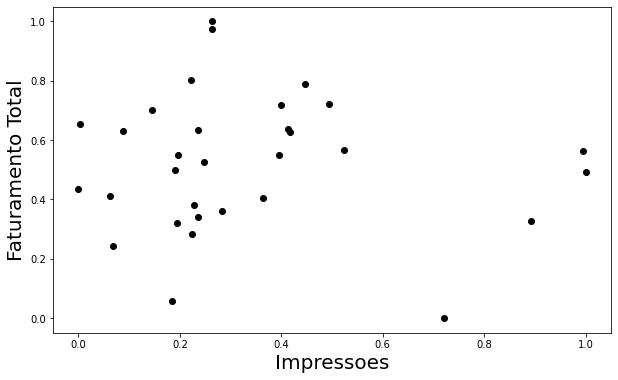

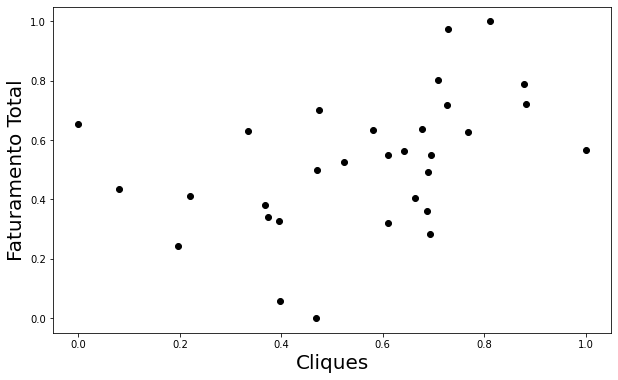

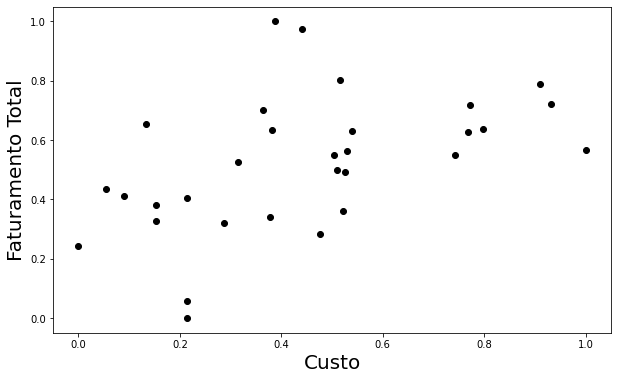

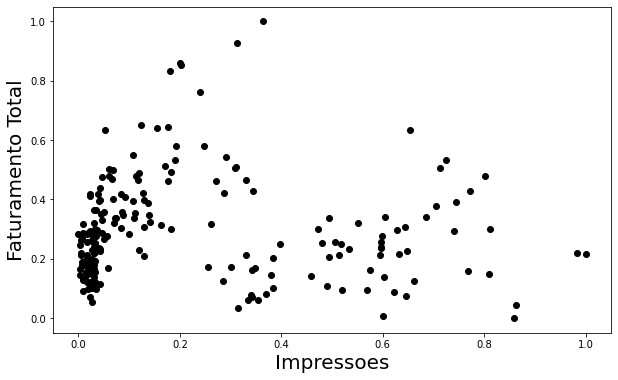

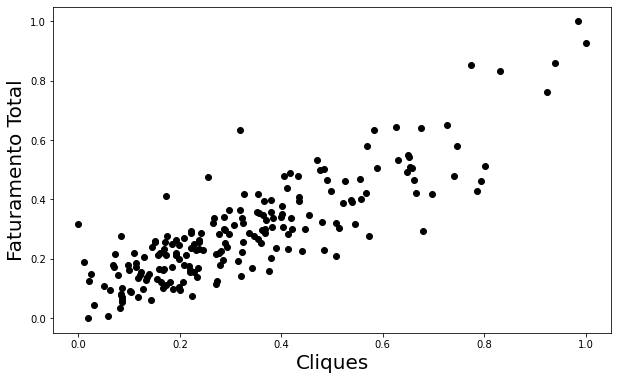

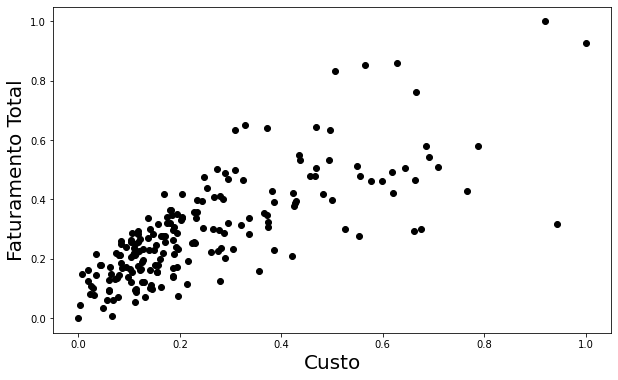

In [100]:
for i in dataModelos_norm:    
    plot_atributos(i)

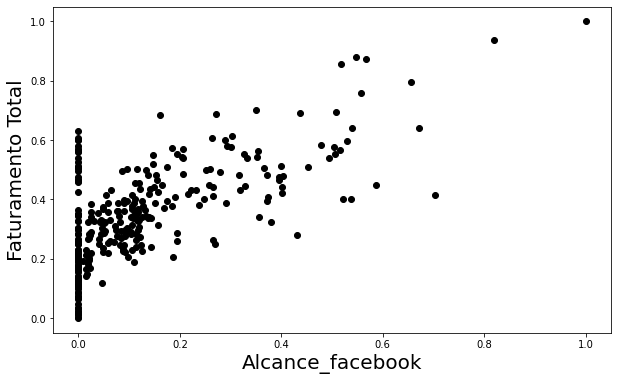

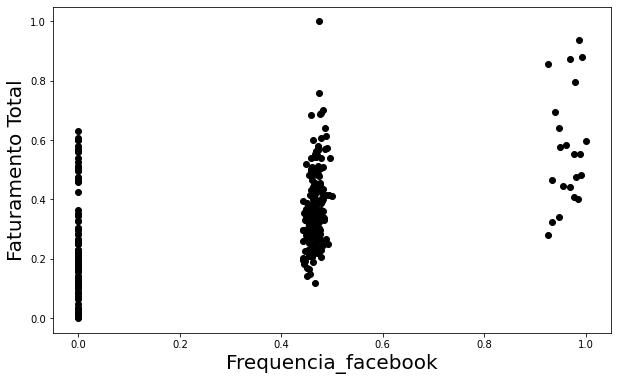

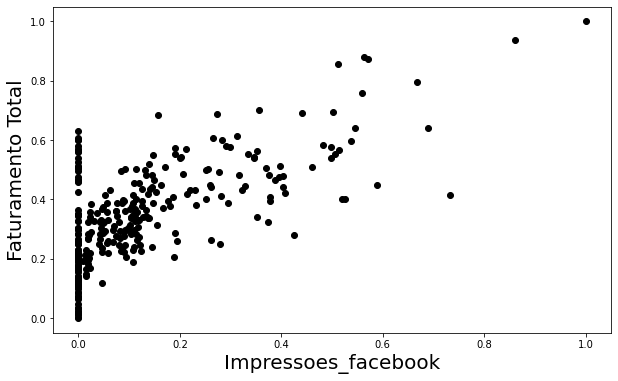

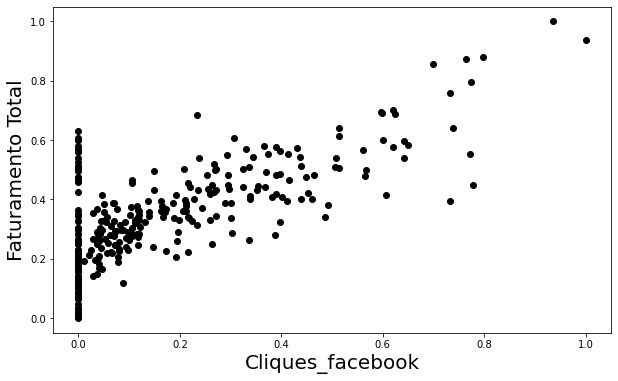

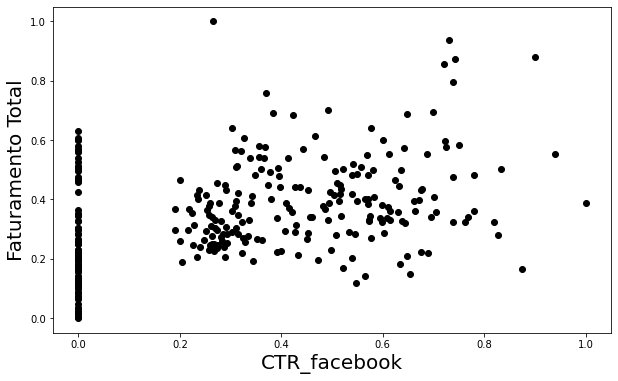

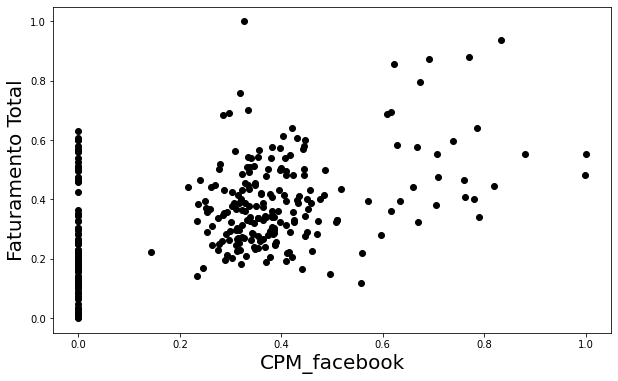

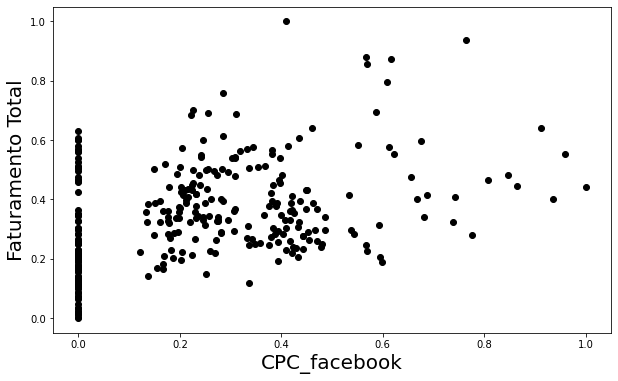

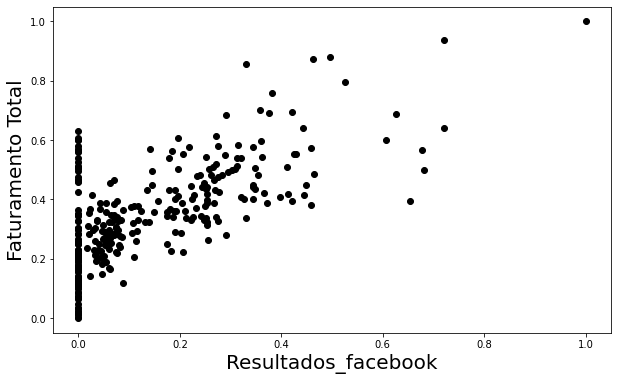

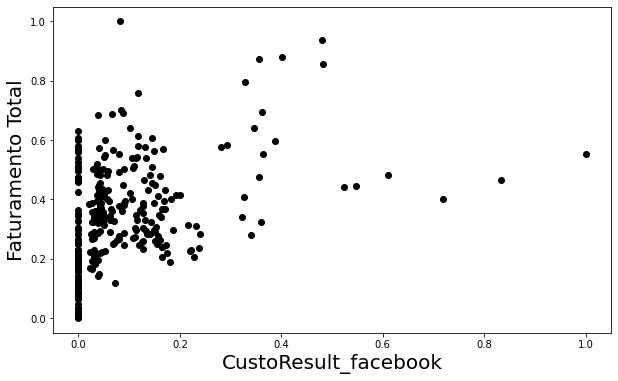

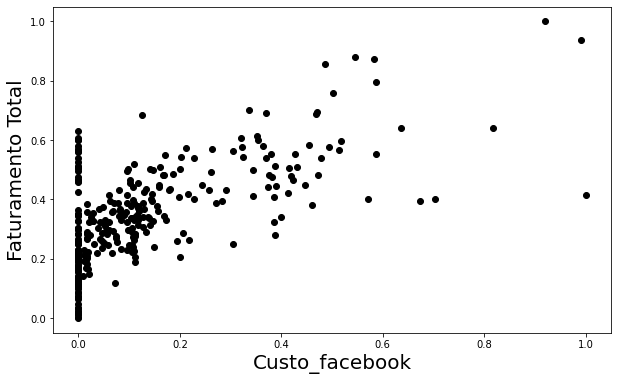

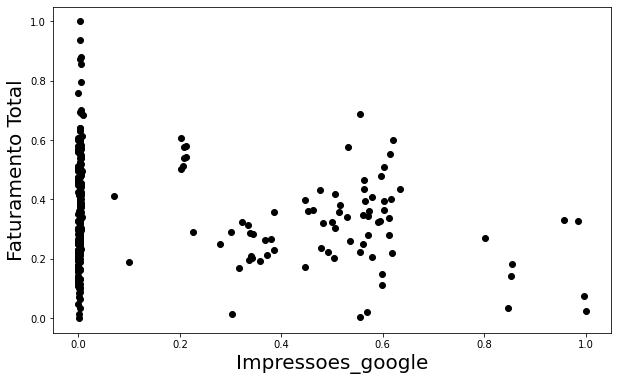

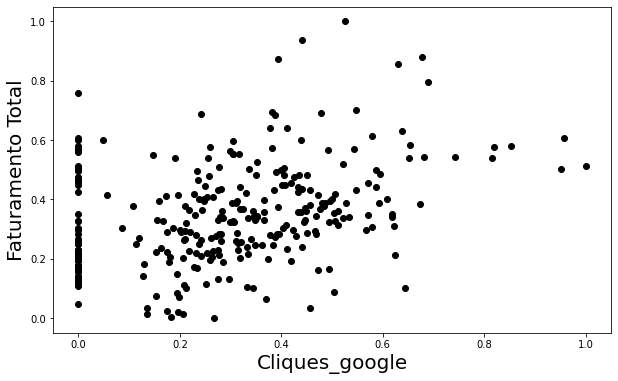

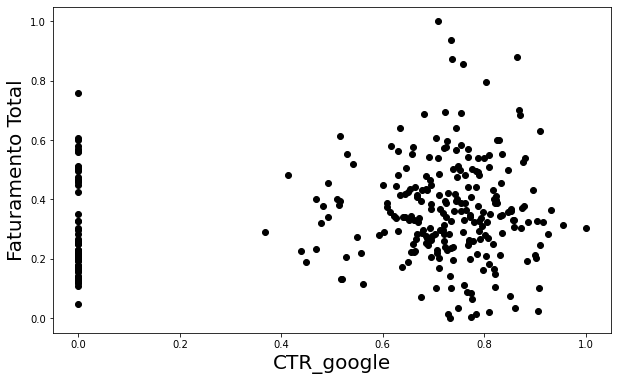

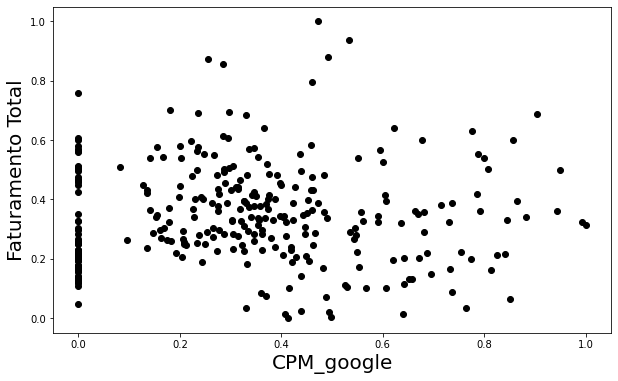

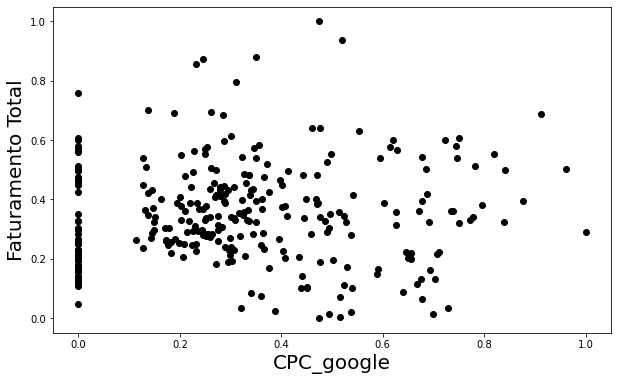

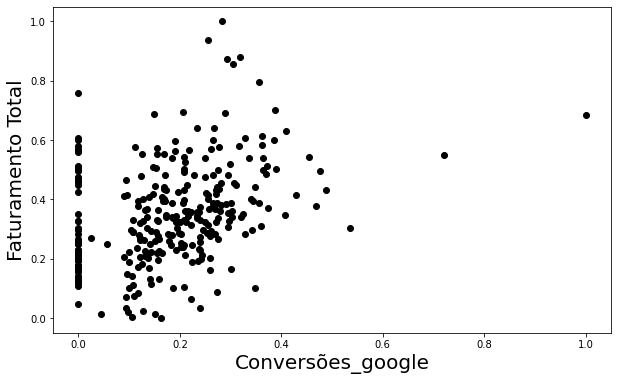

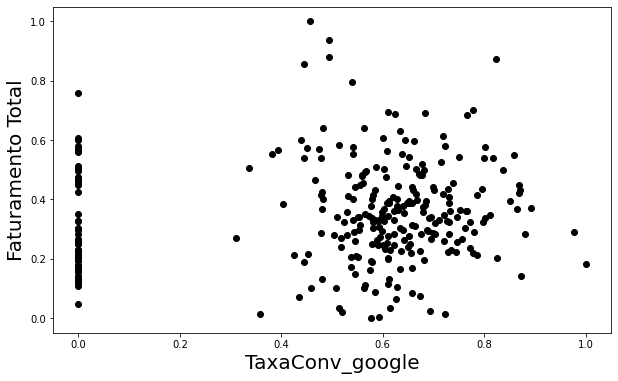

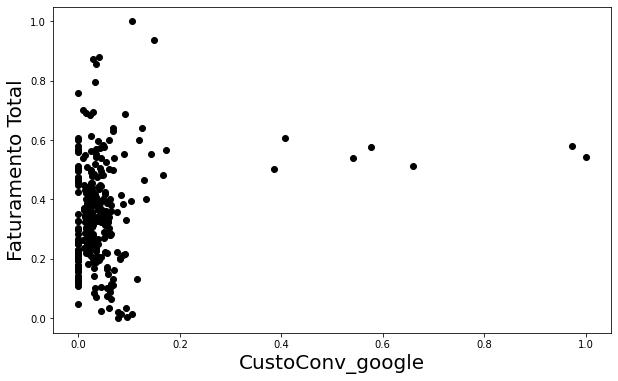

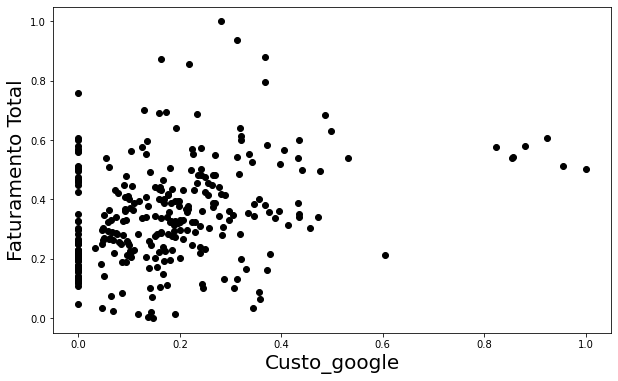

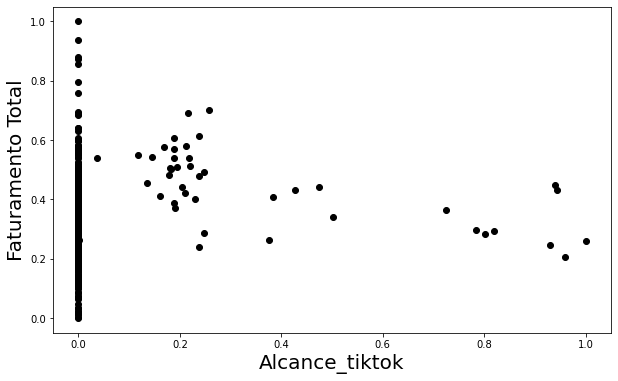

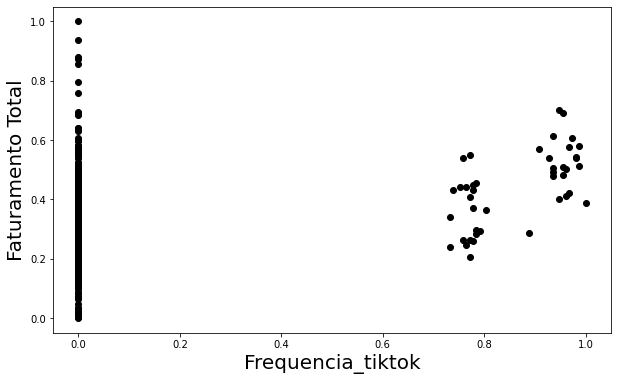

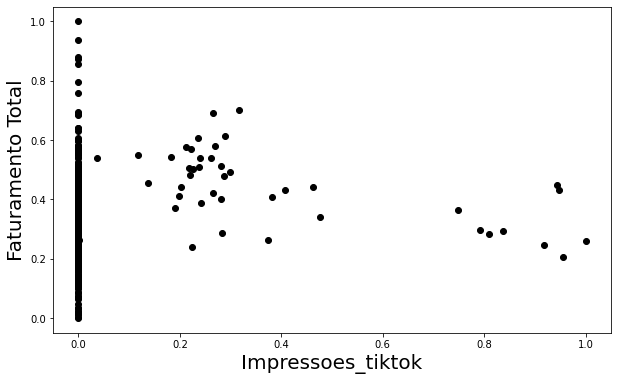

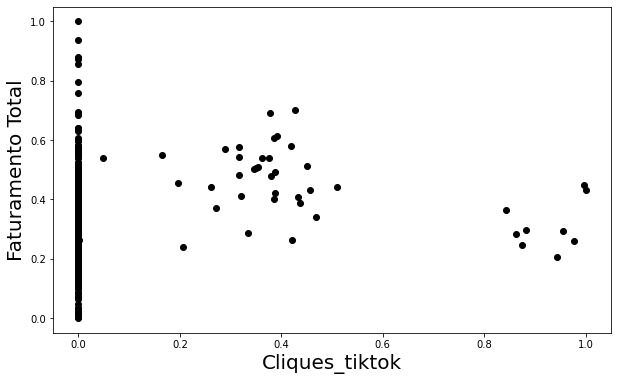

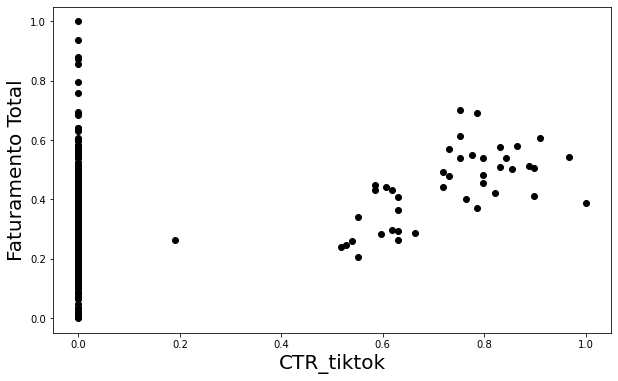

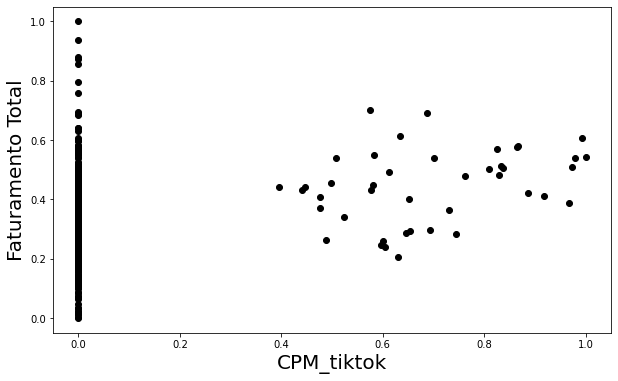

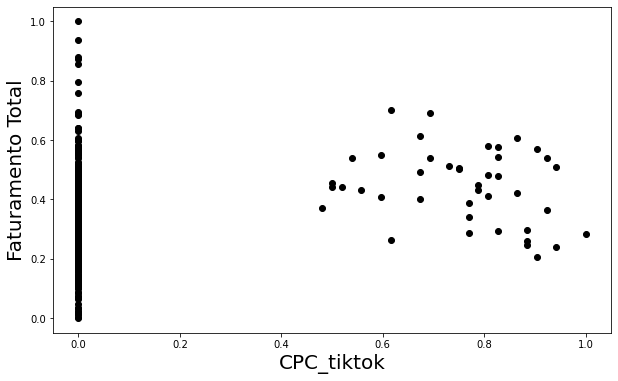

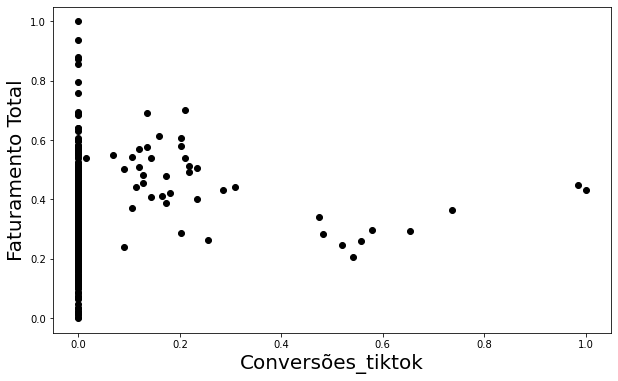

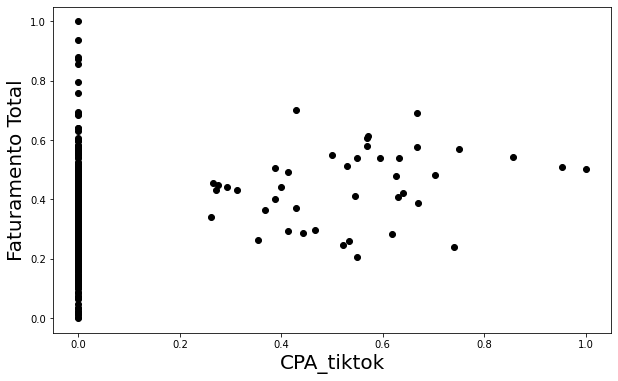

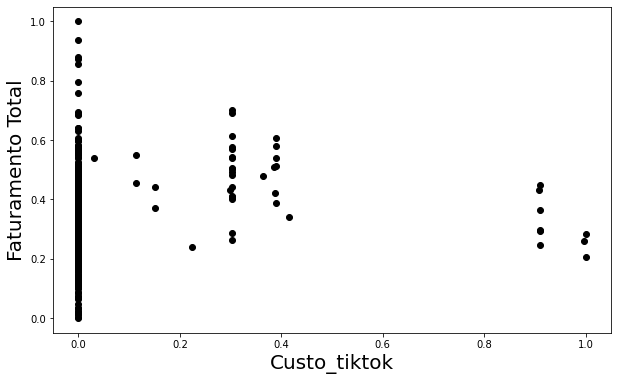

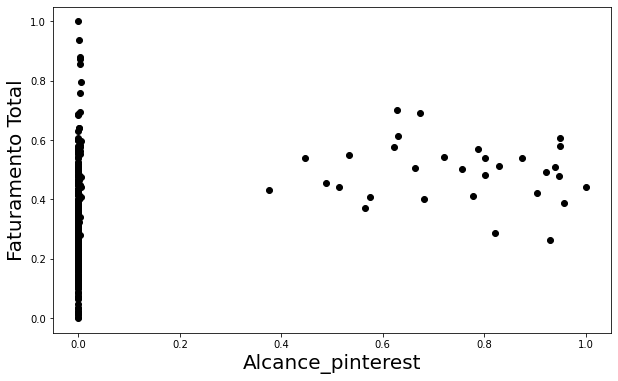

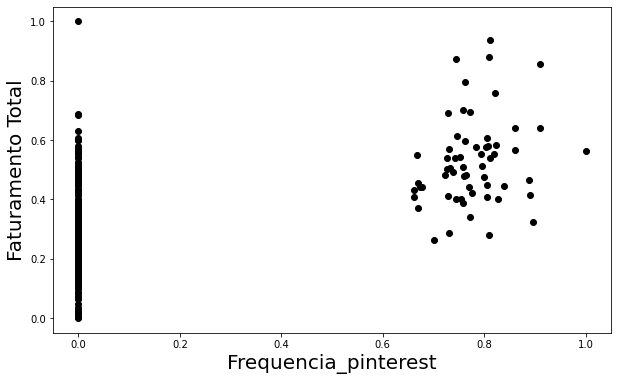

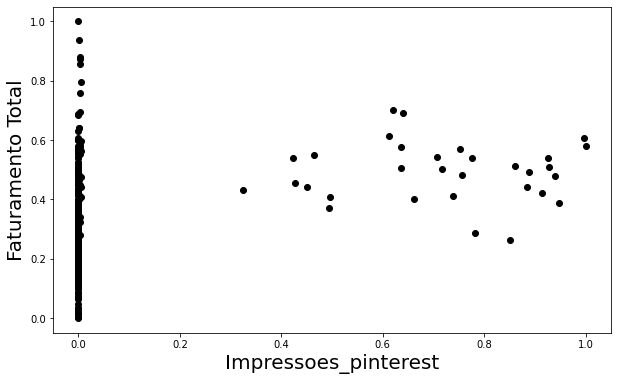

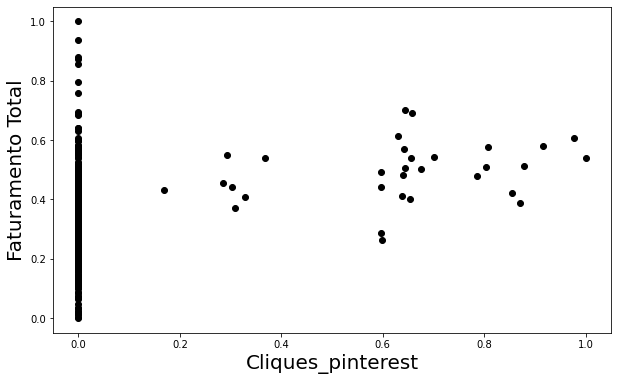

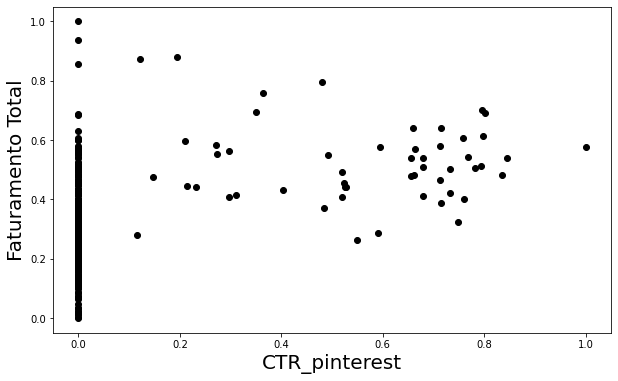

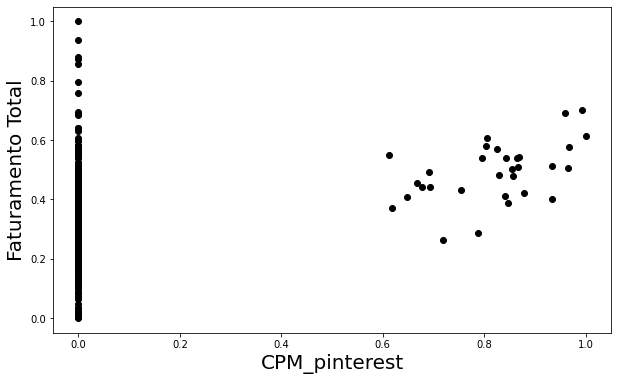

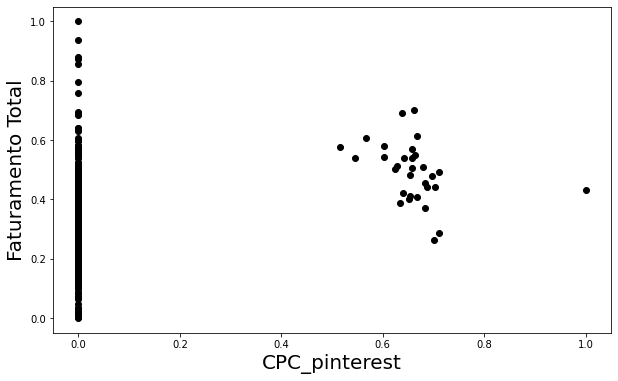

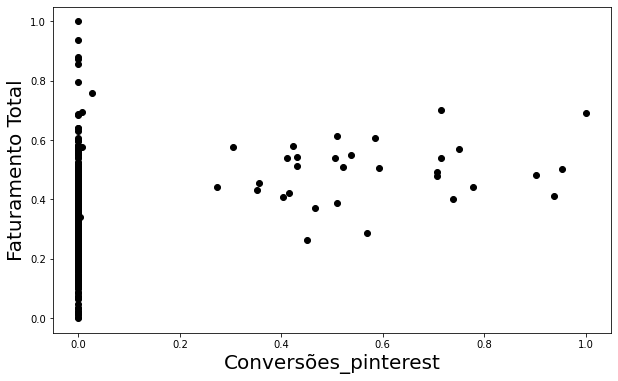

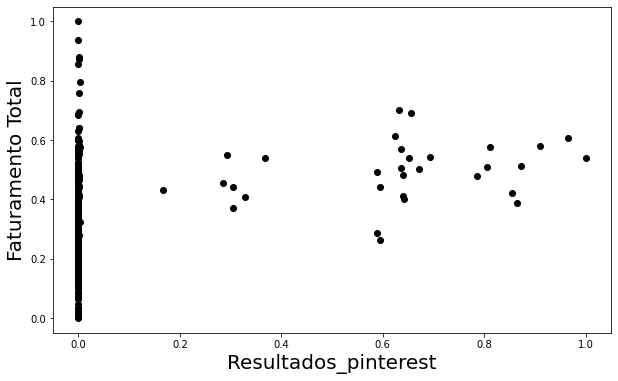

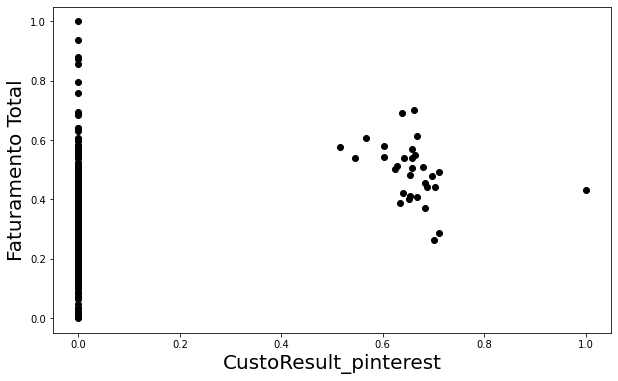

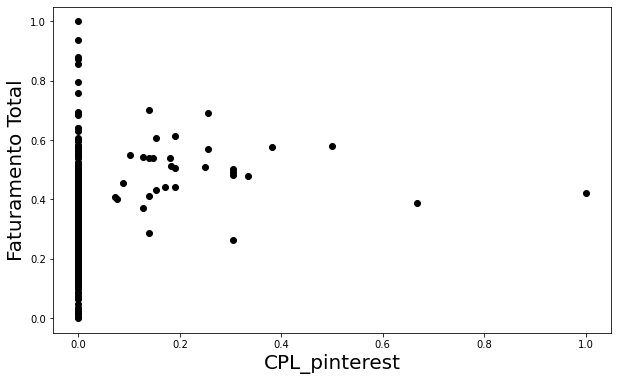

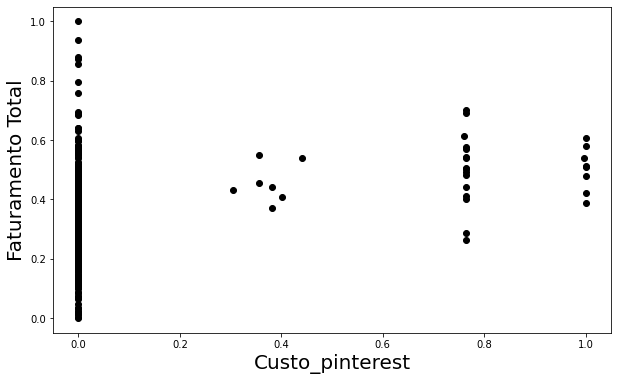

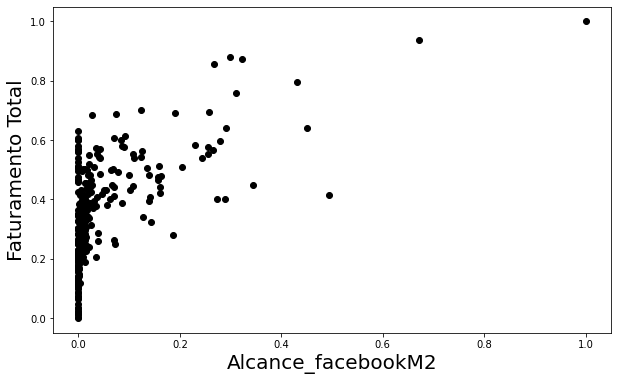

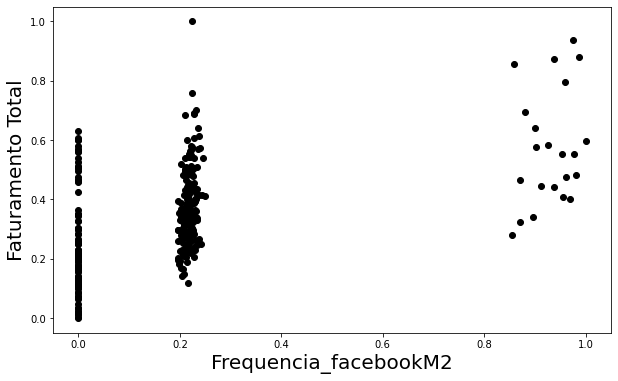

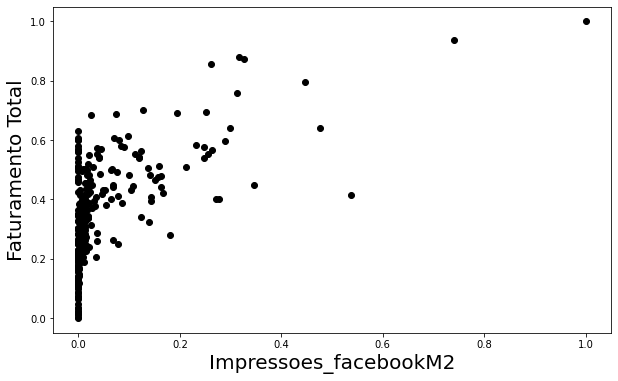

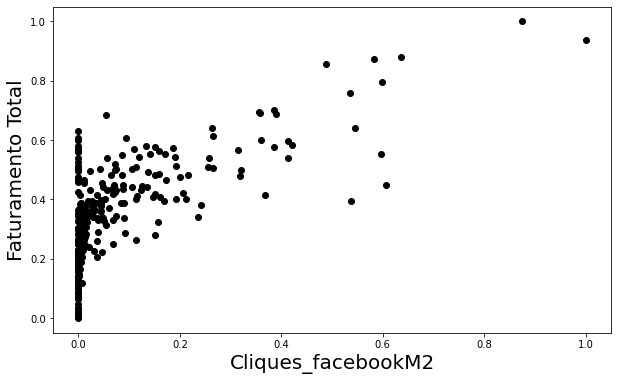

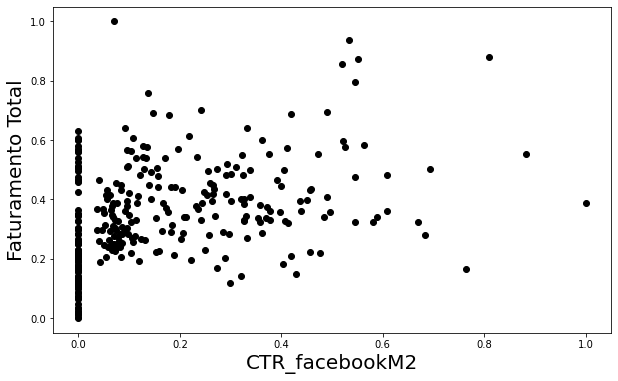

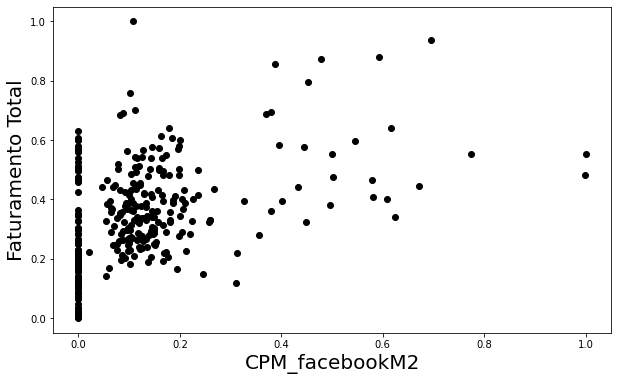

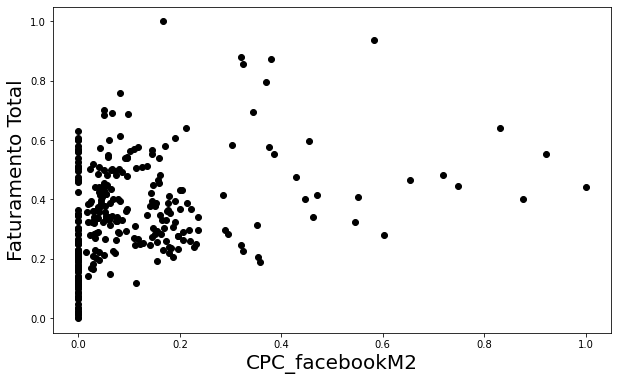

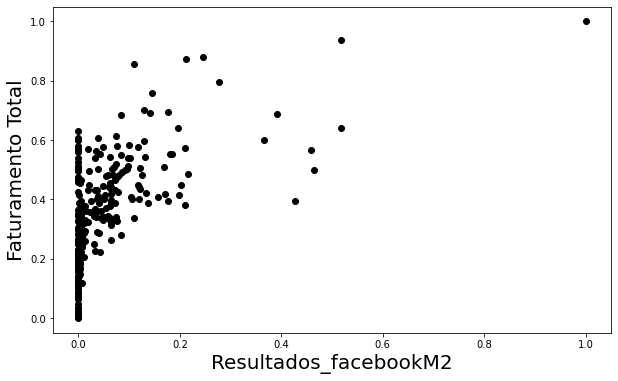

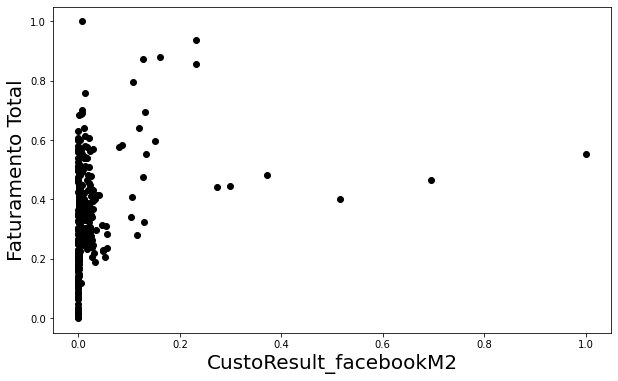

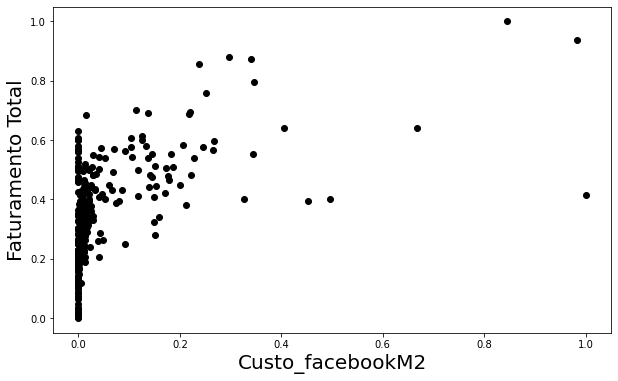

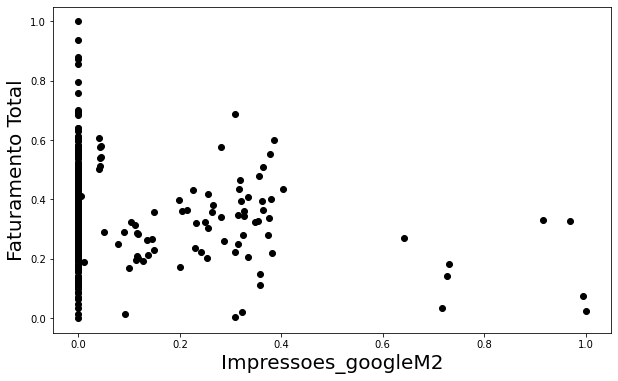

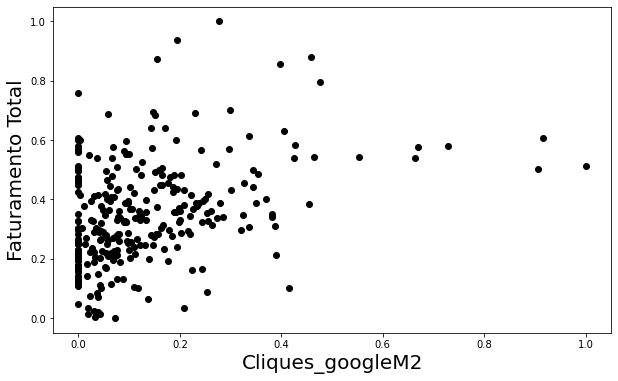

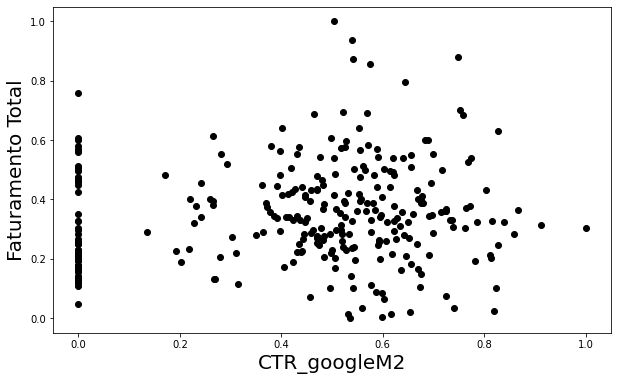

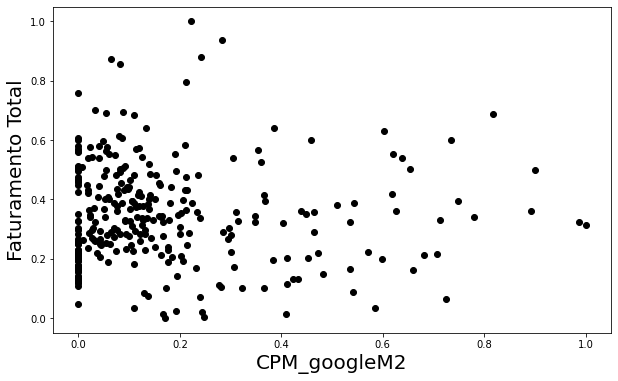

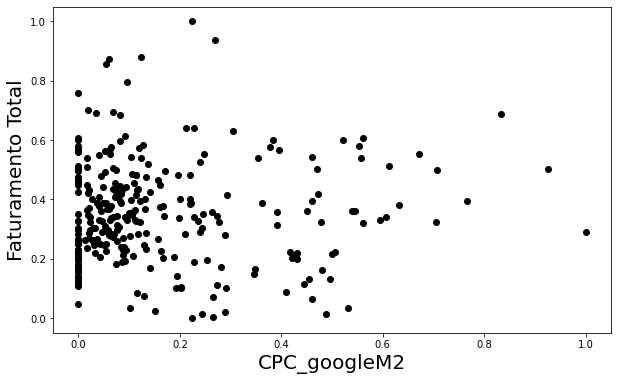

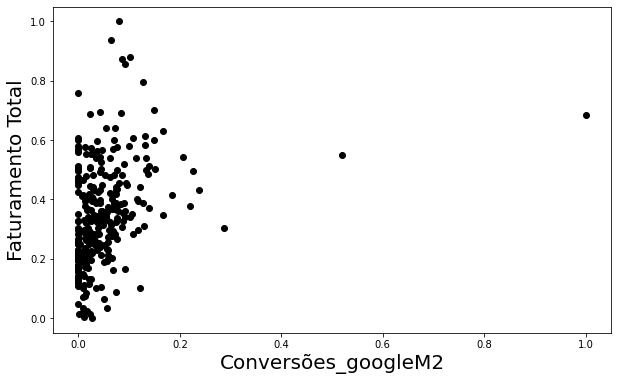

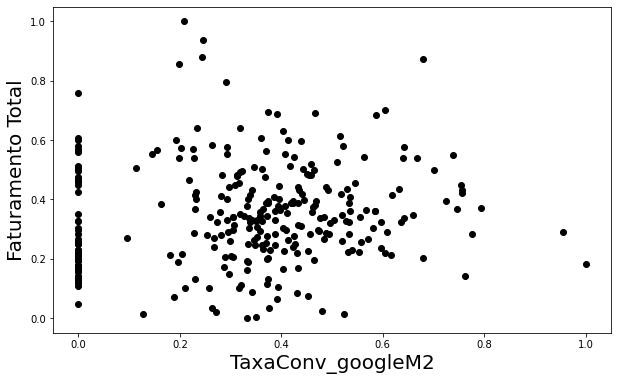

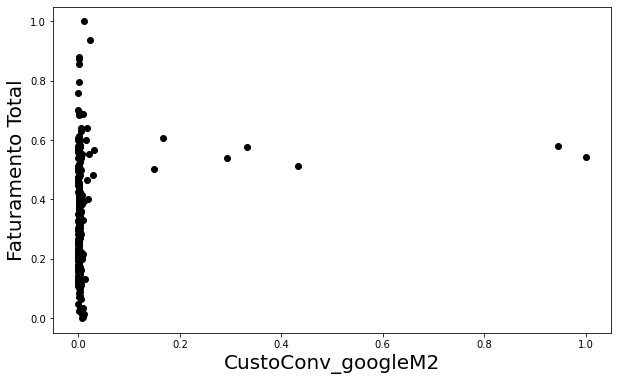

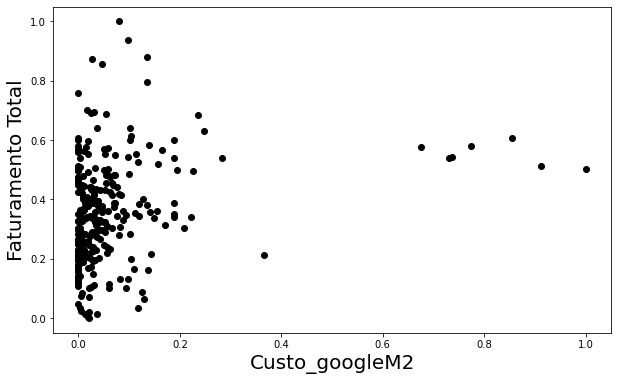

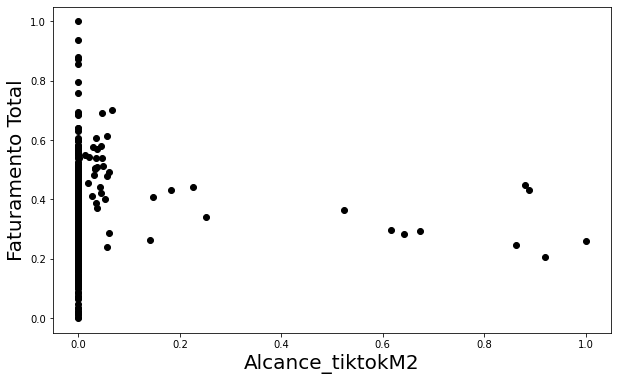

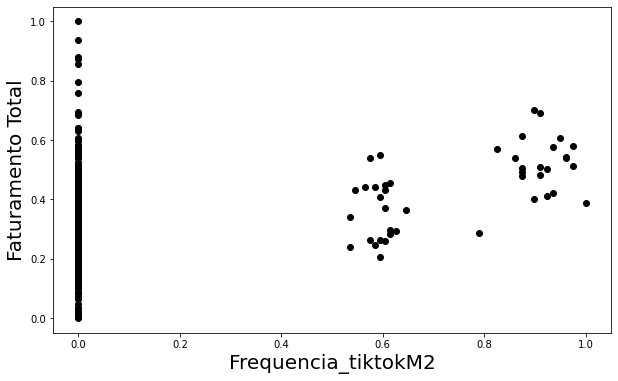

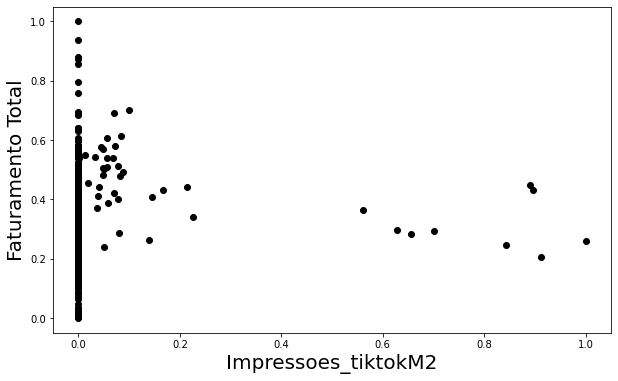

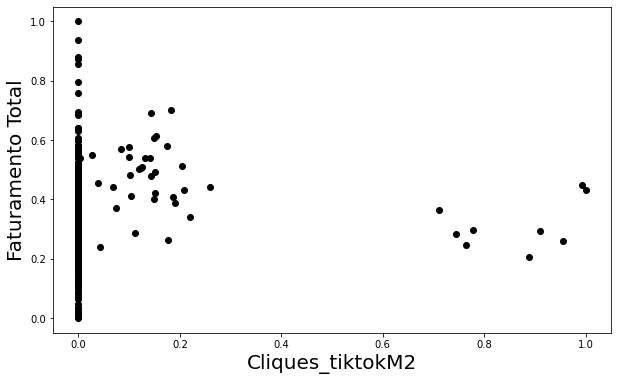

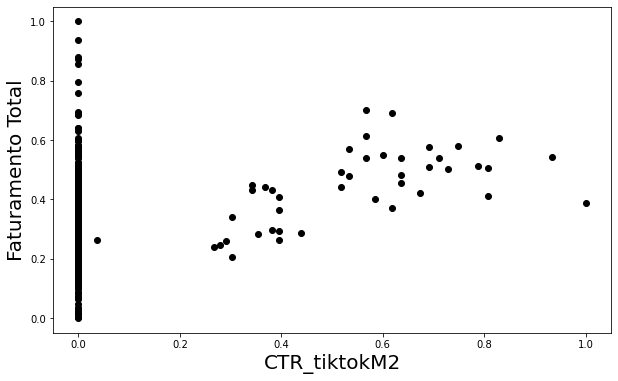

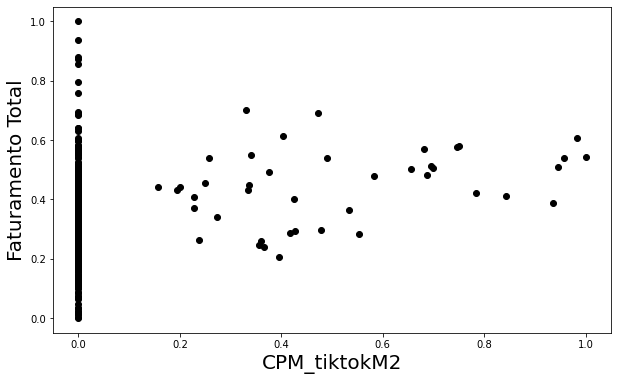

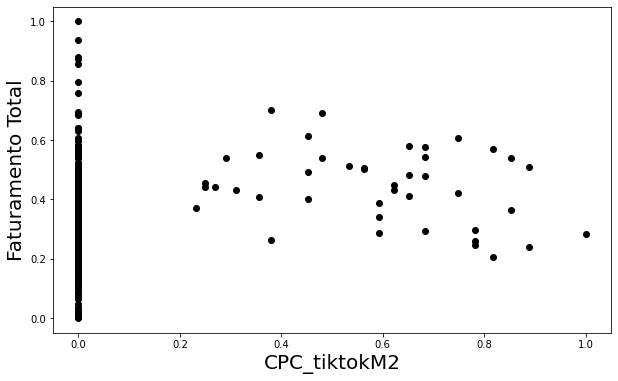

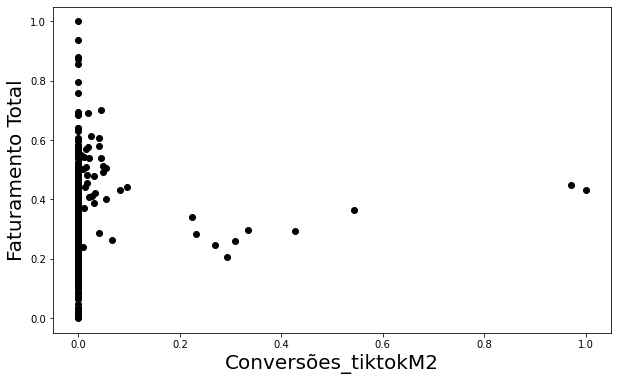

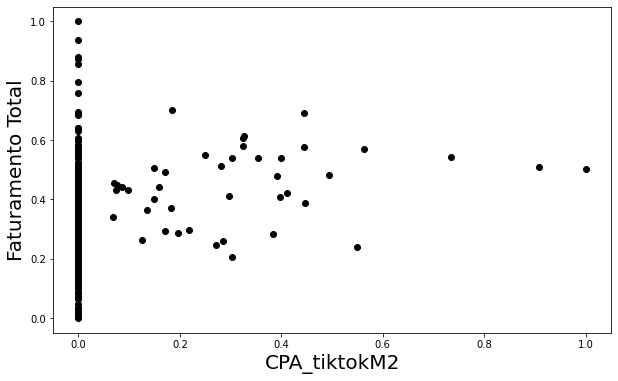

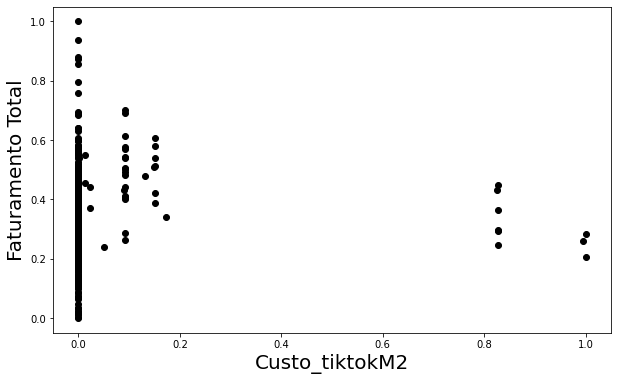

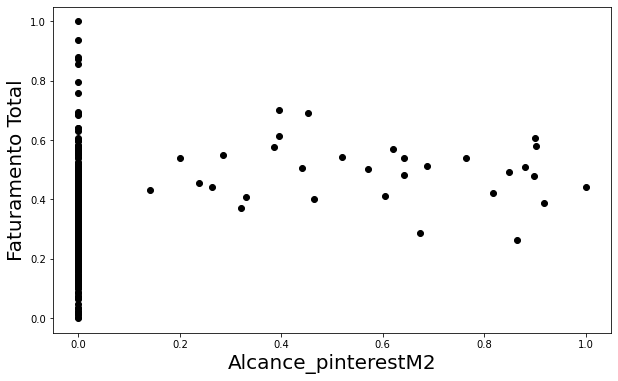

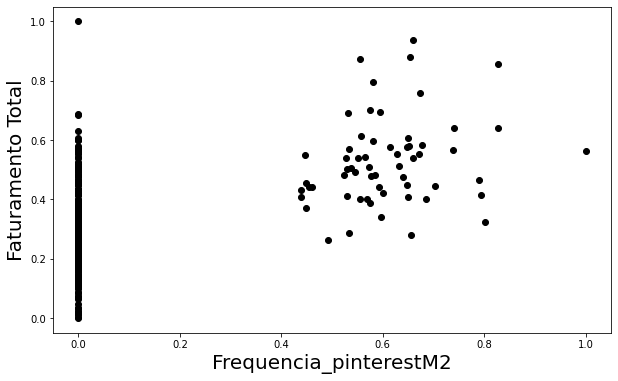

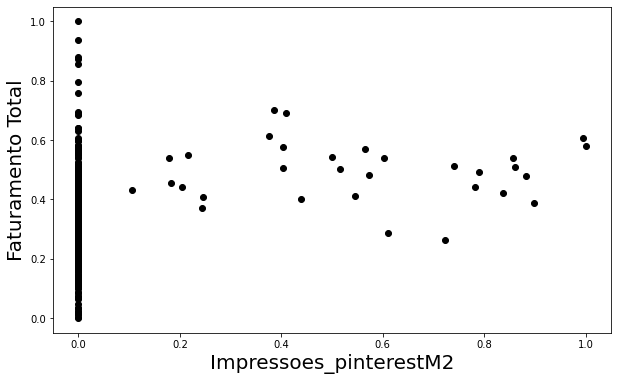

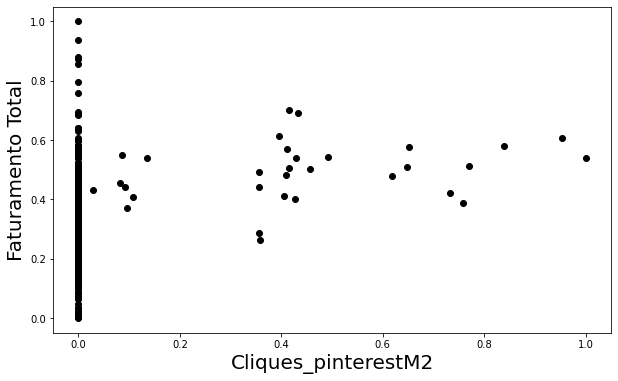

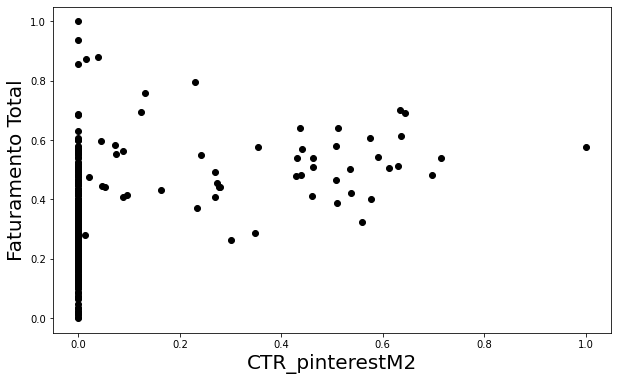

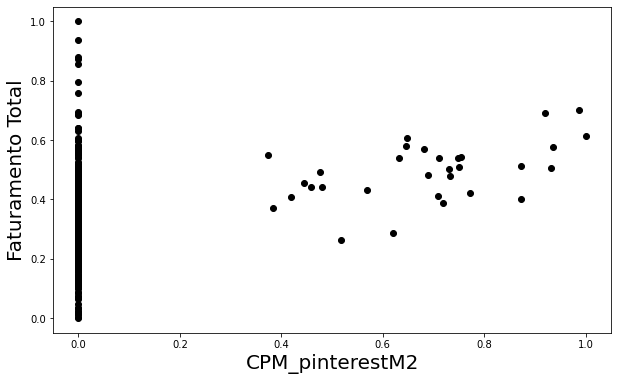

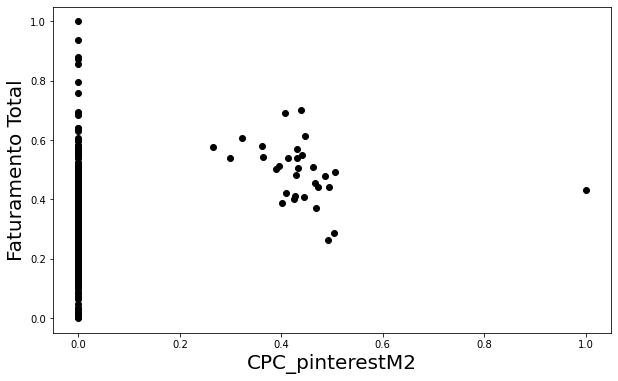

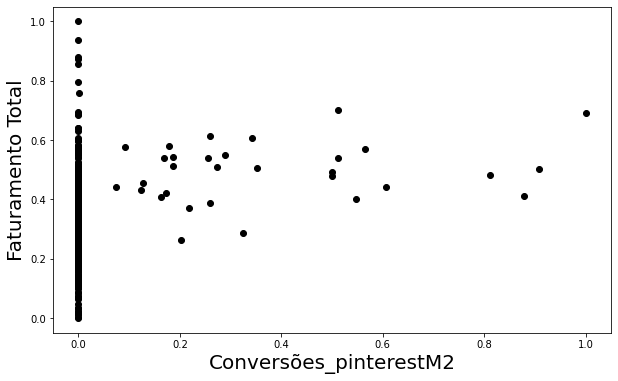

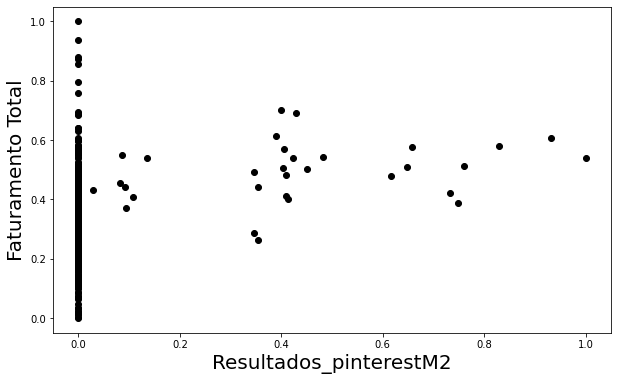

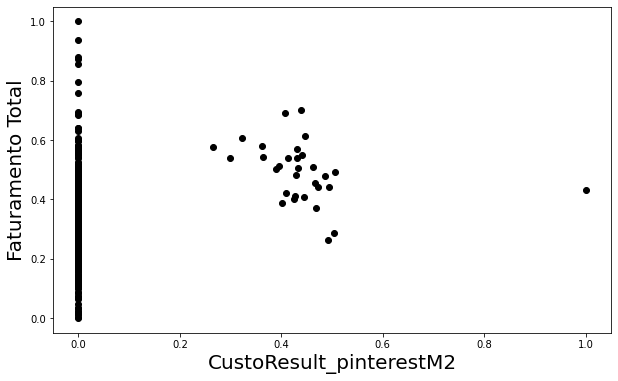

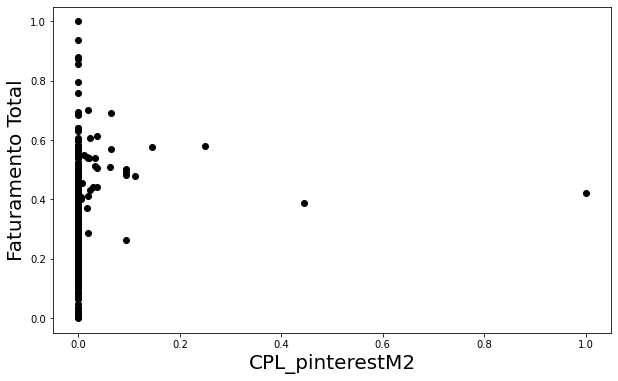

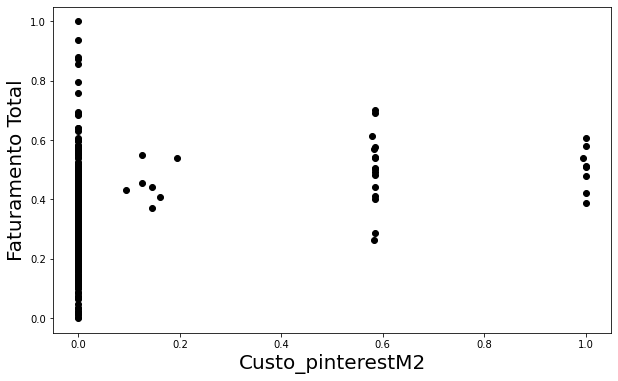

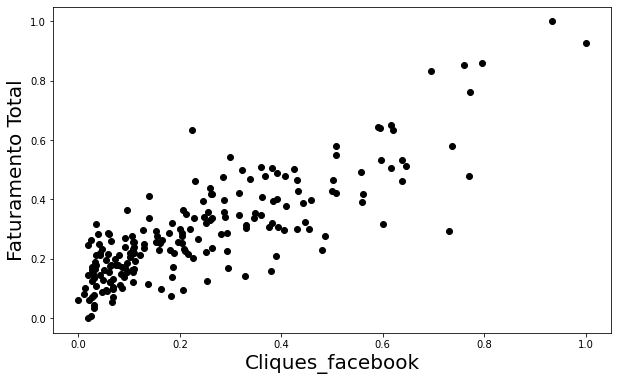

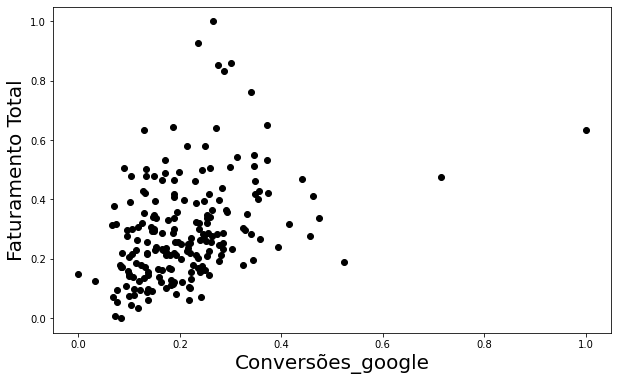

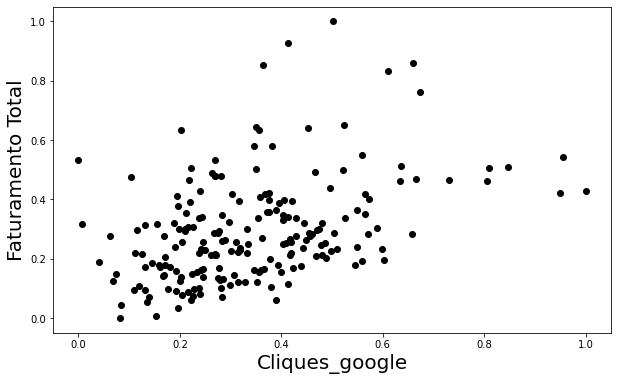

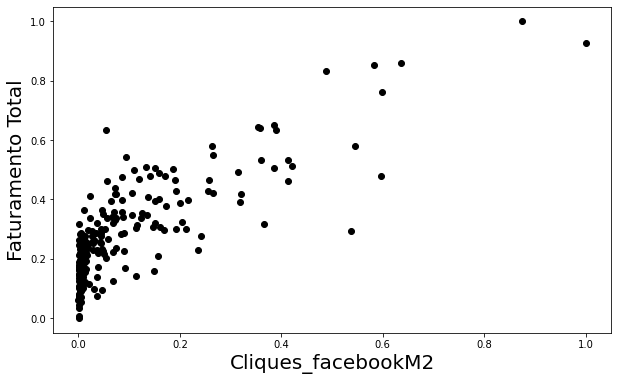

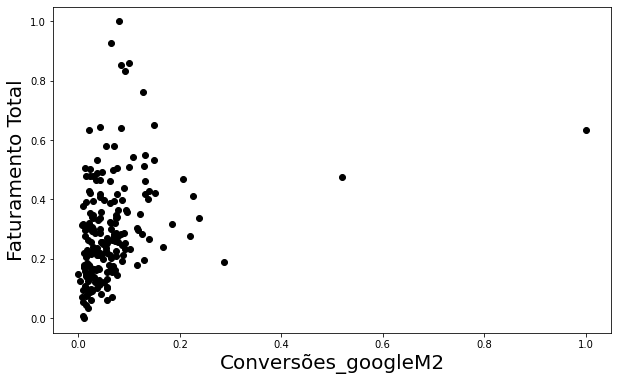

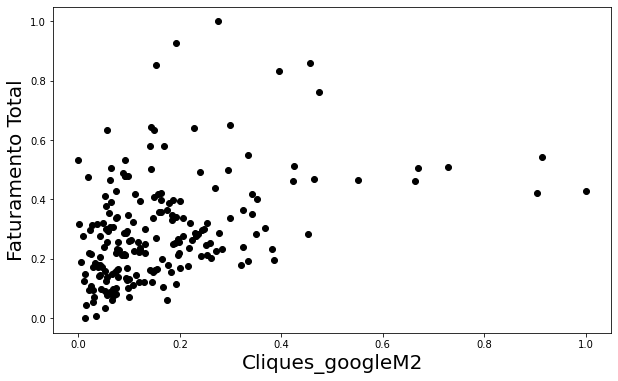

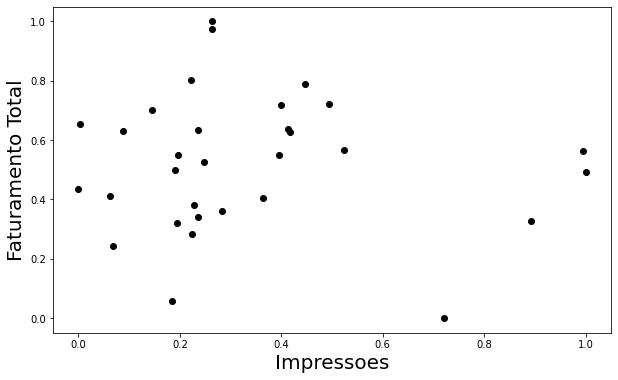

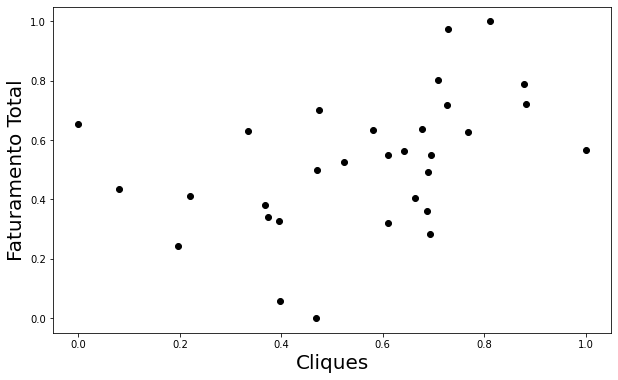

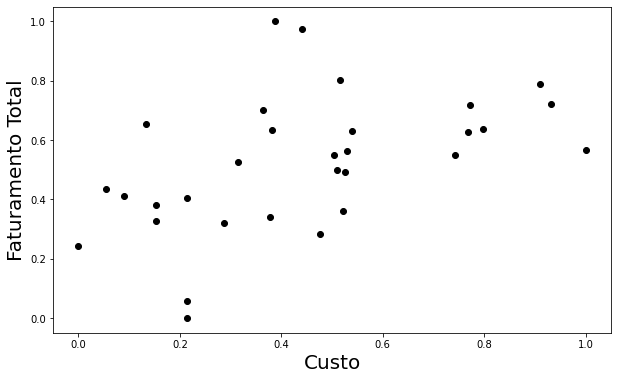

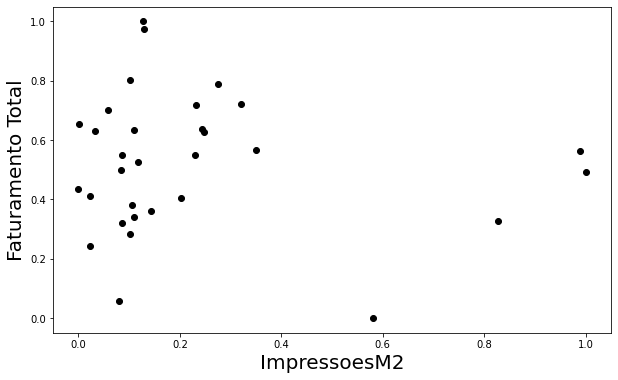

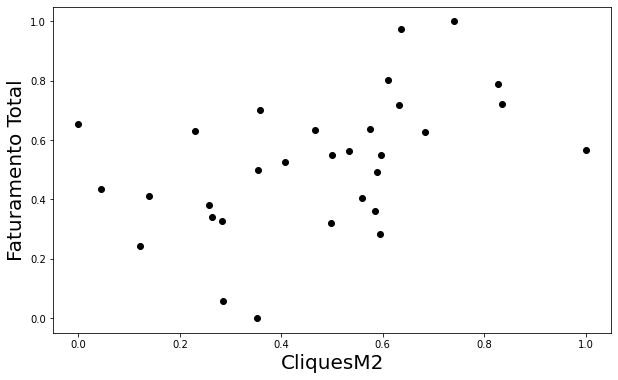

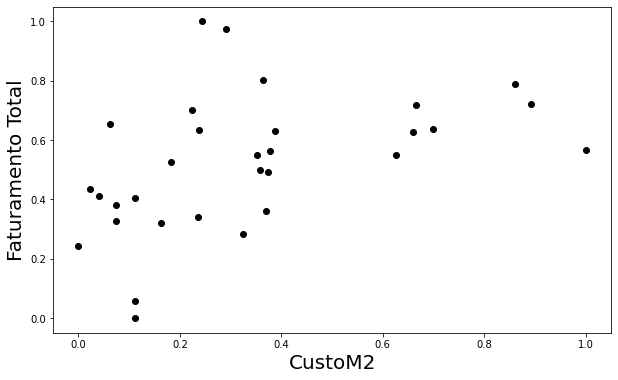

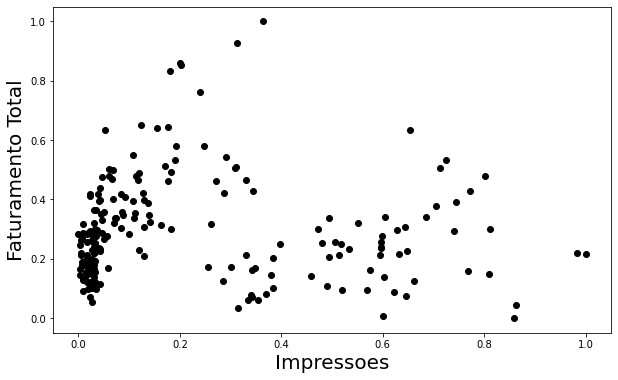

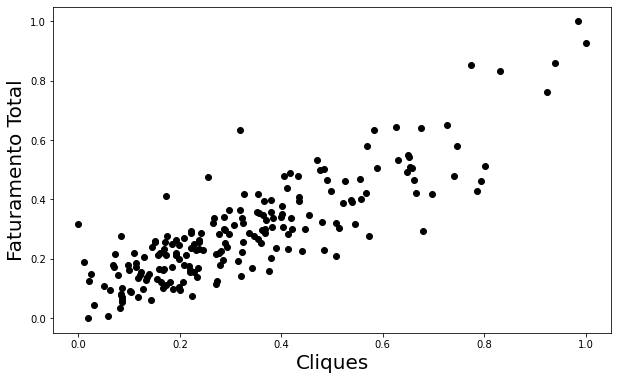

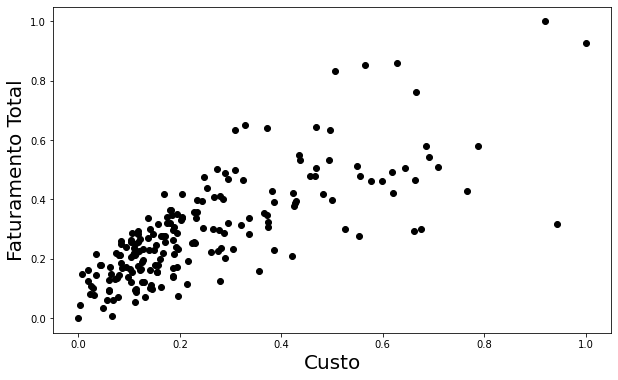

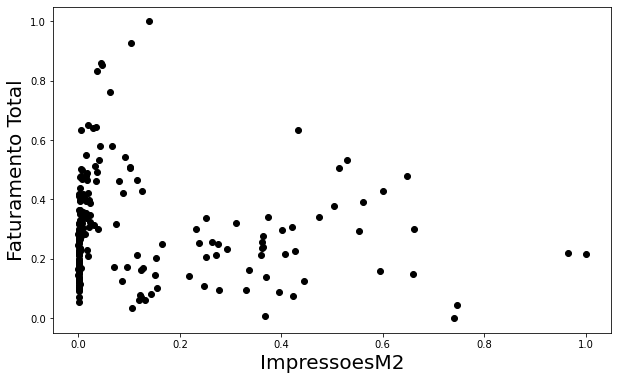

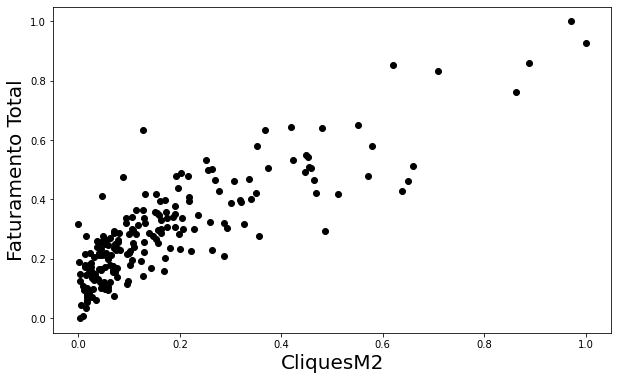

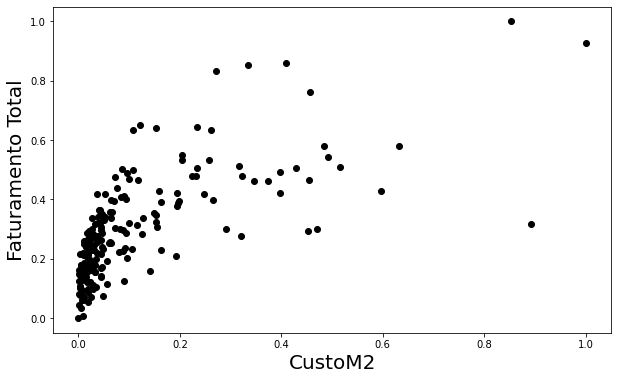

In [101]:
for i in dataModelos_M2:    
    plot_atributos(i)

## Modelo de regressão

## Teoria :Regressão linear múltipla

O modelo de regressão linear multivariado é definido por:<br>
$$
Y_j=\beta_0 + \beta_1 X_{1j} + \beta_2 X_{2j} + \beta_3 X_{3j}+\beta_4 X_{4j} + \epsilon_j.
$$
onde:
- $Y_j$: variável resposta (dependente),
-  $\beta_i$: parâmetros desconhecidos,
-  $X_{ij}$: variáveis explicativas (covariáveis, variáveis independentes),
-  $\epsilon_j$: erro aleatório.

Nesse modelo, temos as seguintes suposições:
-  $E(\epsilon_j)=0$ para $ j=1,\ldots,n$,
-  $Var(\epsilon_j) = \sigma^2$ para $ j=1,\ldots,n$,
-  $Cov(\epsilon_i,\epsilon_j)=0$ para $ i,j=1,\ldots,n$ e $i\neq j$.

Na forma matricial:

$$Y=\left[\begin{array}{c}Y_1\\ Y_2\\ \vdots \\ Y_n\end{array}\right], \ 
X = \left[\begin{array}{cccc}
1 & X_{11} & \ldots & X_{1k} \\ 
1 & X_{21} & \ldots & X_{2k} \\
\vdots & \vdots & \ddots & \vdots\\
1 & X_{n1} & \ldots & X_{np} \\
\end{array}\right], \beta = \left[\begin{array}{c}\beta_0\\ \beta_1\\\vdots \\ \beta_p\end{array}\right], \  \epsilon = \left[\begin{array}{c}\epsilon_1\\ \epsilon_2\\\vdots \\ \epsilon_n\end{array}\right]
$$  

ou seja, 

$$Y_{n\times 1} = X_{n\times (p+1)} \beta_{(p+ 1)\times 1} + \epsilon_{n\times 1}. $$


Para o caso multivariado, a estimação dos coeficientes pelos métodos:

- Método de mínimos quadrados ordinários (EMQ ou MQO) <br>

- Método de máxima verossimilhança (EMV)<br>

Resulta na relação:
$$
\hat{\beta} = (\text{X}^T \text{X})^{-1} \text{X}^T \text{y}
$$

- $\beta_0$: valor esperado de $Y$ quando $X_{1i}, X_{2i}, \ldots, X_{pi}$ são todas zero.

- $\beta_k$: aumento esperado em $Y$ quando $X_k$ é acrescido de uma unidade e todas as outras são mantidas fixadas, $k=1,\ldots,p$.

No modelo linear geral
$$
Y = X \beta + \epsilon
$$

com as suposições:
- $E( \epsilon) = {0}$,
- $Var( \epsilon) = \sigma^2 I$,


o **estimador de mínimos quadrados** que minimiza a soma de quadrados dos resíduos, é dado por

$$\widehat{\beta} = (X ^{\top} X)^{-1} X ^{\top} Y.$$

			
Se $\epsilon\sim N({0},\sigma^2 I)$, então
			
o **estimador de máxima verossimilhança** de $\beta$ é dado (também) por

$$\widehat{\beta} = (X^{\top} X)^{-1} X^\top Y.$$

Nesse caso, 

$$\widehat{\beta} \sim N\left(\beta, \sigma^2 (X^\top X)^{-1}\right)$$

e é comum estimar $\sigma^2$ com


$$\widehat{\sigma}^2 = MSE.$$
			

O valor ajustado de $Y$, para um determinado $X = x$ é dado por: 
$$\hat{Y} = x {\hat{\beta}}.$$

O erro quadrático médio, MSE, é usado para estimar $\sigma^2$:
$$\hat{\sigma}^2 = \displaystyle{\frac{SQE}{n-p}} =  \displaystyle{\frac{\displaystyle\sum_{i=1}^{n}(Y-\hat{Y})^\top(Y-\hat{Y})  }{n-k}} 
$$

O coeficiente de determinação, ou coeficiente de explicação do modelo, é dado por

$$
R^2 = 1 - \displaystyle {\frac{SQE}{SQT}},
$$
em que $SQT = Y^\top Y  -  \displaystyle\frac{1}{n}Y^\top \mathbb{1}^\top \mathbb{1} Y$, em que $\mathbb{1}$ indica um vetor de uns de mesma dimensão de $Y$.

Para levar em conta o aumento da explicação da variabilidade da resposta quando aumentamos o número de covariáveis, é comum considerar o coeficiente de determinação do modelo ajustado:


$$R^2_{ajustado} = 1 - \displaystyle {\frac{n-1}{n-p}\frac{SQE}{SQT}}.$$


Tanto $R^2$ quanto $R^2_{ajustado}$ estão entre 0 e 1, e pode ser usado como um **indício** de qualidade do ajuste, quanto maior o coeficiente de determinação, melhor é o modelo linear. 




### Avaliação e ajuste do Modelo

In [102]:
dataModelo1a.shape, dataModelo1b.shape, dataModelo2a.shape, dataModelo2b.shape

((304, 43), (200, 5), (31, 5), (200, 5))

In [103]:
len(dataModelos), len(dataModelos_norm), len(dataModelos_M2)

(4, 4, 4)

In [104]:
modelos = [
    [semanais[0],"Semanais - Mod1A - 3 Métricas"],
    [semanais[1],"Semanais - Mod1B - Metricas google e face"],
    [semanais[2],"Semanais - Mod2A - Todas os canais"],
    [semanais[3],"Semanais - Mod2B - Canais google e face"],
    [dataModelos[0],"Mod1A - 3 Métricas"],
    [dataModelos[1],"Mod1B - Metricas google e face"],
    [dataModelos[2],"Mod2A - Todas os canais"],
    [dataModelos[3],"Mod2B - Canais google e face"],
    [dataModelos_norm[0],"Norm - Mod1A - 3 Métricas"],
    [dataModelos_norm[1],"Norm - Mod1B - Metricas google e face"],
    [dataModelos_norm[2],"Norm - Mod2A - Todas os canais"],
    [dataModelos_norm[3],"Norm - Mod2B - Canais google e face"]
    
    
]

In [105]:
trace1 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
                    y = list(dataModelos_norm[3]['Faturamento Total'].to_numpy()),
                    mode = 'lines',
                    name = 'faturamento',
                    )
trace2 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
                    y = list(dataModelos_norm[3]['Impressoes'].to_numpy()),
                    mode = 'lines',
                    name = 'Impressoes',
                    )
trace3 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
                    y = list(dataModelos_norm[3]['Cliques'].to_numpy()),
                    mode = 'lines',
                    name = 'Cliques',
                    )
# trace4 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
#                     y = list(dataModelos_norm[3]['CTR'].to_numpy()),
#                     mode = 'lines',
#                     name = 'CTR',
#                     )
# trace5 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
#                     y = list(dataModelos_norm[3]['CPC'].to_numpy()),
#                     mode = 'lines',
#                     name = 'CPC',
#                     )
# trace6 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
#                     y = list(dataModelos_norm[3]['CPM'].to_numpy()),
#                     mode = 'lines',
#                     name = 'CPM',
#                     )
trace7 = go.Scatter(x = list(dataModelos_norm[3]['Dia'].to_numpy()),
                    y = list(dataModelos_norm[3]['Custo'].to_numpy()),
                    mode = 'lines',
                    name = 'Custo',
                    )
py.iplot([trace1,trace2,trace3, trace7])

In [106]:
for i in modelos:
    print(i[0].shape)

(44, 42)
(30, 4)
(5, 4)
(30, 4)
(304, 43)
(200, 5)
(31, 5)
(200, 5)
(304, 43)
(200, 5)
(31, 5)
(200, 5)


In [107]:
scores_global , exp_global,summary_global,  x_test,  y_test, Coeficientes_global = kfold_modelos(modelos)

Semanais sem dia




TRAIN: (23,) TEST: (12,)
TRAIN: (23,) TEST: (12,)
TRAIN: (24,) TEST: (11,)
--- Avaliação dos modelos --- Semanais - Mod1A - 3 Métricas --Tamanho: 44
--- Modelo:  0
-19626.84635451267
2.028421258167106e+16
--- Modelo:  1
0.7598155504323285
423366924130.64496
--- Modelo:  2
0.3376168528113369
671591395649.8267
Modelo Selecionado R2:  1
Score R2 0.7598155504323285
Modelo Selecionado ERRO:  0
RSM 2.028421258167106e+16




Semanais sem dia




TRAIN: (16,) TEST: (8,)
TRAIN: (16,) TEST: (8,)
TRAIN: (16,) TEST: (8,)
--- Avaliação dos modelos --- Semanais - Mod1B - Metricas google e face --Tamanho: 30
--- Modelo:  0
0.6123616960075391
189761824850.8109
--- Modelo:  1
0.8892838815973312
136468231391.34735
--- Modelo:  2
0.9280295858709159
111189337692.25092
Modelo Selecionado R2:  2
Score R2 0.9280295858709159
Modelo Selecionado ERRO:  0
RSM 189761824850.8109




Semanais sem dia




TRAIN: (2,) TEST: (2,)
TRAIN: (3,) TEST: (1,)
TRAIN: (3,) TEST: (1,)
--- Avaliação dos mode

W:\Anaconda\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

W:\Anaconda\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

W:\Anaconda\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.








TRAIN: (106,) TEST: (54,)
TRAIN: (107,) TEST: (53,)
TRAIN: (107,) TEST: (53,)
--- Avaliação dos modelos --- Mod1B - Metricas google e face --Tamanho: 200
--- Modelo:  0
0.7695915437009877
9483918002.458353
--- Modelo:  1
0.783363564948007
8189612462.021894
--- Modelo:  2
0.8084769603040196
13088792870.721571
Modelo Selecionado R2:  2
Score R2 0.8084769603040196
Modelo Selecionado ERRO:  2
RSM 13088792870.721571




Semanais sem dia




TRAIN: (16,) TEST: (8,)
TRAIN: (16,) TEST: (8,)
TRAIN: (16,) TEST: (8,)
--- Avaliação dos modelos --- Mod2A - Todas os canais --Tamanho: 31
--- Modelo:  0
0.34037463974086457
11245012740.437744
--- Modelo:  1
-0.09914490205180715
17319932011.868183
--- Modelo:  2
0.13276413169083445
16483244950.303822
Modelo Selecionado R2:  0
Score R2 0.34037463974086457
Modelo Selecionado ERRO:  1
RSM 17319932011.868183




Semanais sem dia




TRAIN: (106,) TEST: (54,)
TRAIN: (107,) TEST: (53,)
TRAIN: (107,) TEST: (53,)
--- Avaliação dos modelos --- Mod2B - Canai

In [108]:
vmax = -1000
dmin = 1000000
vmean = -1000
i = 0
m = [0,0,0]
for j in scores_global:  
    if(float(j[2]) > vmax):
        m[2] = i
        vmax = float(j[2])
    if(float(j[0]) < dmin):
        m[1] = i
        dmin = float(j[0])
    if(float(j[1]) > vmean):
        m[0] = i
        vmean = float(j[1])
    i = i + 1
print("Melhor modelo:", str(m) + " =>", str(dmin) + ", " + str(vmean) + ", " + str(vmax) + ".")
scores_globalFrame = pd.DataFrame(scores_global, columns=["R2 Desvio", "R2 Média", "Melhor R2", "indice" ,"BIC", "Erro Desvio", "Erro Média", "Melhor ERRO²", "indice", "Nome", "Tamanho Amostra" ])
scores_globalFrame.to_csv('./SCORES.csv')
scores_globalFrame

Melhor modelo: [1, 5, 1] => 0.016, 0.81, 0.928.


R2 Desvio   R2 Média Melhor R2 indice                  BIC  \
0   9252.443  -6541.916      0.76      1    783.8901898526462   
1      0.141       0.81     0.928      2   415.26977144837105   
2        nan        nan    -4.439      0    89.14190789978255   
3      0.191      0.765     0.919      1    423.6024050636288   
4      0.086      0.459     0.561      0    4134.234836237806   
5      0.016      0.787     0.808      2    2506.585861362777   
6       0.18      0.125      0.34      0   384.72753007662783   
7      0.038      0.738     0.792      0     2550.23223550335   
8      0.086      0.459     0.561      0  -456.02445236455344   
9      0.016      0.787     0.808      2   -492.4118310758987   
10      0.18      0.125      0.34      0    -42.2328719083774   
11     0.038      0.738     0.792      0   -448.7654569353256   

           Erro Desvio          Erro Média           Melhor ERRO² indice  \
0   9561811428072042.0  6761769179996947.0  2.028421258167106e+16      0   
1      32749665492.363    145806464644.803       189761824850.811      0   
2     893374699276.355   1497516613478.864       2676034127419.23      2   
3      60304282004.789    177872062878.664       246639439454.223      0   
4       2003123771.534     30797388074.396        33418202826.938      2   
5        2072902375.49     10254107778.401        13088792870.722      2   
6       2688323849.495     15016063234.203        17319932011.868      1   
7       4780685202.867     13055242159.817        19681249819.541      2   
8                0.001               0.015                  0.017      2   
9                0.001               0.007                  0.009      2   
10               0.007               0.039                  0.045      1   
11               0.003               0.009                  0.013      2   

                                         Nome Tamanho Amostra  
0               Semanais - Mod1A - 3 Métricas              44  
1   Semanais - Mod1B - Metricas google e face              30  
2          Semanais - Mod2A - Todas os canais               5  
3     Semanais - Mod2B - Canais google e face              30  
4                          Mod1A - 3 Métricas             304  
5              Mod1B - Metricas google e face             200  
6                     Mod2A - Todas os canais              31  
7                Mod2B - Canais google e face             200  
8                   Norm - Mod1A - 3 Métricas             304  
9       Norm - Mod1B - Metricas google e face             200  
10             Norm - Mod2A - Todas os canais              31  
11        Norm - Mod2B - Canais google e face             200

In [109]:

for i in range(len(scores_globalFrame)):
    m= i
    print("Modelo " + str(i))
    modelo = exp_global[m][int(scores_global[m][3])]
    y_pred = modelo.predict(x_test[m])
    print("Dimensoes Teste "+ str(len(x_test[m])))
    print("Score R2 - validacao", np.round(r2_score(list(y_test[m]), y_pred),4))
    print("Score Erro² - validacao", np.round(mean_squared_error(list(y_test[m]), y_pred),4))

Modelo 0
Dimensoes Teste 9
Score R2 - validacao 0.694
Score Erro² - validacao 562235880563.0249
Modelo 1
Dimensoes Teste 6
Score R2 - validacao 0.5701
Score Erro² - validacao 356721257899.7065
Modelo 2
Dimensoes Teste 1
Score R2 - validacao nan
Score Erro² - validacao 4152627823096.1826
Modelo 3
Dimensoes Teste 6
Score R2 - validacao 0.7009
Score Erro² - validacao 248213134449.931
Modelo 4
Dimensoes Teste 61
Score R2 - validacao 0.6408
Score Erro² - validacao 21846672786.351
Modelo 5
Dimensoes Teste 40
Score R2 - validacao 0.3907
Score Erro² - validacao 10459397586.6957
Modelo 6
Dimensoes Teste 7
Score R2 - validacao -2.27
Score Erro² - validacao 27899902017.974
Modelo 7
Dimensoes Teste 40
Score R2 - validacao 0.3151
Score Erro² - validacao 11758808819.756
Modelo 8
Dimensoes Teste 61
Score R2 - validacao 0.6408
Score Erro² - validacao 0.0108
Modelo 9
Dimensoes Teste 40
Score R2 - validacao 0.3907
Score Erro² - validacao 0.007
Modelo 10
Dimensoes Teste 7
Score R2 - validacao -2.27
Score

W:\Anaconda\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



In [110]:
modSelect = 5

In [111]:
modelo = exp_global[modSelect][int(scores_global[modSelect][3])]
y_pred = modelo.predict(x_test[modSelect])

In [112]:
trace1 = go.Scatter(x = list(range(len(y_pred))),
                    y = y_pred,
                    mode = 'lines',
                    name = 'Predito',
                    )
trace2 = go.Scatter(x = list(range(len(y_pred))),
                    y = y_test[modSelect],
                    mode = 'lines',
                    name = 'Real',
                    )
py.iplot([trace1,trace2])

### Conhecimento

In [113]:
Coeficientes_global[modSelect]

{'B0': 332548.554770872,
 'Cliques_facebook': 257.53298713316883,
 'Conversões_google': 297.1053644898265,
 'Cliques_google': 106.36915736871605}

In [114]:
print(modelos[modSelect][0].columns)
importantes = []

print(modelos[modSelect][0].columns[importantes])
summary_global[modSelect]

Index(['Faturamento Total', 'Dia', 'Cliques_facebook', 'Conversões_google',
       'Cliques_google'],
      dtype='object')
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.71e-65
Time:                        00:18:02   Log-Likelihood:                -2582.7
No. Observations:                 200   AIC:                             5173.
Df Residuals:                     196   BIC:                             5187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.254e+05   1.98e+04     16.465      0.000    2.86e+05    3.64e+05
x1           256.1218     11.267     22.732      0.000     233.901     278.342
x2           374.3636     56.333      6.646      0.000     263.268     485.459
x3            77.3208     27.928      2.769      0.006      22.242     132.399
==============================================================================
Omnibus:                        2.402   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.021
Skew:                          -0.223   Prob(JB):                        0.364
Kurtosis:                       3.207   Cond. No.                     3.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
dataModelo1b

Faturamento Total         Dia  Cliques_facebook  Conversões_google  \
0         5.276025e+05  2021-04-08               193             237.75   
1         4.389231e+05  2021-04-09               177             199.67   
2         6.792559e+05  2021-04-10               945             237.01   
3         8.425233e+05  2021-04-11               852             268.50   
4         6.344634e+05  2021-04-12               160             300.86   
5         4.459546e+05  2021-04-13               202             127.00   
6         5.947687e+05  2021-04-14               217             163.00   
7         6.130922e+05  2021-04-15               179             388.71   
8         5.900828e+05  2021-04-16               169             273.00   
9         3.399885e+05  2021-04-17               113             122.33   
10        5.898790e+05  2021-04-18               411             248.02   
11        5.819318e+05  2021-04-19               348             156.49   
12        6.420439e+05  2021-04-20               510             276.87   
13        6.424013e+05  2021-04-21               645             358.12   
14        4.469718e+05  2021-04-22               675             184.00   
15        6.003987e+05  2021-04-23               816             248.00   
16        9.136341e+05  2021-04-24              1298             199.00   
17        8.405419e+05  2021-04-25              1776             467.97   
18        9.805884e+05  2021-04-26              1884             496.80   
19        6.914572e+05  2021-04-27              1289             151.00   
20        1.105554e+06  2021-04-28              1959             192.23   
21        6.685874e+05  2021-04-29              1543             361.24   
22        6.887347e+05  2021-04-30              2298             218.75   
23        7.228215e+05  2021-05-03               816             187.98   
24        5.386245e+05  2021-05-04               616             137.16   
25        5.905180e+05  2021-05-07               356             258.21   
26        6.400727e+05  2021-05-08               668             389.05   
27        5.763427e+05  2021-05-09               735             327.29   
28        3.309553e+05  2021-05-10                91             135.33   
29        3.700698e+05  2021-05-11               130             179.44   
30        4.068491e+05  2021-05-12               102             202.31   
31        5.421456e+05  2021-05-13               117             138.00   
32        5.377509e+05  2021-05-14               322             326.38   
33        5.982473e+05  2021-05-15               372             138.00   
34        6.181418e+05  2021-05-16               438             247.30   
35        4.294475e+05  2021-05-17                66             271.16   
36        5.300872e+05  2021-05-18               119             345.17   
37        4.252172e+05  2021-05-19               129             167.97   
38        5.124992e+05  2021-05-20               122              31.00   
39        6.355188e+05  2021-05-21               438             285.00   
40        6.961391e+05  2021-05-22               656             267.48   
41        6.061062e+05  2021-05-23               685             300.61   
42        4.033995e+05  2021-05-24                35             304.26   
43        5.084270e+05  2021-05-25                93             353.48   
44        3.852368e+05  2021-05-26               128             161.79   
45        4.159323e+05  2021-05-27               119             332.99   
46        7.407243e+05  2021-05-28               466             626.39   
47        7.456180e+05  2021-05-29               933             355.16   
48        8.162574e+05  2021-05-30               923             291.91   
49        4.552072e+05  2021-05-31                77             247.77   
50        6.768014e+05  2021-06-01               156             372.97   
51        6.611992e+05  2021-06-02               322             308.16   
52        9.428037e+05  2021-0

In [116]:
y = dataModelo1b["Faturamento Total"]
colunas =  list(dataModelo1b.columns)
colunas.pop(colunas.index("Faturamento Total"))
colunas.pop(colunas.index("Dia"))
X = dataModelo1b[colunas]
# divide o conjunto em treinamento e teste
p = 1/5 # fracao e elementos no conjnto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 25)
RL = linear_model.LinearRegression(positive=True)
RL.fit(x_train, y_train)
y_pred = RL.predict(x_test)
Coeficientes = {}
Coeficientes['B0'] = RL.intercept_
for jobs in range(len(RL.feature_names_in_)):
    Coeficientes[RL.feature_names_in_[jobs]] = RL.coef_[jobs]


x_with_intercept = np.c_[np.ones(X.shape[0]), X]
sm.OLS(list(y), x_with_intercept).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.71e-65
Time:                        00:18:03   Log-Likelihood:                -2582.7
No. Observations:                 200   AIC:                             5173.
Df Residuals:                     196   BIC:                             5187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.254e+05   1.98e+04     16.465      0.000    2.86e+05    3.64e+05
x1           256.1218     11.267     22.732      0.000     233.901     278.342
x2           374.3636     56.333      6.646      0.000     263.268     485.459
x3            77.3208     27.928      2.769      0.006      22.242     132.399
==============================================================================
Omnibus:                        2.402   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.021
Skew:                          -0.223   Prob(JB):                        0.364
Kurtosis:                       3.207   Cond. No.                     3.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
mean_squared_error(y_test, y_pred)

10915269109.087711

In [118]:
dataModelo1b['Dia']

0      2021-04-08
1      2021-04-09
2      2021-04-10
3      2021-04-11
4      2021-04-12
5      2021-04-13
6      2021-04-14
7      2021-04-15
8      2021-04-16
9      2021-04-17
10     2021-04-18
11     2021-04-19
12     2021-04-20
13     2021-04-21
14     2021-04-22
15     2021-04-23
16     2021-04-24
17     2021-04-25
18     2021-04-26
19     2021-04-27
20     2021-04-28
21     2021-04-29
22     2021-04-30
23     2021-05-03
24     2021-05-04
25     2021-05-07
26     2021-05-08
27     2021-05-09
28     2021-05-10
29     2021-05-11
30     2021-05-12
31     2021-05-13
32     2021-05-14
33     2021-05-15
34     2021-05-16
35     2021-05-17
36     2021-05-18
37     2021-05-19
38     2021-05-20
39     2021-05-21
40     2021-05-22
41     2021-05-23
42     2021-05-24
43     2021-05-25
44     2021-05-26
45     2021-05-27
46     2021-05-28
47     2021-05-29
48     2021-05-30
49     2021-05-31
50     2021-06-01
51     2021-06-02
52     2021-06-03
53     2021-06-04
54     2021-06-05
55     202

In [119]:
y = dataModelo1b["Faturamento Total"]
colunas =  list(dataModelo1b.columns)
colunas.pop(colunas.index("Faturamento Total"))
colunas.pop(colunas.index("Dia"))
X = dataModelo1b[colunas]
# divide o conjunto em treinamento e teste
x_train = dataModelo1b[colunas][0:170]
x_test = dataModelo1b[colunas][171:199]
y_train = dataModelo1b["Faturamento Total"][0:170]
y_test = dataModelo1b["Faturamento Total"][171:199]
RL = linear_model.LinearRegression(positive=True)
RL.fit(x_train, y_train)
y_pred = RL.predict(x_test)
Coeficientes = {}
Coeficientes['B0'] = RL.intercept_
for jobs in range(len(RL.feature_names_in_)):
    Coeficientes[RL.feature_names_in_[jobs]] = RL.coef_[jobs]


x_with_intercept = np.c_[np.ones(X.shape[0]), X]
sm.OLS(list(y), x_with_intercept).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.71e-65
Time:                        00:18:03   Log-Likelihood:                -2582.7
No. Observations:                 200   AIC:                             5173.
Df Residuals:                     196   BIC:                             5187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.254e+05   1.98e+04     16.465      0.000    2.86e+05    3.64e+05
x1           256.1218     11.267     22.732      0.000     233.901     278.342
x2           374.3636     56.333      6.646      0.000     263.268     485.459
x3            77.3208     27.928      2.769      0.006      22.242     132.399
==============================================================================
Omnibus:                        2.402   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.021
Skew:                          -0.223   Prob(JB):                        0.364
Kurtosis:                       3.207   Cond. No.                     3.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
trace1 = go.Scatter(x = list(dataModelo1b['Dia'][171:199]),
                    y = y_pred,
                    mode = 'lines',
                    name = 'Predito',
                    )
trace2 = go.Scatter(x = list(dataModelo1b['Dia']),
                    y = dataModelo1b["Faturamento Total"],
                    mode = 'lines',
                    name = 'Real',
                    )
py.iplot([trace1,trace2])

### Fator de Inflação de Variância

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = x_test[modSelect].columns
vif['VIF'] = [variance_inflation_factor(x_test[modSelect].values, i) for i in range(x_test[modSelect].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif